In [1]:
import numpy as np
from scipy.linalg import eigh, qr, null_space
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.sparse import kron, identity, csr_matrix, csc_matrix, lil_matrix, dok_matrix, issparse, coo_matrix
from scipy.sparse.linalg import eigsh, eigs
from scipy.optimize import curve_fit
from qutip import Qobj, ptrace, entropy_vn, qeye, tensor
from tqdm import tqdm
from itertools import product
from functools import reduce
import torch
import torch.optim as optim
from torch.autograd import Variable
import sympy as sp
from collections import Counter

In [2]:
def pauli_x():
    """Pauli X matrix."""
    return np.array([[0, 1], [1, 0]])

def pauli_z():
    """Pauli Z matrix."""
    return np.array([[1, 0], [0, -1]])

def dodecahedral_bonds(): #20 vertices
    """
    Defines the connectivity of a true 20-vertex dodecahedral molecular structure.

    Returns:
        list of tuples: Each tuple (i, j) represents a bond between spin i and spin j.
    """
    bonds = [
    (0, 13), (0, 14), (0, 15),
    (1, 4), (1, 5), (1, 12),
    (2, 6), (2, 13), (2, 18),
    (3, 7), (3, 14), (3, 19),
    (4, 10), (4, 18),
    (5, 11), (5, 19),
    (6, 10), (6, 15),
    (7, 11), (7, 15),
    (8, 9), (8, 13), (8, 16),
    (9, 14), (9, 17),
    (10, 11),
    (12, 16), (12, 17),
    (16, 18),
    (17, 19)
]

    return bonds


def transverse_field_ising_dodecahedral(N, J, h):
    """
    Constructs the Hamiltonian for the transverse field Ising model on a dodecahedral molecular structure.

    Parameters:
        N (int): Number of spins (should match the dodecahedral molecule, typically N=12).
        J (float): Interaction strength.
        h (float): Transverse field strength.
    
    Returns:
        H (scipy.sparse.csr_matrix): The Hamiltonian matrix in sparse format.
    """
    if N != 20:
        raise ValueError("Dodecahedral molecules typically have N = 20 sites.")

    # Sparse identity matrix
    I = identity(2, format="csr")
    
    # Pauli matrices as sparse matrices
    X = csr_matrix(pauli_x())
    Z = csr_matrix(pauli_z())
    
    # Initialize the Hamiltonian
    H = csr_matrix((2**N, 2**N), dtype=np.float64)

    # Get dodecahedral bonds
    bonds = dodecahedral_bonds()

    # Interaction term: J * sigma_i^x * sigma_j^x for dodecahedral connectivity
    for i, j in bonds:
        term = 1
        for k in range(N):
            if k == i or k == j:
                term = kron(term, X, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += J * term
    
    # Transverse field term: -h * sigma_i^z
    for i in range(N):
        term = 1
        for j in range(N):
            if j == i:
                term = kron(term, Z, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += -h * term
    
    return H

def transverse_field_dodecahedral(N, h):
    """
    Constructs the Hamiltonian for the transverse field Ising model on a dodecahedral molecular structure.

    Parameters:
        N (int): Number of spins (should match the icosahedral molecule, typically N=20).
        J (float): Interaction strength.
        h (float): Transverse field strength.
    
    Returns:
        H (scipy.sparse.csr_matrix): The Hamiltonian matrix in sparse format.
    """
    if N != 20:
        raise ValueError("Dodecahedral molecules typically have N = 20 sites.")

    # Sparse identity matrix
    I = identity(2, format="csr")
    
    # Pauli matrices as sparse matrices
    Z = csr_matrix(pauli_z())
    
    # Initialize the Hamiltonian
    H = csr_matrix((2**N, 2**N), dtype=np.float64)

    # Get dodecahedral bonds
    bonds = dodecahedral_bonds()

    # Transverse field term: -h * sigma_i^z
    for i in range(N):
        term = 1
        for j in range(N):
            if j == i:
                term = kron(term, Z, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += -h * term
    
    return H

#######################################################################################################################

'''
def partial_trace_qubit(rho, keep, dims):
    """Compute the partial trace of a density matrix of qubits."""
    keep_dims = np.prod([dims[i] for i in keep])
    trace_dims = np.prod([dims[i] for i in range(len(dims)) if i not in keep])
    rho = rho.reshape([keep_dims, trace_dims, keep_dims, trace_dims])
    return np.trace(rho, axis1=1, axis2=3).reshape([keep_dims, keep_dims])

def partial_trace_qubit_torch(rho, keep, dims):
    """Compute the partial trace of a density matrix of qubits using PyTorch."""
    keep_dims = torch.prod(torch.tensor([dims[i] for i in keep]))
    trace_dims = torch.prod(torch.tensor([dims[i] for i in range(len(dims)) if i not in keep]))
    rho = rho.view(keep_dims, trace_dims, keep_dims, trace_dims)
    # Compute the partial trace
    traced_rho = torch.zeros((keep_dims, keep_dims), dtype=rho.dtype)
    for i in range(trace_dims):
        traced_rho += rho[:, i, :, i]
    #return traced_rho.view(keep_dims, keep_dims)
    return traced_rho'''

def isket_numpy(arr):
    """
    Check if a NumPy array is a ket (column vector).

    Parameters:
    - arr: np.ndarray, the array to check.

    Returns:
    - bool, True if the array is a ket, False otherwise.
    """
    if not isinstance(arr, np.ndarray):
        raise ValueError("Input must be a NumPy array")

    shape = arr.shape

    if len(shape) == 2 and shape[1] == 1:
        return True
    else:
        return False

def ptrace_numpy(Q, sel, dims): # numpy function adapted from ptrace of qutip
    """
    Compute the partial trace of a density matrix of qubits using NumPy.

    Parameters:
    - Q: numpy object, the quantum object (density matrix or state vector).
    - sel: list of int, indices of the subsystems to keep.
    - dims: list of int, dimensions of the subsystems.

    Returns:
    - numpy object, the reduced density matrix after tracing out the specified subsystems.
    """
    # Get the dimensions of the subsystems
    rd = np.asarray(dims[0], dtype=np.int32).ravel()
    nd = len(rd)
    
    # Ensure sel is a sorted array of indices
    if isinstance(sel, int):
        sel = np.array([sel])
    else:
        sel = np.asarray(sel)
    sel = list(np.sort(sel))
    
    # Dimensions of the subsystems to keep
    dkeep = (rd[sel]).tolist()
    
    # Indices of the subsystems to trace out
    qtrace = list(set(np.arange(nd)) - set(sel))
    
    # Dimensions of the subsystems to trace out
    dtrace = (rd[qtrace]).tolist()
    
    # Reshape the density matrix or state vector
    rd = list(rd)
    if isket_numpy(Q):
        # Reshape and transpose for state vector
        vmat = (Q
                .reshape(rd)
                .transpose(sel + qtrace)
                .reshape([np.prod(dkeep), np.prod(dtrace)]))
        # Compute the reduced density matrix
        rhomat = vmat.dot(vmat.conj().T)
    else:
        # Reshape and transpose for density matrix
        rhomat = np.trace(Q
                          .reshape(rd + rd)
                          .transpose(qtrace + [nd + q for q in qtrace] +
                                     sel + [nd + q for q in sel])
                          .reshape([np.prod(dtrace),
                                    np.prod(dtrace),
                                    np.prod(dkeep),
                                    np.prod(dkeep)]))
    return rhomat


def ptrace_sparse(psi_sparse, keep, dims):
    """
    Compute the partial trace over arbitrary subsystems using sparse matrix operations.

    Args:
        psi_sparse (scipy.sparse matrix): Full density matrix of shape (D, D), where D = product(dims)
        keep (list of int): Subsystems to keep (indices, 0-indexed)
        dims (list of int): List of subsystem dimensions, e.g., [2]*n for n qubits

    Returns:
        scipy.sparse.csr_matrix: Reduced density matrix over kept subsystems
    """
    if not issparse(psi_sparse):
        raise ValueError("psi_sparse must be a scipy.sparse matrix")
    n = len(dims)
    D = np.prod(dims)
    if psi_sparse.shape != (D, D):
        raise ValueError("Density matrix shape does not match dims")
    trace = [i for i in range(n) if i not in keep]
    d_keep = np.prod([dims[i] for i in keep])
    # Prepare output
    data = []
    row_idx = []
    col_idx = []

    # Precompute bit masks
    def idx_to_bits(idx):
        return np.array(list(np.binary_repr(idx, width=n))).astype(int)
    

    psi_sparse = psi_sparse.tocoo()
    for i, j, val in zip(psi_sparse.row, psi_sparse.col, psi_sparse.data):
        bi = idx_to_bits(i)
        bj = idx_to_bits(j)


        # Only sum terms where traced-out subsystems agree
        if np.all(bi[trace] == bj[trace]):
            # Extract kept bits and convert to reduced indices
            #print('condition met for i, j:', i, j)
            i_red_bits = bi[keep]
            j_red_bits = bj[keep]
            i_red = int("".join(i_red_bits.astype(str)), 2)
            j_red = int("".join(j_red_bits.astype(str)), 2)


            data.append(val)
            row_idx.append(i_red)
            col_idx.append(j_red)
    
    return coo_matrix((data, (row_idx, col_idx)), shape=(d_keep, d_keep)).tocsr()


def isket_torch(arr):
    """
    Check if a PyTorch tensor is a ket (column vector).

    Parameters:
    - arr: torch.Tensor, the array to check.

    Returns:
    - bool, True if the array is a ket, False otherwise.
    """
    if not isinstance(arr, torch.Tensor):
        raise ValueError("Input must be a PyTorch tensor")

    shape = arr.shape

    if len(shape) == 2 and shape[1] == 1:
        return True
    else:
        return False

def ptrace_torch(Q, sel, dims): # torch function adapted from ptrace of qutip
    """
    Compute the partial trace of a density matrix of qubits using PyTorch.

    Parameters:
    - Q: torch.Tensor, the quantum object (density matrix or state vector).
    - sel: list of int, indices of the subsystems to keep.
    - dims: list of int, dimensions of the subsystems.

    Returns:
    - torch.Tensor, the reduced density matrix after tracing out the specified subsystems.
    """
    # Get the dimensions of the subsystems
    rd = torch.tensor(dims[0], dtype=torch.int32).flatten()
    nd = len(rd)
    #print("rd", rd)
    #print("nd", nd)
    
    # Ensure sel is a sorted array of indices
    if isinstance(sel, int):
        sel = torch.tensor([sel])
    else:
        sel = torch.tensor(sel)
    sel = torch.sort(sel).values.tolist()
    
    # Dimensions of the subsystems to keep
    dkeep = rd[sel].tolist()
    
    # Indices of the subsystems to trace out
    qtrace = list(set(range(nd)) - set(sel))
    
    # Dimensions of the subsystems to trace out
    dtrace = rd[qtrace].tolist()
    
    # Reshape the density matrix or state vector
    rd = rd.tolist()
    if isket_torch(Q):
        # Reshape and transpose for state vector
        reshaped_Q = Q.reshape(rd)
        #print(reshaped_Q.shape)
        transposed_Q = reshaped_Q.permute(sel + qtrace)
        #print(transposed_Q.shape)
        vmat = transposed_Q.reshape([torch.prod(torch.tensor(dkeep)), torch.prod(torch.tensor(dtrace))])
        #print(vmat.shape)
        # Compute the reduced density matrix
        rhomat = vmat @ vmat.conj().T
        #print(rhomat.shape)
    else:
        # Reshape and transpose for density matrix
        reshaped_Q = Q.reshape(rd + rd)
        #print("reshaped_Q", reshaped_Q.shape)
        transposed_Q = reshaped_Q.permute(qtrace + [nd + q for q in qtrace] + sel + [nd + q for q in sel])
        #print("transposed_Q", transposed_Q.shape)
        reshaped_transposed_Q = transposed_Q.reshape([torch.prod(torch.tensor(dtrace)), torch.prod(torch.tensor(dtrace)), torch.prod(torch.tensor(dkeep)), torch.prod(torch.tensor(dkeep))])
        #print("reshaped_transposed_Q", reshaped_transposed_Q.shape)
        #rhomat = torch.trace(reshaped_transposed_Q)
        rhomat = torch.einsum('iikl->kl', reshaped_transposed_Q)
        # Trace out the first two dimensions
        #rhomat = torch.zeros((torch.prod(torch.tensor(dkeep)), torch.prod(torch.tensor(dkeep))), dtype=Q.dtype)
        #for i in range(reshaped_transposed_Q.shape[0]):
        #    for j in range(reshaped_transposed_Q.shape[1]):
        #        rhomat += reshaped_transposed_Q[i, j, :, :]
        #print("rhomat", rhomat.shape)
    return rhomat

def entanglement_entropy(psi, subsystem, total_size):

    '''Computes the bipartite entanglement entropy of a pure state.
    
    Parameters:
    psi : np.array
        The wavefunction (state vector) of the full system.
    subsystem_size : int
        The number of qubits in subsystem A.
    total_size : int
        The total number of qubits in the system.
    
    Returns:
    float
        The von Neumann entanglement entropy S_A.'''
    
    psi_matrix =  np.outer(psi, psi.conj())

    # Compute the reduced density matrix rho_A = Tr_B(|psi><psi|)
    rho_A = ptrace_numpy(psi_matrix, subsystem, [[2]*total_size, [2]*total_size])  # Partial trace over B
    
    # Compute eigenvalues of rho_A
    eigenvalues = np.linalg.eigvalsh(rho_A)
    
    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigenvalues = eigenvalues[eigenvalues > 0]
    
    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -np.sum(eigenvalues * np.log2(eigenvalues))
    
    return entropy

def entanglement_entropy_torch(psi, subsystem, total_size):
    """
    Computes the bipartite entanglement entropy of a pure state using PyTorch.

    Parameters:
    - psi: torch.Tensor (complex), the wavefunction (state vector) of the full system.
    - subsystem_size: int, the number of qubits in subsystem A.
    - total_size: int, the total number of qubits in the system.

    Returns:
    - torch.Tensor (scalar), the von Neumann entanglement entropy S_A.
    """

    if not isinstance(psi, torch.Tensor):
        psi = torch.tensor(psi, dtype=torch.complex64)
    
    # Ensure psi is normalized
    psi = psi / torch.norm(psi)

    # Compute the density matrix |psi><psi|
    psi_matrix = torch.outer(psi, psi.conj())

    # Compute the reduced density matrix rho_A = Tr_B(|psi><psi|)
    rho_A = ptrace_torch(psi_matrix, subsystem, [[2] * total_size, [2] * total_size])  # Partial trace over B

    #rho_A = rho_A.to(dtype=torch.float64)
    
    # Compute eigenvalues of rho_A
    eigvals = torch.linalg.eigvalsh(rho_A)

    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigvals = eigvals[eigvals > 0]

    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -torch.sum(eigvals * torch.log2(eigvals))

    return entropy

def entanglement_entropy_qutip(psi, subsystem, total_size):
    
    # Convert the wavefunction to a QuTiP Qobj
    density_matrix = np.outer(psi, psi.conj())
    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*total_size, [2]*total_size])

    rho_A = ptrace(density_matrix_qobj, subsystem)
    # Compute the von Neumann entropy S_A
    entropy = entropy_vn(rho_A, base=2)
    
    return entropy

def entanglement_entropy_np_ptrace(rdm):
    # rdm already computed and converted to numpy
    # Compute eigenvalues of rho_A
    eigenvalues = np.linalg.eigvalsh(rdm)
    
    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigenvalues = eigenvalues[eigenvalues > 0]
    
    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -np.sum(eigenvalues * np.log2(eigenvalues))
    
    return entropy

def entanglement_entropy_torch_ptrace(rdm):

    eigvals = torch.linalg.eigvalsh(rdm)
    eigvals = eigvals[eigvals > 0]
    entropy = -torch.sum(eigvals * torch.log2(eigvals))
    return entropy


def entanglement_entropy_qutip_torch(psi, N):
    """
    Compute the von Neumann entanglement entropy using qutip.

    Parameters:
    - psi: torch.Tensor (complex), state vector of a quantum system.
    - N: int, total number of qubits.

    Returns:
    - torch.Tensor (scalar), von Neumann entropy.
    """
    # Ensure psi is normalized
    psi = psi / torch.norm(psi)

    # Convert PyTorch tensor to NumPy for QuTiP
    psi_np = psi.detach().numpy()

    rho_np = np.outer(psi_np, psi_np.conj())
    rho_qobj = Qobj(rho_np, dims=[[2] * N, [2] * N])

    rho_A = ptrace(rho_qobj, list(range(N // 2)))

    # Compute von Neumann entropy
    entropy = entropy_vn(rho_A, base=2)  # Compute in log base 2

    # Convert back to PyTorch tensor to allow gradient flow
    return torch.tensor(entropy, dtype=torch.float32, requires_grad=True)

#######################################################################################################################

# Define the linear combination function - numpy
def linear_combination_np(coeffs, psis):
    # Ensure psis are numpy tensors
    psi_np = [np.array(psi) for psi in psis]
    # Compute the linear combination in PyTorch
    psi = sum(c * psi for c, psi in zip(coeffs, psis))
    
    return psi

# Define the linear combination function - torch
def linear_combination(coeffs, psis):
    # Ensure psis are PyTorch tensors
    psis_torch = [torch.tensor(psi, dtype=torch.complex64) if not isinstance(psi, torch.Tensor) else psi for psi in psis]
    
    # Compute the linear combination in PyTorch
    psi_torch = sum(c * psi for c, psi in zip(coeffs, psis_torch))
    
    return psi_torch

# Define the linear combination function - torch but after computing the ptrace of outer products of scars
def linear_combination_outer(coeffs, outs):
    # Ensure outs are PyTorch tensors
    outs_torch = [torch.tensor(out, dtype=torch.complex64) if not isinstance(out, torch.Tensor) else out for out in outs]
    torch_coeffs = torch.tensor(coeffs, dtype=torch.complex64)

    # Compute the PyTorch tensor of out_coeffs which is the product of all possible combinations of c_i^* times c_j
    out_coeffs = torch.zeros((len(torch_coeffs), len(torch_coeffs)), dtype=torch.complex64)
    for i in range(len(torch_coeffs)):
        for j in range(len(torch_coeffs)):
            out_coeffs[i, j] = torch.conj(torch_coeffs[i]) * torch_coeffs[j]
    
    # Compute the linear combination in PyTorch
    lin_torch = sum(out_coeffs[i, j] * outs_torch[i] for i in range(len(coeffs)) for j in range(len(coeffs)))
    
    return lin_torch

######################################################

# Function to apply permutation to a given spin configuration
def apply_permutation(state_bits, N, perm):
    new_bits = [0] * N
    for i in range(N):
        new_bits[perm[i]] = state_bits[i]  # Map value at index i to perm[i]
    return new_bits

# Function to convert an index to its binary representation
def index_to_binary(index, num_qubits):
    return format(index, f'0{num_qubits}b')

In [3]:
N = 20  # Number of spins
J = 1.0  # Interaction strength
h = 3.0  # Transverse field strength # this is the value in the paper. maybe try  other values too, including the critical value one (h=J=1)

keep_qubits = [0, 3, 5, 7, 11, 14, 15, 19]

trace_qubits = [i for i in range(N) if i not in keep_qubits]


# Assuming transverse_field_ising is defined and returns a sparse Hermitian matrix
H = transverse_field_ising_dodecahedral(N, J, h)

#print(f"Hamiltonian shape: {H.shape}")
#print(f"Non-zero elements in H: {H.nnz}")

In [4]:
# All eigenvalues of H
# Compute all eigenvalues and corresponding eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(H.toarray())

print(f"Eigenvalues of H: {np.sort(eigenvalues)}")

# Count the number of (near-)zero components in each eigenvector
zero_threshold = 1e-6
zero_counts = []
for i in range(eigenvectors.shape[1]):
    num_zeros = np.sum(np.abs(eigenvectors[:, i]) < zero_threshold)
    zero_counts.append(num_zeros)
    print(f"Eigenvector {i}: {num_zeros} components < {zero_threshold}")

# Optionally, print a summary
print("Zero count distribution:", Counter(zero_counts))

# Check if each eigenvector is complex or real
for i in range(eigenvectors.shape[1]):
    vec = eigenvectors[:, i]
    if np.any(np.abs(vec.imag) > 1e-14):
        print(f"Eigenvector {i} is complex.")
    #else:
    #    print(f"Eigenvector {i} is real.")

MemoryError: Unable to allocate 8.00 TiB for an array with shape (1048576, 1048576) and data type float64

In [5]:
##################### RDMS + EE #################################

In [6]:
'''# rdm - qutip

min_eigenvalues = []
min_rdms = []
rdm_eigenvalues = []

for i in tqdm(range(len(eigenvalues))):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())
    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])

    # Trace out qubits
    traced_out_density_matrix = ptrace(density_matrix_qobj, keep_qubits)

    # Convert the result back to a dense matrix if needed
    traced_out_density_matrix_dense = traced_out_density_matrix.full()
    # Check if the rank is not full and print it
    rank = np.linalg.matrix_rank(traced_out_density_matrix_dense)
    if rank < traced_out_density_matrix_dense.shape[0]:
        print(f"Traced-out density matrix rank: {rank}")
    # Diagonalize the traced-out density matrix
    eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(traced_out_density_matrix_dense)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = np.min(eigenvalues_traced) 
    min_eigenvalues.append(min_eigenvalue)

    if min_eigenvalue < 1e-16:
      min_rdms.append(traced_out_density_matrix_dense) #store the scarred rdms - step needed for optimization
      rdm_eigenvalues.append(eigenvalues_traced) #store the eigenvalues of the scarred rdms# Define the threshold - qutip
threshold = 1e-16
min_eigenvalues = np.array(min_eigenvalues)

# Count points with y-component less than the threshold
count = sum(1 for y in min_eigenvalues if y < threshold)

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues]

# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.scatter(eigenvalues, np.abs(min_eigenvalues), color=colors, s=1)

plt.xlabel('Eigenvalue of H')
plt.ylabel(r"$\lambda_{\text{min}}$")
plt.yscale("log")
plt.show()

# Find indices of red points - qutip
red_indices = [i for i, y in enumerate(min_eigenvalues) if y < threshold]
print(f'Indices of red points: {red_indices}')

red_eigenvectors = []

# Print eigenvalues, RDM minimum eigenvalues, and scalar products of eigenvectors for red points
for i,ind in enumerate(red_indices):
    print(i, ind)
    print(f'Eigenvalue: {eigenvalues[ind]}, rdm Minimum Eigenvalue: {min_eigenvalues[ind]}')
    print(f'Eigenvector {ind}: rdm rank: {np.linalg.matrix_rank(min_rdms[i])}')
    red_eigenvectors.append(eigenvectors[:, ind])

for i in range(len(red_indices)):
    for j in range(len(red_indices)):
        idx1, idx2 = red_indices[i], red_indices[j]
        dot_product = np.dot(eigenvectors[:, idx1], np.conj(eigenvectors[:, idx2]))
        print(f"Dot product between eigenvectors {idx1} and {idx2}: {dot_product}")

# Count entries of rdm_eigenvalues[i] - eigenvalues of the scarred rdms - that are non-zero
counts = [np.sum(eigenvalues > 1e-16) for eigenvalues in rdm_eigenvalues]
print(f'Counts of non-zero eigenvalues of the scarred rdms: {counts}')'''

'# rdm - qutip\n\nmin_eigenvalues = []\nmin_rdms = []\nrdm_eigenvalues = []\n\nfor i in tqdm(range(len(eigenvalues))):\n    # Construct the density matrix for each eigenvector\n    min_eigenvector = eigenvectors[:, i]\n    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())\n    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])\n\n    # Trace out qubits\n    traced_out_density_matrix = ptrace(density_matrix_qobj, keep_qubits)\n\n    # Convert the result back to a dense matrix if needed\n    traced_out_density_matrix_dense = traced_out_density_matrix.full()\n    # Check if the rank is not full and print it\n    rank = np.linalg.matrix_rank(traced_out_density_matrix_dense)\n    if rank < traced_out_density_matrix_dense.shape[0]:\n        print(f"Traced-out density matrix rank: {rank}")\n    # Diagonalize the traced-out density matrix\n    eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(traced_out_density_matrix_dense)\n\n    # Find the minimum eigenv

In [7]:
# rdm - sparse

min_eigenvalues_sparse = []
min_rdms_sparse = []
rdm_ranks_sparse = []

red_indices_sparse = [1266,1267,1268,1269,1270]

for i in tqdm(red_indices_sparse):
    # Construct the density matrix for each eigenvector (as sparse)
    min_eigenvector = eigenvectors[:, i]
    print("Nonzero elements in state vector (tol=1e-12):", np.sum(np.abs(min_eigenvector) > 1e-6))
    min_eigenvector[np.abs(min_eigenvector) < 1e-7] = 0
    min_eig_sparse = csr_matrix(min_eigenvector.reshape(-1, 1))  # Convert to sparse column vector
    density_matrix_sparse = min_eig_sparse @ min_eig_sparse.getH()  # Outer product to form density matrix

    print("Number of nonzero elements of dm (tol=1e-12):", np.sum(np.abs(density_matrix_sparse.data) > 1e-6))    #Trace out qubits using qutip partial trace
    rdm = ptrace_sparse(density_matrix_sparse, keep_qubits, [2]*N) # Use the custom ptrace_sparse function
    # Find the minimum eigenvalue of the traced-out density matrix
    eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(rdm.toarray())
    min_eigenvalue = np.min(eigenvalues_traced)
    min_eigenvalues_sparse.append(min_eigenvalue)


    min_rdms_sparse.append(rdm)  # store the sparse RDM
    rdm_ranks_sparse.append(np.linalg.matrix_rank(rdm.toarray()))  # store the rank

# Define the threshold
threshold = 1e-16
min_eigenvalues_sparse = np.array(min_eigenvalues_sparse)

# Count points with y-component less than the threshold
count = sum(1 for y in min_eigenvalues_sparse if y < threshold)

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues_sparse]

x = eigenvalues[red_indices_sparse]
print(f"x: {x}")
# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.scatter(x, np.abs(min_eigenvalues_sparse), color=colors, s=1)
plt.xlim(-7,-5)

plt.xlabel('Eigenvalue of H')
plt.ylabel(r"$\lambda_{\text{min}}$")
plt.yscale("log")
plt.show()

# Find indices of red points - sparse
#red_indices_sparse = [i for i, y in enumerate(min_eigenvalues_sparse) if y < threshold]
#print(f'Indices of red points: {red_indices_sparse}')

red_eigenvectors_sparse = []

# Print eigenvalues, RDM minimum eigenvalues, and ranks for red points
for i, ind in enumerate(red_indices_sparse):
    print(i, ind)
    print(f'Eigenvalue: {eigenvalues[ind]}, rdm Minimum Eigenvalue: {min_eigenvalues_sparse[i]}')
    print(f'Eigenvector {ind}: rdm rank: {rdm_ranks_sparse[i]}')
    red_eigenvectors_sparse.append(eigenvectors[:, ind])

# Print the ranks of the scarred rdms
print(f'Ranks of the scarred rdms: {rdm_ranks_sparse}')

  0%|          | 0/5 [00:00<?, ?it/s]

Nonzero elements in state vector (tol=1e-12): 4094
Number of nonzero elements of dm (tol=1e-12): 16510828


  0%|          | 0/5 [00:22<?, ?it/s]


KeyboardInterrupt: 

In [18]:
# scars + tf field - sparse

red_indices_sparse = [1266,1267,1268,1269,1270]

for i in tqdm(range(eigenvectors.shape[1])):
    # Construct the density matrix for each eigenvector (as sparse)
    min_eigenvector = eigenvectors[:, i]
    print("Nonzero elements in state vector (tol=1e-12):", np.sum(np.abs(min_eigenvector) > 1e-6))
    min_eigenvector[np.abs(min_eigenvector) < 1e-7] = 0
    min_eig_sparse = csr_matrix(min_eigenvector.reshape(-1, 1))  # Convert to sparse column vector
    
    # Apply the transverse field operator to the sparse vector
    vecs = transverse_field_icosahedral(N, h) @ min_eig_sparse
    vecs = vecs.toarray()  # Convert to dense array for further processing
    
    # Print information about the result
    print(f"Shape of result: {vecs.shape}")
    print(f"for {i}-th eigenvector: Number of nonzero elements in result: {np.count_nonzero(vecs)}")
    print(f"Max absolute value in result: {np.max(np.abs(vecs.data))}")

  0%|          | 3/4096 [00:00<02:17, 29.69it/s]

Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 0-th eigenvector: Number of nonzero elements in result: 1124
Max absolute value in result: 33.688608471704214
Nonzero elements in state vector (tol=1e-12): 2040
Shape of result: (4096, 1)
for 1-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 12.702494830164833
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 11.9698981722855
Nonzero elements in state vector (tol=1e-12): 2042
Shape of result: (4096, 1)
for 3-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 13.747345862870194
Nonzero elements in state vector (tol=1e-12): 2004
Shape of result: (4096, 1)
for 4-th eigenvector: Number of nonzero elements in result: 2038
Max absolute value in result: 12.398608155905624
Nonzero elements in state vector (tol=1e-1

  0%|          | 11/4096 [00:00<02:04, 32.87it/s]

Shape of result: (4096, 1)
for 6-th eigenvector: Number of nonzero elements in result: 2042
Max absolute value in result: 12.285124674512582
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 7-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 16.358518204940026
Nonzero elements in state vector (tol=1e-12): 2038
Shape of result: (4096, 1)
for 8-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 16.03491837065636
Nonzero elements in state vector (tol=1e-12): 2034
Shape of result: (4096, 1)
for 9-th eigenvector: Number of nonzero elements in result: 2046
Max absolute value in result: 12.85546444770349
Nonzero elements in state vector (tol=1e-12): 2040
Shape of result: (4096, 1)
for 10-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 12.471294449628818
Nonzero elements in state vector (tol=1e-12): 2036
Shape of result: (4096, 1)
for 11-th eige

  0%|          | 20/4096 [00:00<01:55, 35.36it/s]

Shape of result: (4096, 1)
for 13-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 6.310404548260111
Nonzero elements in state vector (tol=1e-12): 2039
Shape of result: (4096, 1)
for 14-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 5.856292505174906
Nonzero elements in state vector (tol=1e-12): 2041
Shape of result: (4096, 1)
for 15-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 5.540864190925035
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 16-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 5.705496389445216
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 17-th eigenvector: Number of nonzero elements in result: 1124
Max absolute value in result: 7.116794697258209
Nonzero elements in state vector (tol=1e-12): 1916
Shape of result: (4096, 1)
for 18-th eig

  1%|          | 28/4096 [00:00<01:51, 36.44it/s]

Shape of result: (4096, 1)
for 21-th eigenvector: Number of nonzero elements in result: 1072
Max absolute value in result: 7.932207468125521
Nonzero elements in state vector (tol=1e-12): 1916
Shape of result: (4096, 1)
for 22-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 6.697574556153262
Nonzero elements in state vector (tol=1e-12): 1952
Shape of result: (4096, 1)
for 23-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 7.376329405250727
Nonzero elements in state vector (tol=1e-12): 1950
Shape of result: (4096, 1)
for 24-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 8.059621494487969
Nonzero elements in state vector (tol=1e-12): 1946
Shape of result: (4096, 1)
for 25-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 7.897995649385953
Nonzero elements in state vector (tol=1e-12): 1944
Shape of result: (4096, 1)
for 26-th eig

  1%|          | 32/4096 [00:00<01:53, 35.80it/s]

Shape of result: (4096, 1)
for 28-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 6.317356233476772
Nonzero elements in state vector (tol=1e-12): 1992
Shape of result: (4096, 1)
for 29-th eigenvector: Number of nonzero elements in result: 1104
Max absolute value in result: 4.597453073612886
Nonzero elements in state vector (tol=1e-12): 1990
Shape of result: (4096, 1)
for 30-th eigenvector: Number of nonzero elements in result: 1108
Max absolute value in result: 5.0654471547162725
Nonzero elements in state vector (tol=1e-12): 1990
Shape of result: (4096, 1)
for 31-th eigenvector: Number of nonzero elements in result: 1104
Max absolute value in result: 5.376990309820467
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 32-th eigenvector: Number of nonzero elements in result: 1120
Max absolute value in result: 6.181288485389374
Nonzero elements in state vector (tol=1e-12): 2038
Shape of result: (4096, 1)
for 33-th ei

  1%|          | 40/4096 [00:01<01:52, 36.13it/s]

Shape of result: (4096, 1)
for 35-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 5.409070349728671
Nonzero elements in state vector (tol=1e-12): 2034
Shape of result: (4096, 1)
for 36-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 6.774635178365537
Nonzero elements in state vector (tol=1e-12): 1982
Shape of result: (4096, 1)
for 37-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 6.75417156142071
Nonzero elements in state vector (tol=1e-12): 1972
Shape of result: (4096, 1)
for 38-th eigenvector: Number of nonzero elements in result: 1078
Max absolute value in result: 7.0884054582220095
Nonzero elements in state vector (tol=1e-12): 1982
Shape of result: (4096, 1)
for 39-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 6.200937020075566
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 40-th eig

  1%|          | 48/4096 [00:01<01:51, 36.22it/s]

Shape of result: (4096, 1)
for 43-th eigenvector: Number of nonzero elements in result: 1118
Max absolute value in result: 12.389234821602631
Nonzero elements in state vector (tol=1e-12): 2040
Shape of result: (4096, 1)
for 44-th eigenvector: Number of nonzero elements in result: 1120
Max absolute value in result: 9.464790711641408
Nonzero elements in state vector (tol=1e-12): 2008
Shape of result: (4096, 1)
for 45-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 6.11954267112424
Nonzero elements in state vector (tol=1e-12): 2002
Shape of result: (4096, 1)
for 46-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 4.210453078238296
Nonzero elements in state vector (tol=1e-12): 2002
Shape of result: (4096, 1)
for 47-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 4.273208105488078
Nonzero elements in state vector (tol=1e-12): 2004
Shape of result: (4096, 1)
for 48-th eig

  1%|▏         | 56/4096 [00:01<01:51, 36.20it/s]

Shape of result: (4096, 1)
for 51-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 5.635413967622791
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 52-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 3.1401479381465123
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 53-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 3.3219908180755557
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 54-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 3.153648836150702
Nonzero elements in state vector (tol=1e-12): 1996
Shape of result: (4096, 1)
for 55-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 3.144998864263884
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 56-th e

  1%|▏         | 60/4096 [00:01<02:11, 30.58it/s]

Shape of result: (4096, 1)
for 58-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.462875847735118
Nonzero elements in state vector (tol=1e-12): 1958
Shape of result: (4096, 1)
for 59-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 6.806349865163839
Nonzero elements in state vector (tol=1e-12): 1952
Shape of result: (4096, 1)
for 60-th eigenvector: Number of nonzero elements in result: 1078
Max absolute value in result: 7.5498130232450595
Nonzero elements in state vector (tol=1e-12): 1956
Shape of result: (4096, 1)
for 61-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 7.587860678368504
Nonzero elements in state vector (tol=1e-12): 1958
Shape of result: (4096, 1)
for 62-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 7.982037399249462
Nonzero elements in state vector (tol=1e-12): 1912


  2%|▏         | 68/4096 [00:01<02:04, 32.23it/s]

Shape of result: (4096, 1)
for 63-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 7.518367585167693
Nonzero elements in state vector (tol=1e-12): 1912
Shape of result: (4096, 1)
for 64-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 7.263655743413229
Nonzero elements in state vector (tol=1e-12): 1916
Shape of result: (4096, 1)
for 65-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 7.333495464640869
Nonzero elements in state vector (tol=1e-12): 1910
Shape of result: (4096, 1)
for 66-th eigenvector: Number of nonzero elements in result: 1074
Max absolute value in result: 7.47035821225114
Nonzero elements in state vector (tol=1e-12): 1916
Shape of result: (4096, 1)
for 67-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 5.105688520884242
Nonzero elements in state vector (tol=1e-12): 1900
Shape of result: (4096, 1)
for 68-th eige

  2%|▏         | 76/4096 [00:02<02:00, 33.44it/s]

Shape of result: (4096, 1)
for 71-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 6.533152549405786
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 72-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 6.256943642062703
Nonzero elements in state vector (tol=1e-12): 1978
Shape of result: (4096, 1)
for 73-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 6.774818212673997
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 74-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 3.766312827189037
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 75-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 3.180545289842807
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 76-th eig

  2%|▏         | 84/4096 [00:02<01:59, 33.55it/s]

Shape of result: (4096, 1)
for 79-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.5937974633826273
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 80-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.6965393468051477
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 81-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.5821067428037825
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 82-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.7091426836298655
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 83-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 3.022796250165964
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 84-th

  2%|▏         | 92/4096 [00:02<01:56, 34.33it/s]

Shape of result: (4096, 1)
for 86-th eigenvector: Number of nonzero elements in result: 1120
Max absolute value in result: 5.8069071316075505
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 87-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 6.181765378453724
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 88-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 6.174095462558125
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 89-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 6.972280576322077
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 90-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 7.261202491335809
Nonzero elements in state vector (tol=1e-12): 2038
Shape of result: (4096, 1)
for 91-th ei

  2%|▏         | 100/4096 [00:02<01:56, 34.38it/s]

Shape of result: (4096, 1)
for 93-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 4.612479660888117
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 94-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 3.7661251742403974
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 95-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 3.4876522948241115
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 96-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 2.8959381739259378
Nonzero elements in state vector (tol=1e-12): 1916
Shape of result: (4096, 1)
for 97-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 3.0101944887939367
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 98-th

  3%|▎         | 108/4096 [00:03<01:55, 34.50it/s]

Shape of result: (4096, 1)
for 101-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.799481965987535
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 102-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.666149020297736
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 103-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.6886187495384437
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 104-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.8860699731278334
Nonzero elements in state vector (tol=1e-12): 1912
Shape of result: (4096, 1)
for 105-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 2.484562151517101
Nonzero elements in state vector (tol=1e-12): 1892
Shape of result: (4096, 1)
for 10

  3%|▎         | 112/4096 [00:03<01:56, 34.08it/s]

Shape of result: (4096, 1)
for 109-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 4.844889764656436
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 110-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 4.638854053360139
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 111-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 4.921753876616217
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 112-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 3.198441506873457
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 113-th eigenvector: Number of nonzero elements in result: 2046
Max absolute value in result: 3.159894177921878
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 114-

  3%|▎         | 120/4096 [00:03<01:58, 33.64it/s]

Nonzero elements in state vector (tol=1e-12): 1916
Shape of result: (4096, 1)
for 116-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 3.826533320595394
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 117-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 3.124157892246755
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 118-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 3.034716883114208
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 119-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 4.0127588491406385
Nonzero elements in state vector (tol=1e-12): 2042
Shape of result: (4096, 1)
for 120-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 6.854296562118853
Nonzero elements in state vector (

  3%|▎         | 128/4096 [00:03<01:57, 33.64it/s]

Shape of result: (4096, 1)
for 122-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 5.4473552731662975
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 123-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 5.757086625957025
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 124-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 6.406805607464703
Nonzero elements in state vector (tol=1e-12): 1996
Shape of result: (4096, 1)
for 125-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 3.528227055759132
Nonzero elements in state vector (tol=1e-12): 1996
Shape of result: (4096, 1)
for 126-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 3.370421906395168
Nonzero elements in state vector (tol=1e-12): 1988
Shape of result: (4096, 1)
for 127

  3%|▎         | 136/4096 [00:03<01:54, 34.46it/s]

Shape of result: (4096, 1)
for 130-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 3.7705076470981944
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 131-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 3.762148853524237
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 132-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 3.647637942140041
Nonzero elements in state vector (tol=1e-12): 1994
Shape of result: (4096, 1)
for 133-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 3.6305615185013895
Nonzero elements in state vector (tol=1e-12): 1994
Shape of result: (4096, 1)
for 134-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 3.6968312219442705
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 1

  4%|▎         | 144/4096 [00:04<01:58, 33.42it/s]

Shape of result: (4096, 1)
for 137-th eigenvector: Number of nonzero elements in result: 1998
Max absolute value in result: 3.895373587588675
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 138-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.744010285209192
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 139-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 3.096910173194992
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 140-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.757521555258899
Nonzero elements in state vector (tol=1e-12): 2042
Shape of result: (4096, 1)
for 141-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.8864563566290755
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 142

  4%|▎         | 152/4096 [00:04<01:55, 34.05it/s]

Shape of result: (4096, 1)
for 144-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.4870253736886117
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 145-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.259870981554746
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 146-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.363315357245889
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 147-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.372819983951005
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 148-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.445955471495257
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 149

  4%|▍         | 156/4096 [00:04<02:00, 32.62it/s]

Nonzero elements in state vector (tol=1e-12): 1852
Shape of result: (4096, 1)
for 152-th eigenvector: Number of nonzero elements in result: 1912
Max absolute value in result: 2.9972769148566414
Nonzero elements in state vector (tol=1e-12): 1884
Shape of result: (4096, 1)
for 153-th eigenvector: Number of nonzero elements in result: 1916
Max absolute value in result: 2.8203171884336253
Nonzero elements in state vector (tol=1e-12): 1908
Shape of result: (4096, 1)
for 154-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 2.477595226391317
Nonzero elements in state vector (tol=1e-12): 1844
Shape of result: (4096, 1)
for 155-th eigenvector: Number of nonzero elements in result: 1916
Max absolute value in result: 2.2197759719133936
Nonzero elements in state vector (tol=1e-12): 1888
Shape of result: (4096, 1)
for 156-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 2.601049341447021
Nonzero elements in state vector

  4%|▍         | 164/4096 [00:04<01:57, 33.40it/s]

Shape of result: (4096, 1)
for 158-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 5.238994871483861
Nonzero elements in state vector (tol=1e-12): 1982
Shape of result: (4096, 1)
for 159-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 5.2656953975974865
Nonzero elements in state vector (tol=1e-12): 2042
Shape of result: (4096, 1)
for 160-th eigenvector: Number of nonzero elements in result: 2046
Max absolute value in result: 4.125085086132735
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 161-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 4.08760113517707
Nonzero elements in state vector (tol=1e-12): 2042
Shape of result: (4096, 1)
for 162-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 4.212413456195186
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 163-

  4%|▍         | 172/4096 [00:05<01:57, 33.28it/s]

Shape of result: (4096, 1)
for 165-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.739849194034756
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 166-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.8332295358155934
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 167-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.7998470205412644
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 168-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.8826165996878452
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 169-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.7612096167861977
Nonzero elements in state vector (tol=1e-12): 1996
Shape of result: (4096, 1)
for 

  4%|▍         | 180/4096 [00:05<01:52, 34.73it/s]

Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 172-th eigenvector: Number of nonzero elements in result: 2046
Max absolute value in result: 3.0075518631487794
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 173-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.9983605130759265
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 174-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 3.2200281379393463
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 175-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 4.665928377940704
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 176-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 4.9179681369606385
Nonzero elements in state vecto

  4%|▍         | 184/4096 [00:05<01:53, 34.55it/s]

Nonzero elements in state vector (tol=1e-12): 2038
Shape of result: (4096, 1)
for 180-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 3.322719590881464
Nonzero elements in state vector (tol=1e-12): 2038
Shape of result: (4096, 1)
for 181-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 3.3334405293584455
Nonzero elements in state vector (tol=1e-12): 2038
Shape of result: (4096, 1)
for 182-th eigenvector: Number of nonzero elements in result: 2046
Max absolute value in result: 3.076381245712667
Nonzero elements in state vector (tol=1e-12): 2042
Shape of result: (4096, 1)
for 183-th eigenvector: Number of nonzero elements in result: 2046
Max absolute value in result: 3.2224448405921615
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 184-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.5825864486274654
Nonzero elements in state vector

  5%|▍         | 192/4096 [00:05<01:56, 33.63it/s]

Shape of result: (4096, 1)
for 186-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.4486681885438324
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 187-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.3647806318083164
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 188-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 3.353030414946792
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 189-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 2.333400789719057
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 190-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 3.4285168512105333
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1

  5%|▍         | 200/4096 [00:05<01:55, 33.72it/s]

Shape of result: (4096, 1)
for 194-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3517482364374613
Nonzero elements in state vector (tol=1e-12): 1910
Shape of result: (4096, 1)
for 195-th eigenvector: Number of nonzero elements in result: 1078
Max absolute value in result: 1.5545574978910381
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 196-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3533806367176102
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 197-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3434098916051935
Nonzero elements in state vector (tol=1e-12): 2034
Shape of result: (4096, 1)
for 198-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.764641982909923
Nonzero elements in state vector (tol=1e-12): 2038
Shape of result: (4096, 1)
for 

  5%|▌         | 208/4096 [00:06<02:04, 31.35it/s]

Shape of result: (4096, 1)
for 202-th eigenvector: Number of nonzero elements in result: 1120
Max absolute value in result: 1.461798790933016
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 203-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.0546154366826044
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 204-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.720250649074492
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 205-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.4001061138139033
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 206-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 3.2613039206318803
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2

  5%|▌         | 212/4096 [00:06<02:04, 31.13it/s]

Shape of result: (4096, 1)
for 208-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 3.7607077443037435
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 209-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 3.881010803743225
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 210-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 2.7727456313751526
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 211-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 2.915088496140419
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 212-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 3.0669235472191496
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2

  5%|▌         | 219/4096 [00:06<02:18, 27.95it/s]

Shape of result: (4096, 1)
for 215-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 4.733716032158046
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 216-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 4.377503366440665
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 217-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 4.7198299066566225
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 218-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 3.6639767575873763
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 219-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 3.953585075926791
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 22

  5%|▌         | 225/4096 [00:06<02:14, 28.78it/s]

Shape of result: (4096, 1)
for 221-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 4.225615221465299
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 222-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 4.556159149079132
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 223-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.829892744140437
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 224-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.2971379069560542
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 225-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3098466646938176
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 22

  6%|▌         | 232/4096 [00:07<02:17, 28.12it/s]

Shape of result: (4096, 1)
for 227-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.2661349082929567
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 228-th eigenvector: Number of nonzero elements in result: 1124
Max absolute value in result: 4.880562232724564
Nonzero elements in state vector (tol=1e-12): 1910
Shape of result: (4096, 1)
for 229-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 3.101736460925622
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 230-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 3.039055661604495
Nonzero elements in state vector (tol=1e-12): 1916
Shape of result: (4096, 1)
for 231-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 2.9743988115032884
Nonzero elements in state vector (tol=1e-12): 1916


  6%|▌         | 235/4096 [00:07<02:38, 24.42it/s]

Shape of result: (4096, 1)
for 232-th eigenvector: Number of nonzero elements in result: 1918
Max absolute value in result: 3.321581713645107
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 233-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 3.2053980140304117
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 234-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.6318421649069377
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 235-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.702010054034707
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 236-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.6788424339087733
Nonzero elements in state vector (tol=1e-12): 2046


  6%|▌         | 241/4096 [00:07<02:59, 21.47it/s]

Shape of result: (4096, 1)
for 237-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.8303317525864458
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 238-th eigenvector: Number of nonzero elements in result: 1120
Max absolute value in result: 1.790921788310933
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 239-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.8058539963963758
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 240-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.8245677187295137
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 241-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.6176719990859567
Nonzero elements in state vector (tol=1e-12): 2048


  6%|▌         | 245/4096 [00:07<02:41, 23.81it/s]

Shape of result: (4096, 1)
for 242-th eigenvector: Number of nonzero elements in result: 1124
Max absolute value in result: 1.882663836405761
Nonzero elements in state vector (tol=1e-12): 1916
Shape of result: (4096, 1)
for 243-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 3.0262195647463805
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 244-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 3.0086956254105575
Nonzero elements in state vector (tol=1e-12): 1896
Shape of result: (4096, 1)
for 245-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 2.7148124541075247
Nonzero elements in state vector (tol=1e-12): 1994
Shape of result: (4096, 1)
for 246-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.816380700909585
Nonzero elements in state vector (tol=1e-12): 2000


  6%|▌         | 252/4096 [00:07<02:34, 24.89it/s]

Shape of result: (4096, 1)
for 247-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.7829408725477247
Nonzero elements in state vector (tol=1e-12): 1996
Shape of result: (4096, 1)
for 248-th eigenvector: Number of nonzero elements in result: 1996
Max absolute value in result: 2.8254445497486147
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 249-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.6632063014651295
Nonzero elements in state vector (tol=1e-12): 1974
Shape of result: (4096, 1)
for 250-th eigenvector: Number of nonzero elements in result: 1076
Max absolute value in result: 1.3103155679751504
Nonzero elements in state vector (tol=1e-12): 1976
Shape of result: (4096, 1)
for 251-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3276114662003395
Nonzero elements in state vector (tol=1e-12): 1964
Shape of result: (4096, 1)
for

  6%|▋         | 258/4096 [00:08<02:52, 22.29it/s]

Shape of result: (4096, 1)
for 254-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 4.001619905377954
Nonzero elements in state vector (tol=1e-12): 1994
Shape of result: (4096, 1)
for 255-th eigenvector: Number of nonzero elements in result: 1996
Max absolute value in result: 4.68805310849087
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 256-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 4.145405841825157
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 257-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.4663424876072135
Nonzero elements in state vector (tol=1e-12): 1920


  6%|▋         | 261/4096 [00:08<02:45, 23.12it/s]

Shape of result: (4096, 1)
for 258-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.7556200085617513
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 259-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.401776432546519
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 260-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.697838494809624
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 261-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.515164758449669
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 262-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.9136299203251381
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 26

  7%|▋         | 268/4096 [00:08<02:30, 25.51it/s]

Shape of result: (4096, 1)
for 264-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.032332646781554
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 265-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.7847769457732254
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 266-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.7444875827350248
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 267-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.7519243685902133
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 268-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.7573656134237523
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 

  7%|▋         | 274/4096 [00:08<02:29, 25.56it/s]

Shape of result: (4096, 1)
for 270-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.9805086197265713
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 271-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.6226761190648906
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 272-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.982652945669334
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 273-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.9064845505395747
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 274-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.7577289583633284
Nonzero elements in state vector (tol=1e-12): 2046


  7%|▋         | 280/4096 [00:09<02:33, 24.80it/s]

Shape of result: (4096, 1)
for 275-th eigenvector: Number of nonzero elements in result: 2046
Max absolute value in result: 3.3172081470065082
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 276-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 3.3537949543732997
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 277-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 3.2327575380864153
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 278-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 3.0799699886276994
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 279-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 3.4380154631065425


  7%|▋         | 283/4096 [00:09<02:32, 25.00it/s]

Nonzero elements in state vector (tol=1e-12): 2006
Shape of result: (4096, 1)
for 280-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.4139564678505887
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 281-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.4471598107297694
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 282-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.4415006999226696
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 283-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.4382559157344539
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 284-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.4650421704987193
Nonzero elements in state vecto

  7%|▋         | 290/4096 [00:09<02:18, 27.50it/s]

Shape of result: (4096, 1)
for 285-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.5412647796859902
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 286-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.5132005970198037
Nonzero elements in state vector (tol=1e-12): 1952
Shape of result: (4096, 1)
for 287-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3541829280841193
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 288-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3925801242663547
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 289-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3549159015194596
Nonzero elements in state vector (tol=1e-12): 1958
Shape of result: (4096, 1)
for 2

  7%|▋         | 296/4096 [00:09<02:21, 26.86it/s]

Shape of result: (4096, 1)
for 291-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 3.0398279624074647
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 292-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.9902224319988626
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 293-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.5853983450705647
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 294-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.4844861559234301
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 295-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.476718175775225
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 29

  7%|▋         | 302/4096 [00:09<02:21, 26.89it/s]

Shape of result: (4096, 1)
for 298-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.6039446946692304
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 299-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.6058714423032596
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 300-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.6069023653133305
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 301-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.7325408433679987
Nonzero elements in state vector (tol=1e-12): 1904
Shape of result: (4096, 1)
for 302-th eigenvector: Number of nonzero elements in result: 1078
Max absolute value in result: 1.487954783955777
Nonzero elements in state vector (tol=1e-12): 1914
Shape of result: (4096, 1)
for 

  8%|▊         | 309/4096 [00:10<02:15, 27.89it/s]

Shape of result: (4096, 1)
for 304-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.386124318626804
Nonzero elements in state vector (tol=1e-12): 1916
Shape of result: (4096, 1)
for 305-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3778510924473772
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 306-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3250029366769351
Nonzero elements in state vector (tol=1e-12): 840
Shape of result: (4096, 1)
for 307-th eigenvector: Number of nonzero elements in result: 240
Max absolute value in result: 1.0519167359418706
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 308-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.65035163717695
Nonzero elements in state vector (tol=1e-12): 1980


  8%|▊         | 312/4096 [00:10<02:24, 26.11it/s]

Shape of result: (4096, 1)
for 309-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.698780595567843
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 310-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.676871830598082
Nonzero elements in state vector (tol=1e-12): 2040
Shape of result: (4096, 1)
for 311-th eigenvector: Number of nonzero elements in result: 2046
Max absolute value in result: 3.0623237208933385
Nonzero elements in state vector (tol=1e-12): 2038
Shape of result: (4096, 1)
for 312-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 3.2863372262611197
Nonzero elements in state vector (tol=1e-12): 2040


  8%|▊         | 318/4096 [00:10<02:37, 23.94it/s]

Shape of result: (4096, 1)
for 313-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 3.427212665445011
Nonzero elements in state vector (tol=1e-12): 2040
Shape of result: (4096, 1)
for 314-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 3.0056344446109353
Nonzero elements in state vector (tol=1e-12): 2040
Shape of result: (4096, 1)
for 315-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 3.299621287628361
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 316-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.7621037286913377
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 317-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.800444990487422
Nonzero elements in state vector (tol=1e-12): 1984


  8%|▊         | 324/4096 [00:10<02:40, 23.52it/s]

Shape of result: (4096, 1)
for 318-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.7839858969057585
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 319-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.7288944542591622
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 320-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.7961418758416117
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 321-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.7726995726982806
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 322-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.8113791565037334
Nonzero elements in state vector (tol=1e-12): 2042
Shape of result: (4096, 1)
for

  8%|▊         | 328/4096 [00:10<02:22, 26.49it/s]

Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 324-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.2348468872242364
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 325-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.4740848424230153
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 326-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.5030894178614043
Nonzero elements in state vector (tol=1e-12): 2042
Shape of result: (4096, 1)
for 327-th eigenvector: Number of nonzero elements in result: 1120
Max absolute value in result: 2.3770709295086236
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 328-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 3.1530974437346737
Nonzero elements in state vect

  8%|▊         | 335/4096 [00:11<02:17, 27.43it/s]

Shape of result: (4096, 1)
for 330-th eigenvector: Number of nonzero elements in result: 1998
Max absolute value in result: 3.2476501442166796
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 331-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 3.2314596932903044
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 332-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.849471906664613
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 333-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.8716616701784843
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 334-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.8586263025650098
Nonzero elements in state vector (tol=1e-12): 1908
Shape of result: (4096, 1)
for 

  8%|▊         | 341/4096 [00:11<02:27, 25.51it/s]

Shape of result: (4096, 1)
for 336-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 2.489068379183394
Nonzero elements in state vector (tol=1e-12): 1892
Shape of result: (4096, 1)
for 337-th eigenvector: Number of nonzero elements in result: 1916
Max absolute value in result: 2.4451770743040946
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 338-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.66373553418237
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 339-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.7990993320858566
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 340-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.8198418264859173
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 34

  8%|▊         | 347/4096 [00:11<02:22, 26.33it/s]

Shape of result: (4096, 1)
for 342-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 4.154537590855753
Nonzero elements in state vector (tol=1e-12): 1994
Shape of result: (4096, 1)
for 343-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 4.573081544023203
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 344-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 4.281160704023907
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 345-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 4.742777917796449
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 346-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.5609224708460552
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 347

  9%|▊         | 351/4096 [00:11<02:15, 27.67it/s]

Shape of result: (4096, 1)
for 348-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.4795527867152376
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 349-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.55262574774587
Nonzero elements in state vector (tol=1e-12): 1916
Shape of result: (4096, 1)
for 350-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.5192188106840931
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 351-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.6771620420576472
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 352-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.5355822639009846
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 3

  9%|▊         | 357/4096 [00:12<02:24, 25.84it/s]

Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 354-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.6762654825667802
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 355-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.6603194116335787
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 356-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.617605293790704
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 357-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.4475115213286156
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 358-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.5849584743477965


  9%|▉         | 363/4096 [00:12<02:36, 23.92it/s]

Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 359-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.6604374135572364
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 360-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.6532596680696434
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 361-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.8296986409592182
Nonzero elements in state vector (tol=1e-12): 2008
Shape of result: (4096, 1)
for 362-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.8025155811802644


  9%|▉         | 366/4096 [00:12<02:26, 25.38it/s]

Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 363-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.7821199976734636
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 364-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.8685760345135476
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 365-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.794629731248417
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 366-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.7995922853915636
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 367-th eigenvector: Number of nonzero elements in result: 1124
Max absolute value in result: 1.8785621507699708
Nonzero elements in state vector (

  9%|▉         | 372/4096 [00:12<02:24, 25.82it/s]

Shape of result: (4096, 1)
for 368-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.284212952165248
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 369-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.0911498789436145
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 370-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.33244039789893
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 371-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.3517029787976576
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 372-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.066358361352837
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 373

  9%|▉         | 378/4096 [00:12<02:15, 27.54it/s]

Shape of result: (4096, 1)
for 374-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3512596244520112
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 375-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3519847646392218
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 376-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3008988680347398
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 377-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3080437815501282
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 378-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3047936642030526
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for

  9%|▉         | 384/4096 [00:13<02:17, 27.06it/s]

Shape of result: (4096, 1)
for 380-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 2.718421650646628
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 381-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 2.7950384050750596
Nonzero elements in state vector (tol=1e-12): 1916
Shape of result: (4096, 1)
for 382-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 3.150106713322722
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 383-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 3.058857344756506
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 384-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.5641671606538872
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 38

 10%|▉         | 391/4096 [00:13<02:18, 26.81it/s]

Shape of result: (4096, 1)
for 386-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.3985648760190799
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 387-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.5350094380814006
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 388-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.8827846881508776
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 389-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.7055525110798873
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 390-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.9010845163891745
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for

 10%|▉         | 398/4096 [00:13<02:09, 28.54it/s]

Shape of result: (4096, 1)
for 392-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.616671805596785
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 393-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 3.7676184661619434
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 394-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 3.994484408886714
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 395-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 3.701497227426369
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 396-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.6774464291311981
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 39

 10%|▉         | 404/4096 [00:13<02:11, 28.18it/s]

Shape of result: (4096, 1)
for 398-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.5626429759483629
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 399-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.390694237819158
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 400-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.4971115449702181
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 401-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.352593372716193
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 402-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.422510230507788
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 40

 10%|█         | 410/4096 [00:13<02:07, 28.95it/s]

Shape of result: (4096, 1)
for 405-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.6895606360415765
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 406-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.4496482283091177
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 407-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.6258127848631378
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 408-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.6961411284204186
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 409-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.2458154830695105
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for

 10%|█         | 417/4096 [00:14<02:11, 28.06it/s]

Shape of result: (4096, 1)
for 411-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.213448413303026
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 412-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.655619758211532
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 413-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.6123709564639708
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 414-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.7167237191651017
Nonzero elements in state vector (tol=1e-12): 1982
Shape of result: (4096, 1)
for 415-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.2036944813099963
Nonzero elements in state vector (tol=1e-12): 1982
Shape of result: (4096, 1)
for 416-

 10%|█         | 423/4096 [00:14<02:17, 26.69it/s]

Shape of result: (4096, 1)
for 418-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.30881164633025
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 419-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.229184580892693
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 420-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.312330251495472
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 421-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.3155435452058046
Nonzero elements in state vector (tol=1e-12): 2042
Shape of result: (4096, 1)
for 422-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.4578209147677086
Nonzero elements in state vector (tol=1e-12): 1918


 10%|█         | 426/4096 [00:14<02:25, 25.21it/s]

Shape of result: (4096, 1)
for 423-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.805756420220339
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 424-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.9844522072181507
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 425-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.7083724616251335
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 426-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.8576000353000603
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 427-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.9794298443996827
Nonzero elements in state vector (tol=1e-12): 1560


 11%|█         | 432/4096 [00:14<02:31, 24.11it/s]

Shape of result: (4096, 1)
for 428-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.7309700686568572
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 429-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.7379652285846632
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 430-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.746502232883432
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 431-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.447846709559856
Nonzero elements in state vector (tol=1e-12): 2008
Shape of result: (4096, 1)
for 432-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.9401023902849426
Nonzero elements in state vector (tol=1e-12): 2010


 11%|█         | 438/4096 [00:15<02:31, 24.09it/s]

Shape of result: (4096, 1)
for 433-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.5099206798821454
Nonzero elements in state vector (tol=1e-12): 2008
Shape of result: (4096, 1)
for 434-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.6166943417354411
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 435-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3847960521760432
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 436-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.4009842766082208
Nonzero elements in state vector (tol=1e-12): 1914
Shape of result: (4096, 1)
for 437-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.5195893636593516
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for

 11%|█         | 444/4096 [00:15<02:23, 25.50it/s]

Shape of result: (4096, 1)
for 440-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.312349998129947
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 441-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.320663010460189
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 442-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3120809098887891
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 443-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.88955037024988
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 444-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.986707873664166
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 445-

 11%|█         | 451/4096 [00:15<02:20, 25.87it/s]

Shape of result: (4096, 1)
for 446-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.1879631518860267
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 447-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.116006928587496
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 448-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.5773322126205251
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 449-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.5295416964924802
Nonzero elements in state vector (tol=1e-12): 1556
Shape of result: (4096, 1)
for 450-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.5260498114560686
Nonzero elements in state vector (tol=1e-12): 2048


 11%|█         | 454/4096 [00:15<02:38, 23.04it/s]

Shape of result: (4096, 1)
for 451-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.3403692534590537
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 452-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3653586195000302
Nonzero elements in state vector (tol=1e-12): 1982
Shape of result: (4096, 1)
for 453-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.2988532771309347
Nonzero elements in state vector (tol=1e-12): 1982


 11%|█         | 460/4096 [00:16<02:50, 21.32it/s]

Shape of result: (4096, 1)
for 454-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3265876750477281
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 455-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.8644297989536045
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 456-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.808989339885973
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 457-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.725338036080176
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 458-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.7328714310626654
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 4

 11%|█▏        | 464/4096 [00:16<02:32, 23.77it/s]

Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 460-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 2.2290091809462105
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 461-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 2.0126533977959835
Nonzero elements in state vector (tol=1e-12): 1958
Shape of result: (4096, 1)
for 462-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 2.0858802053190653
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 463-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.825344798556694
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 464-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.7184669765305716
Nonzero elements in state vecto

 11%|█▏        | 471/4096 [00:16<02:16, 26.56it/s]

Shape of result: (4096, 1)
for 466-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.7369430877618837
Nonzero elements in state vector (tol=1e-12): 2004
Shape of result: (4096, 1)
for 467-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 2.24154845762188
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 468-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 2.0751883016733847
Nonzero elements in state vector (tol=1e-12): 2002
Shape of result: (4096, 1)
for 469-th eigenvector: Number of nonzero elements in result: 1104
Max absolute value in result: 2.0695715628973392
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 470-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.8929912296884028
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 4

 12%|█▏        | 478/4096 [00:16<02:10, 27.81it/s]

Shape of result: (4096, 1)
for 472-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.1590070349181456
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 473-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.8801900622445695
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 474-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.6710126365924556
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 475-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.9035541471975623
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 476-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.8845659343022634
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for

 12%|█▏        | 484/4096 [00:16<02:17, 26.20it/s]

Shape of result: (4096, 1)
for 479-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.7322311110878088
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 480-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.9954497332268641
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 481-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.8562732543928946
Nonzero elements in state vector (tol=1e-12): 1996
Shape of result: (4096, 1)
for 482-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 3.0336006887183706
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 483-th eigenvector: Number of nonzero elements in result: 1998
Max absolute value in result: 2.861251647449957
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 

 12%|█▏        | 490/4096 [00:17<02:19, 25.81it/s]

Shape of result: (4096, 1)
for 485-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 3.5690357233394914
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 486-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 3.5605078120650195
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 487-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 3.8173376666892875
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 488-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.9953049130753087
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 489-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.935413787227616
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 

 12%|█▏        | 498/4096 [00:17<02:05, 28.57it/s]

Shape of result: (4096, 1)
for 492-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.345496552826887
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 493-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6473131506739597
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 494-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.641475817423375
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 495-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.646362321745827
Nonzero elements in state vector (tol=1e-12): 1974
Shape of result: (4096, 1)
for 496-th eigenvector: Number of nonzero elements in result: 1078
Max absolute value in result: 1.3259489848637231
Nonzero elements in state vector (tol=1e-12): 1976
Shape of result: (4096, 1)
for 49

 12%|█▏        | 506/4096 [00:17<01:59, 30.13it/s]

Shape of result: (4096, 1)
for 499-th eigenvector: Number of nonzero elements in result: 1124
Max absolute value in result: 1.1098078350573417
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 500-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.8251657878691674
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 501-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.9381269352732664
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 502-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.8864864752836725
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 503-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6959103171493415
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 50

 12%|█▏        | 510/4096 [00:17<02:10, 27.49it/s]

Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 506-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.2646050031877911
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 507-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.2484722907792192
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 508-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.4382066889795304
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 509-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.422542245308819
Nonzero elements in state vector (tol=1e-12): 1912


 13%|█▎        | 513/4096 [00:18<02:23, 25.02it/s]

Shape of result: (4096, 1)
for 510-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.6727683156861057
Nonzero elements in state vector (tol=1e-12): 1912
Shape of result: (4096, 1)
for 511-th eigenvector: Number of nonzero elements in result: 1078
Max absolute value in result: 1.583167915154477
Nonzero elements in state vector (tol=1e-12): 1910
Shape of result: (4096, 1)
for 512-th eigenvector: Number of nonzero elements in result: 1078
Max absolute value in result: 1.67677091040416
Nonzero elements in state vector (tol=1e-12): 1916
Shape of result: (4096, 1)
for 513-th eigenvector: Number of nonzero elements in result: 1078
Max absolute value in result: 1.7048248727237474
Nonzero elements in state vector (tol=1e-12): 1916
Shape of result: (4096, 1)
for 514-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.681923344999483
Nonzero elements in state vector (tol=1e-12): 2048


 13%|█▎        | 521/4096 [00:18<02:06, 28.35it/s]

Shape of result: (4096, 1)
for 515-th eigenvector: Number of nonzero elements in result: 1124
Max absolute value in result: 1.1682324333286513
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 516-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.5307625242342962
Nonzero elements in state vector (tol=1e-12): 2042
Shape of result: (4096, 1)
for 517-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.5026459890363422
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 518-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.5785086356927795
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 519-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.6230992576757677
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for

 13%|█▎        | 528/4096 [00:18<02:07, 27.98it/s]

Shape of result: (4096, 1)
for 522-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.1878096152044293
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 523-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.2063107242810331
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 524-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.4978859081318654
Nonzero elements in state vector (tol=1e-12): 1980
Shape of result: (4096, 1)
for 525-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.5461340107064379
Nonzero elements in state vector (tol=1e-12): 1980
Shape of result: (4096, 1)
for 526-th eigenvector: Number of nonzero elements in result: 1078
Max absolute value in result: 1.4376090099541101
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for

 13%|█▎        | 535/4096 [00:18<02:03, 28.76it/s]

Shape of result: (4096, 1)
for 528-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.7310669671862975
Nonzero elements in state vector (tol=1e-12): 1956
Shape of result: (4096, 1)
for 529-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.5066891465108545
Nonzero elements in state vector (tol=1e-12): 1954
Shape of result: (4096, 1)
for 530-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.6407931325293514
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 531-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.3356810751169645
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 532-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.298412191966694
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 53

 13%|█▎        | 538/4096 [00:18<02:19, 25.48it/s]

Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 535-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6880383202110314
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 536-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.663502066351951
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 537-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6209210775767665
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 538-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6700482607329744
Nonzero elements in state vector (tol=1e-12): 1920


 13%|█▎        | 545/4096 [00:19<02:11, 27.04it/s]

Shape of result: (4096, 1)
for 539-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.6178688911218329
Nonzero elements in state vector (tol=1e-12): 1914
Shape of result: (4096, 1)
for 540-th eigenvector: Number of nonzero elements in result: 1078
Max absolute value in result: 1.7072906438030135
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 541-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.4755432374606108
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 542-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.6653918367558647
Nonzero elements in state vector (tol=1e-12): 1916
Shape of result: (4096, 1)
for 543-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.252857946237591
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 

 13%|█▎        | 548/4096 [00:19<02:10, 27.26it/s]

Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 545-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6739950352952944
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 546-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6969965029349622
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 547-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.2713507041228826
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 548-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.420564722029897
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 549-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.381412429879342
Nonzero elements in state vector

 14%|█▎        | 555/4096 [00:19<02:15, 26.09it/s]

Shape of result: (4096, 1)
for 550-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.2251689400263306
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 551-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.395814858703325
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 552-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.5587318794596605
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 553-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.4335208735881544
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 554-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.290848425887472
Nonzero elements in state vector (tol=1e-12): 2043


 14%|█▎        | 558/4096 [00:19<02:16, 25.91it/s]

Shape of result: (4096, 1)
for 555-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.433996688508681
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 556-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.4744033205647953
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 557-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.3639875501576566
Nonzero elements in state vector (tol=1e-12): 2043
Shape of result: (4096, 1)
for 558-th eigenvector: Number of nonzero elements in result: 1120
Max absolute value in result: 2.6318438155457766
Nonzero elements in state vector (tol=1e-12): 2042
Shape of result: (4096, 1)
for 559-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.409866481492667
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 5

 14%|█▍        | 565/4096 [00:19<02:05, 28.11it/s]

Shape of result: (4096, 1)
for 561-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.6053108509670921
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 562-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.9739781849728395
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 563-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.731168679371971
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 564-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.9086670136260504
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 565-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.6694076002525713
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 

 14%|█▍        | 573/4096 [00:20<01:59, 29.38it/s]

Shape of result: (4096, 1)
for 568-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 2.0547933656977575
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 569-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6893958503816655
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 570-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.753256797669631
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 571-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.8022566016900449
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 572-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7767058153442465
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 

 14%|█▍        | 579/4096 [00:20<02:02, 28.70it/s]

Shape of result: (4096, 1)
for 575-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.4340194953934327
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 576-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.545185364503998
Nonzero elements in state vector (tol=1e-12): 840
Shape of result: (4096, 1)
for 577-th eigenvector: Number of nonzero elements in result: 240
Max absolute value in result: 1.0519167359400607
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 578-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.4757056932918688
Nonzero elements in state vector (tol=1e-12): 1958
Shape of result: (4096, 1)
for 579-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3881884322044846
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 58

 14%|█▍        | 585/4096 [00:20<02:05, 28.02it/s]

Shape of result: (4096, 1)
for 581-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.396578344733022
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 582-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7008278847535191
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 583-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7523800736028375
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 584-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6755363403350638
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 585-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.738768153637251
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 5

 14%|█▍        | 593/4096 [00:20<01:59, 29.30it/s]

Shape of result: (4096, 1)
for 587-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.5410351857983597
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 588-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.9134565475134657
Nonzero elements in state vector (tol=1e-12): 2008
Shape of result: (4096, 1)
for 589-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.8360446597141356
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 590-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.788683886682151
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 591-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.8994793875513678
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 

 15%|█▍        | 596/4096 [00:20<02:03, 28.38it/s]

Shape of result: (4096, 1)
for 593-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.8863636335261291
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 594-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.6209172552379758
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 595-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.6094108913152199
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 596-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.6239911245935912
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 597-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7983984708578846
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 59

 15%|█▍        | 604/4096 [00:21<01:59, 29.20it/s]

Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 599-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.8109839132341792
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 600-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.8055686501219113
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 601-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.8874367058084527
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 602-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.4163936763576652
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 603-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.765656263306275
Nonzero elements in state vecto

 15%|█▍        | 611/4096 [00:21<01:56, 29.84it/s]

Shape of result: (4096, 1)
for 604-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.825729350387054
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 605-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.3134320760171805
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 606-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.6954213272752172
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 607-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.5747678684032698
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 608-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.5732106730994593
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 

 15%|█▌        | 615/4096 [00:21<01:56, 29.83it/s]

Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 611-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.2044950187715164
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 612-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.2454497139719165
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 613-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6898471612149922
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 614-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7235885677147356
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 615-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7431969989307133
Nonzero elements in state vect

 15%|█▌        | 621/4096 [00:21<02:02, 28.35it/s]

Shape of result: (4096, 1)
for 616-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7800883388158923
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 617-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8156033804523954
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 618-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.5358100639985501
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 619-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.6699968766874238
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 620-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.6491578331016559
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 62

 15%|█▌        | 627/4096 [00:22<02:04, 27.95it/s]

Shape of result: (4096, 1)
for 623-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6949401550459658
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 624-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7324653294212424
Nonzero elements in state vector (tol=1e-12): 1974
Shape of result: (4096, 1)
for 625-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.380135484898114
Nonzero elements in state vector (tol=1e-12): 1980
Shape of result: (4096, 1)
for 626-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.4445056239493201
Nonzero elements in state vector (tol=1e-12): 1964
Shape of result: (4096, 1)
for 627-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.5542158197701545
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 

 15%|█▌        | 634/4096 [00:22<02:00, 28.79it/s]

Shape of result: (4096, 1)
for 630-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5808716089787388
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 631-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.5927388553307509
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 632-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.5557608016703415
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 633-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.5700449988511318
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 634-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.5209947782893625
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for

 16%|█▌        | 641/4096 [00:22<01:58, 29.08it/s]

Shape of result: (4096, 1)
for 637-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.107227307238474
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 638-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.0705306778358314
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 639-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.6522615548531219
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 640-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.6121753888609303
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 641-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.6082220770146933
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 642

 16%|█▌        | 648/4096 [00:22<02:05, 27.42it/s]

Shape of result: (4096, 1)
for 644-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6191826261005627
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 645-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.633268867818543
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 646-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6315830562687108
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 647-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.569465335943389
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 648-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6263937306457956
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 6

 16%|█▌        | 655/4096 [00:23<01:59, 28.75it/s]

Shape of result: (4096, 1)
for 650-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7088807998139947
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 651-th eigenvector: Number of nonzero elements in result: 1124
Max absolute value in result: 0.9138886028774287
Nonzero elements in state vector (tol=1e-12): 1958
Shape of result: (4096, 1)
for 652-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.4239585633098881
Nonzero elements in state vector (tol=1e-12): 1954
Shape of result: (4096, 1)
for 653-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3415035588990833
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 654-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.4756767615341007
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for

 16%|█▌        | 662/4096 [00:23<01:59, 28.66it/s]

Shape of result: (4096, 1)
for 657-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 2.0807883725552156
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 658-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.8325308787308383
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 659-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.987238370544023
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 660-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.764364863365055
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 661-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.747918420953063
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 66

 16%|█▋        | 668/4096 [00:23<02:00, 28.51it/s]

Shape of result: (4096, 1)
for 664-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.642916631024307
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 665-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8218629760697381
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 666-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5085499550525043
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 667-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.48067134219018615
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 668-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5203557322985304
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for

 17%|█▋        | 676/4096 [00:23<01:54, 29.95it/s]

Shape of result: (4096, 1)
for 670-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6250014516222379
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 671-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6212554669594568
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 672-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.5375949035741607
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 673-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.5608965411179443
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 674-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.5460064541556247
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for

 17%|█▋        | 683/4096 [00:23<01:57, 29.05it/s]

Shape of result: (4096, 1)
for 677-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.5762610586405899
Nonzero elements in state vector (tol=1e-12): 2008
Shape of result: (4096, 1)
for 678-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.4252675473826004
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 679-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.886080042676035
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 680-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.5502087231207766
Nonzero elements in state vector (tol=1e-12): 2045
Shape of result: (4096, 1)
for 681-th eigenvector: Number of nonzero elements in result: 1121
Max absolute value in result: 1.98426012550049
Nonzero elements in state vector (tol=1e-12): 2045
Shape of result: (4096, 1)
for 68

 17%|█▋        | 686/4096 [00:24<02:00, 28.36it/s]

Shape of result: (4096, 1)
for 683-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.7529580650136438
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 684-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.511741299631384
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 685-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5087554480485108
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 686-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5270038462634281
Nonzero elements in state vector (tol=1e-12): 1980
Shape of result: (4096, 1)
for 687-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.399879596790009
Nonzero elements in state vector (tol=1e-12): 1984


 17%|█▋        | 693/4096 [00:24<02:04, 27.40it/s]

Shape of result: (4096, 1)
for 688-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.522312283621961
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 689-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.4759934897176472
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 690-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.8159869064108138
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 691-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7498285782701095
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 692-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7983467520714502
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 

 17%|█▋        | 701/4096 [00:24<01:58, 28.60it/s]

Shape of result: (4096, 1)
for 696-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.5296272406050844
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 697-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.5121493798609613
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 698-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.7050725282104235
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 699-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.2975699910247682
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 700-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.3149287139176817
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for

 17%|█▋        | 708/4096 [00:24<01:53, 29.86it/s]

Shape of result: (4096, 1)
for 703-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.3120431697470183
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 704-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7399363697156083
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 705-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6754363252431727
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 706-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7563459568021801
Nonzero elements in state vector (tol=1e-12): 1916
Shape of result: (4096, 1)
for 707-th eigenvector: Number of nonzero elements in result: 1918
Max absolute value in result: 0.6687887740556717
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for

 17%|█▋        | 716/4096 [00:25<01:50, 30.63it/s]

Shape of result: (4096, 1)
for 710-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.2258342712787995
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 711-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.1729859187635896
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 712-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6542039597770414
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 713-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.662003783229562
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 714-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7467563149642719
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 

 18%|█▊        | 723/4096 [00:25<01:54, 29.39it/s]

Shape of result: (4096, 1)
for 716-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6465345972894125
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 717-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7411983601344699
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 718-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7422811650591141
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 719-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7479273257011528
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 720-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7805726291019601
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for

 18%|█▊        | 727/4096 [00:25<01:53, 29.70it/s]

Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 723-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.2483419833982856
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 724-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.647298382997123
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 725-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.7363783265935533
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 726-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.7549301299847015
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 727-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6685371197849779
Nonzero elements in state vector (

 18%|█▊        | 736/4096 [00:25<02:01, 27.65it/s]

Shape of result: (4096, 1)
for 729-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6789740491211468
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 730-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6784469161663081
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 731-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.683341780666108
Nonzero elements in state vector (tol=1e-12): 2043
Shape of result: (4096, 1)
for 732-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.2464308809276927
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 733-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.4272511068819305
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 

 18%|█▊        | 742/4096 [00:26<01:57, 28.44it/s]

Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 736-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.9636578297446134
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 737-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.6146039692065424
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 738-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.6519508522346755
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 739-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3006789959628746
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 740-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.5813597142538354
Nonzero elements in state vect

 18%|█▊        | 748/4096 [00:26<01:57, 28.45it/s]

Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 742-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.9147050674850019
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 743-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.8897129154981267
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 744-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.8957425683106018
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 745-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.3638790553082099
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 746-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.2176944073329143
Nonzero elements in state vect

 18%|█▊        | 751/4096 [00:26<01:55, 28.87it/s]

Nonzero elements in state vector (tol=1e-12): 2008
Shape of result: (4096, 1)
for 748-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.2992604929709868
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 749-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3940375065395274
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 750-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.4867631622817181
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 751-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.496590299475987
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 752-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.52510100144751
Nonzero elements in state vector 

 19%|█▊        | 759/4096 [00:26<01:49, 30.44it/s]

Shape of result: (4096, 1)
for 753-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.4599714285781031
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 754-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.5743959631436553
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 755-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.590057179998447
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 756-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.5244471320671364
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 757-th eigenvector: Number of nonzero elements in result: 1124
Max absolute value in result: 2.0468211677563586
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 

 19%|█▊        | 767/4096 [00:26<01:48, 30.58it/s]

Shape of result: (4096, 1)
for 760-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.177085341639565
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 761-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.116377187309912
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 762-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.306908857104452
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 763-th eigenvector: Number of nonzero elements in result: 1998
Max absolute value in result: 0.6086742055390033
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 764-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6098116753889712
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 76

 19%|█▉        | 771/4096 [00:27<01:51, 29.86it/s]

Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 767-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6466141621041411
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 768-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7465294764775778
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 769-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7359302060356281
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 770-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5295801843971512
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 771-th eigenvector: Number of nonzero elements in result: 1918
Max absolute value in result: 0.5258127069887661
Nonzero elements in state vect

 19%|█▉        | 778/4096 [00:27<01:59, 27.81it/s]

Shape of result: (4096, 1)
for 772-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5282972177766969
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 773-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6688003410682724
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 774-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6958784887572667
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 775-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6841300725200274
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 776-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.964869081730549
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 

 19%|█▉        | 785/4096 [00:27<01:53, 29.26it/s]

Shape of result: (4096, 1)
for 778-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.7758113877858186
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 779-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.653428859047209
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 780-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.8924881669620612
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 781-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6576883050765922
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 782-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6672991589077907
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 

 19%|█▉        | 788/4096 [00:27<01:54, 28.80it/s]

Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 785-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5819479381415034
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 786-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5771606873948003
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 787-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.609474745005379
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 788-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6543967234102818
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 789-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5197513819167481
Nonzero elements in state vecto

 19%|█▉        | 796/4096 [00:27<01:47, 30.72it/s]

Shape of result: (4096, 1)
for 791-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.485451012061181
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 792-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5216892719492349
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 793-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.9873160962332633
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 794-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.0465701637091815
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 795-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.0439243985273423
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 

 20%|█▉        | 804/4096 [00:28<01:47, 30.62it/s]

Shape of result: (4096, 1)
for 798-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.5124218484085856
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 799-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7753781453517578
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 800-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7329446889907276
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 801-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7388658109642964
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 802-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6601066649767652
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 

 20%|█▉        | 812/4096 [00:28<01:47, 30.58it/s]

Shape of result: (4096, 1)
for 805-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7018282049360957
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 806-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6134125198071565
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 807-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6327466104743655
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 808-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6639183787799616
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 809-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.5529371562479874
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for

 20%|█▉        | 816/4096 [00:28<01:53, 29.01it/s]

Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 812-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.6578263902387436
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 813-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.5095966305786976
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 814-th eigenvector: Number of nonzero elements in result: 1998
Max absolute value in result: 0.6021007207129732
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 815-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6247264920583033
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 816-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6200125800260887
Nonzero elements in state vect

 20%|██        | 822/4096 [00:28<01:54, 28.69it/s]

Shape of result: (4096, 1)
for 817-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6103404414856968
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 818-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.36441137404958357
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 819-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.1384751965876474
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 820-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.1116098834287185
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 821-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.1417253520810537
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
fo

 20%|██        | 829/4096 [00:29<01:50, 29.51it/s]

Shape of result: (4096, 1)
for 824-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8079863210301508
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 825-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6675070497172444
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 826-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7246819592313176
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 827-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6291360192983995
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 828-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6478912455959059
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for

 20%|██        | 836/4096 [00:29<01:49, 29.73it/s]

Shape of result: (4096, 1)
for 831-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6416901664704415
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 832-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.9208101641031732
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 833-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.9628512739890556
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 834-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.6834786758252365
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 835-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.8647544020515727
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for

 21%|██        | 844/4096 [00:29<01:46, 30.66it/s]

Shape of result: (4096, 1)
for 838-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.667837774188424
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 839-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6949623538314975
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 840-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7020314404373795
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 841-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6942641626853353
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 842-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6747673630010167
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 

 21%|██        | 848/4096 [00:29<01:46, 30.63it/s]

Shape of result: (4096, 1)
for 844-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.2870105038316606
Nonzero elements in state vector (tol=1e-12): 1948
Shape of result: (4096, 1)
for 845-th eigenvector: Number of nonzero elements in result: 1074
Max absolute value in result: 1.5907716625430828
Nonzero elements in state vector (tol=1e-12): 1956
Shape of result: (4096, 1)
for 846-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.6804186588360444
Nonzero elements in state vector (tol=1e-12): 1958
Shape of result: (4096, 1)
for 847-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3421959324201347
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 848-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.449914754339933
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 

 21%|██        | 852/4096 [00:29<02:01, 26.61it/s]

Shape of result: (4096, 1)
for 850-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.4280670836386535
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 851-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5998036867131142
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 852-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6866279796708072
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 853-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6074705201953321
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 854-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6997229572781423


 21%|██        | 859/4096 [00:30<01:51, 29.06it/s]

Nonzero elements in state vector (tol=1e-12): 1912
Shape of result: (4096, 1)
for 855-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5493250559474917
Nonzero elements in state vector (tol=1e-12): 1908
Shape of result: (4096, 1)
for 856-th eigenvector: Number of nonzero elements in result: 1916
Max absolute value in result: 0.5349716229830042
Nonzero elements in state vector (tol=1e-12): 1916
Shape of result: (4096, 1)
for 857-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5332660276126053
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 858-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5833684592813939
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 859-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5976269367318255
Nonzero elements in state vect

 21%|██        | 865/4096 [00:30<01:53, 28.39it/s]

Shape of result: (4096, 1)
for 861-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6018093772393891
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 862-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5946376283244142
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 863-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6123180368385484
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 864-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6169216162526993
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 865-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.351868691507495
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 

 21%|██▏       | 873/4096 [00:30<01:49, 29.35it/s]

Shape of result: (4096, 1)
for 868-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.6394227160304617
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 869-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.450246543662428
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 870-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6442248968237593
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 871-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6470977296670596
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 872-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6148471811408354
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 

 22%|██▏       | 881/4096 [00:30<01:44, 30.66it/s]

Shape of result: (4096, 1)
for 875-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.335856766130281
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 876-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3253374301026504
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 877-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.5966667639278802
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 878-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.268358035265162
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 879-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.2302676298678625
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 8

 22%|██▏       | 885/4096 [00:30<01:49, 29.35it/s]

Shape of result: (4096, 1)
for 881-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6691802934160632
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 882-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6169213575212418
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 883-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6382253022975996
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 884-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.202144024552177
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 885-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.0609142505481497
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 

 22%|██▏       | 889/4096 [00:31<01:46, 30.18it/s]

Shape of result: (4096, 1)
for 887-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.191503006847
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 888-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.8669767798582306
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 889-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5816100640319327
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 890-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5775675732552225
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 891-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6405523441384582
Nonzero elements in state vector (tol=1e-12): 2046


 22%|██▏       | 896/4096 [00:31<01:57, 27.18it/s]

Shape of result: (4096, 1)
for 892-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5681421014794192
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 893-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5143191208833646
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 894-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6116585740311838
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 895-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6177842800143069
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 896-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6058900155717677
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for

 22%|██▏       | 904/4096 [00:31<01:48, 29.49it/s]

Shape of result: (4096, 1)
for 898-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.2031757587030172
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 899-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.1926741070515623
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 900-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.3001394136843303
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 901-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.664590455203876
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 902-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.7826088104086555
Nonzero elements in state vector (tol=1e-12): 1982
Shape of result: (4096, 1)
for 

 22%|██▏       | 911/4096 [00:31<01:48, 29.47it/s]

Shape of result: (4096, 1)
for 905-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.8235863462729069
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 906-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6428010072996573
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 907-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.8178791232323979
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 908-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7881430064667272
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 909-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.6129301178342568
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for

 22%|██▏       | 915/4096 [00:31<01:45, 30.01it/s]

Shape of result: (4096, 1)
for 912-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.574262631246778
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 913-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6712717498120699
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 914-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.742931491074
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 915-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7429691717195698
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 916-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7553550786804796
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 917-

 23%|██▎       | 923/4096 [00:32<01:46, 29.88it/s]

Shape of result: (4096, 1)
for 918-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3767118125509552
Nonzero elements in state vector (tol=1e-12): 1982
Shape of result: (4096, 1)
for 919-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.455756693984851
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 920-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3386961534519328
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 921-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6171031995664773
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 922-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5783573404228453
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 

 23%|██▎       | 930/4096 [00:32<01:44, 30.17it/s]

Shape of result: (4096, 1)
for 924-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6109474004564575
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 925-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6399664988374228
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 926-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.2239629870321749
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 927-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.2014943619739171
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 928-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.2085142732900727
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for

 23%|██▎       | 937/4096 [00:32<01:52, 28.06it/s]

Shape of result: (4096, 1)
for 931-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.656885888478179
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 932-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.9097151500674406
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 933-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8254001945105138
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 934-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7716715465801636
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 935-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7385106380275953
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 

 23%|██▎       | 940/4096 [00:32<01:52, 28.12it/s]

Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 937-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7620068506949633
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 938-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6903028863455458
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 939-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6631236690995516
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 940-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6385698366665044
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 941-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6864382568584132
Nonzero elements in state vect

 23%|██▎       | 946/4096 [00:33<01:59, 26.25it/s]

Shape of result: (4096, 1)
for 942-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6284221694508432
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 943-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7661973467043264
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 944-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8226197448468419
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 945-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8167323557864345
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 946-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8537530013737741
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for

 23%|██▎       | 953/4096 [00:33<01:56, 27.04it/s]

Shape of result: (4096, 1)
for 949-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6120363430513547
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 950-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6537272619940249
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 951-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6777258676957015
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 952-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.2217056024577808
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 953-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.2378040370311738
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for

 23%|██▎       | 961/4096 [00:33<01:47, 29.08it/s]

Shape of result: (4096, 1)
for 956-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3249644409673556
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 957-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7111208254788296
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 958-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7087349623639013
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 959-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7074149757037737
Nonzero elements in state vector (tol=1e-12): 1556
Shape of result: (4096, 1)
for 960-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.4313393757529735
Nonzero elements in state vector (tol=1e-12): 1548
Shape of result: (4096, 1)
for 

 24%|██▎       | 969/4096 [00:33<01:45, 29.74it/s]

Shape of result: (4096, 1)
for 963-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7484310472015261
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 964-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7470256452586255
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 965-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7273274322291989
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 966-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.8327232471056392
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 967-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7544877062701392
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for

 24%|██▍       | 975/4096 [00:34<01:48, 28.73it/s]

Shape of result: (4096, 1)
for 969-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.0448972977316853
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 970-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.9080123381987673
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 971-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.9005129011627964
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 972-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.8094250426459841
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 973-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.1175680404076456
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for

 24%|██▍       | 979/4096 [00:34<01:41, 30.70it/s]

Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 975-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.055024592137129
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 976-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.586849713456457
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 977-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5897357914969177
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 978-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5723583651679018
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 979-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6660007169162225
Nonzero elements in state vector

 24%|██▍       | 987/4096 [00:34<01:44, 29.70it/s]

Shape of result: (4096, 1)
for 981-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7130476623741734
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 982-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.661222225813902
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 983-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.735256110096169
Nonzero elements in state vector (tol=1e-12): 480
Shape of result: (4096, 1)
for 984-th eigenvector: Number of nonzero elements in result: 480
Max absolute value in result: 0.515556349649686
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 985-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.9696084215724126
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 986-

 24%|██▍       | 995/4096 [00:34<01:40, 31.01it/s]

Shape of result: (4096, 1)
for 988-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.0760953508905167
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 989-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.986782739055461
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 990-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5907062007250334
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 991-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5511446565991819
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 992-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6004637110964528
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 

 24%|██▍       | 999/4096 [00:34<01:42, 30.28it/s]

Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 995-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6280161029317589
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 996-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6152176174818411
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 997-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6902959881068848
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 998-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7146875295527263
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 999-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7343954572962987
Nonzero elements in state vect

 25%|██▍       | 1007/4096 [00:35<01:39, 30.89it/s]

Shape of result: (4096, 1)
for 1000-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6450916003443161
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1001-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.809413356288893
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1002-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.8182174500313284
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1003-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.8256533620807668
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1004-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.731223617966628
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)


 25%|██▍       | 1011/4096 [00:35<01:49, 28.18it/s]

Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1007-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7304946554636791
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1008-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6488334088661198
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1009-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5687354634383908
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1010-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5365946268949064
Nonzero elements in state vector (tol=1e-12): 2048


 25%|██▍       | 1017/4096 [00:35<01:50, 27.88it/s]

Shape of result: (4096, 1)
for 1011-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5782570345454783
Nonzero elements in state vector (tol=1e-12): 840
Shape of result: (4096, 1)
for 1012-th eigenvector: Number of nonzero elements in result: 240
Max absolute value in result: 0.22767611271918445
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1013-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6525947128983318
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1014-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5836429767467496
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1015-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.646128938716973
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)


 25%|██▌       | 1025/4096 [00:35<01:41, 30.11it/s]

Shape of result: (4096, 1)
for 1018-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.9646429481537229
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1019-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.9311731078050443
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1020-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.9171470599677578
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1021-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.9969860072772319
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1022-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.9923952838851196
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1

 25%|██▌       | 1029/4096 [00:35<01:40, 30.56it/s]

Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1025-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7144606259404653
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1026-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7448130024923523
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1027-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7730594857960817
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 1028-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7292228500138909
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 1029-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.8379401782865652
Nonzero elements in state

 25%|██▌       | 1036/4096 [00:36<01:44, 29.15it/s]

Shape of result: (4096, 1)
for 1031-th eigenvector: Number of nonzero elements in result: 1918
Max absolute value in result: 0.9810574467376441
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1032-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.940774467759552
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1033-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.9366587685185073
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 1034-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.5437497467865546
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 1035-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.2810324460704523
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)

 25%|██▌       | 1042/4096 [00:36<01:50, 27.58it/s]

Shape of result: (4096, 1)
for 1038-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.46027734264656417
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1039-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7464075766015638
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1040-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7110144628929346
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1041-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7382326591455255
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1042-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6643140376506542
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 

 26%|██▌       | 1048/4096 [00:36<01:49, 27.76it/s]

Shape of result: (4096, 1)
for 1044-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5684123022754664
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1045-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6531888752854386
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1046-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5963644910502686
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1047-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6245128820486804
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1048-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6197755427531936
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1

 26%|██▌       | 1056/4096 [00:36<01:43, 29.39it/s]

Shape of result: (4096, 1)
for 1051-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6840532171792623
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1052-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6370681316700695
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1053-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.990106935031861
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1054-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.946453993734604
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 1055-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8677804314611991
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)


 26%|██▌       | 1064/4096 [00:37<01:40, 30.26it/s]

Shape of result: (4096, 1)
for 1058-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6677549651863997
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1059-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5154581126883383
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1060-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6839863694440237
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1061-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6875304453630561
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 1062-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7067793474525469
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1

 26%|██▌       | 1071/4096 [00:37<01:44, 28.99it/s]

Shape of result: (4096, 1)
for 1065-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5487844193101848
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1066-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.46478100680464984
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1067-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.8099588759974243
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1068-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.7629761351063253
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1069-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.675123931790049
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1

 26%|██▋       | 1077/4096 [00:37<01:43, 29.11it/s]

Shape of result: (4096, 1)
for 1072-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.6736818747191975
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1073-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.6803369661400833
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1074-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.7469271176762866
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1075-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.8115931957731815
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1076-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.8052966843587488
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1

 26%|██▋       | 1083/4096 [00:37<01:58, 25.36it/s]

Shape of result: (4096, 1)
for 1079-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6056217609577779
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1080-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6168016190648336
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1081-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6243826330732669
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1082-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6500302758287426
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1083-th eigenvector: Number of nonzero elements in result: 1124
Max absolute value in result: 0.32082082079827895
Nonzero elements in state vector (tol=1e-12): 2048


 27%|██▋       | 1089/4096 [00:38<01:51, 26.92it/s]

Shape of result: (4096, 1)
for 1084-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5917760306823653
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1085-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5636663968867096
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1086-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5523304593322858
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1087-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.6894470264764103
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1088-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.6519933651900705
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1

 27%|██▋       | 1096/4096 [00:38<01:41, 29.55it/s]

Shape of result: (4096, 1)
for 1090-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.7989462312161129
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 1091-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.652437876435319
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1092-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7513270577676379
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1093-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7031558157222068
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1094-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7957717400831129
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)

 27%|██▋       | 1099/4096 [00:38<01:52, 26.69it/s]

Shape of result: (4096, 1)
for 1096-th eigenvector: Number of nonzero elements in result: 2046
Max absolute value in result: 0.8959158513961579
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1097-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7833755380694296
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1098-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7373671435598289
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1099-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8937673936349169
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1100-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8812911089166097
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1

 27%|██▋       | 1107/4096 [00:38<01:45, 28.45it/s]

Shape of result: (4096, 1)
for 1102-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6826302046318712
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1103-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6753138508170966
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 1104-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.676673527882131
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1105-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7216386580032839
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1106-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6934241309207537
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)

 27%|██▋       | 1115/4096 [00:38<01:38, 30.11it/s]

Shape of result: (4096, 1)
for 1109-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7632345523392388
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1110-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7075237383791236
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1111-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6579191882799232
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1112-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.646106525203272
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1113-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6343300952744078
Nonzero elements in state vector (tol=1e-12): 1992
Shape of result: (4096, 1)

 27%|██▋       | 1119/4096 [00:39<01:39, 30.01it/s]

Shape of result: (4096, 1)
for 1116-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7802468612332389
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1117-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6954864595011028
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1118-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7166630575410002
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1119-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5925636730762207
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1120-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.573214058819102
Nonzero elements in state vector (tol=1e-12): 2046


 28%|██▊       | 1127/4096 [00:39<01:42, 29.06it/s]

Shape of result: (4096, 1)
for 1121-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6192032984612269
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1122-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7770407567575606
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1123-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7676039190435341
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1124-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7772962692922473
Nonzero elements in state vector (tol=1e-12): 1916
Shape of result: (4096, 1)
for 1125-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.557809624117436
Nonzero elements in state vector (tol=1e-12): 1916
Shape of result: (4096, 1)

 28%|██▊       | 1135/4096 [00:39<01:42, 28.94it/s]

Shape of result: (4096, 1)
for 1128-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.0773898312649908
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1129-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.0478151031544285
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1130-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.0242975052601133
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 1131-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.3498670981752428
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1132-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.3926321392796646
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1

 28%|██▊       | 1138/4096 [00:39<01:42, 28.93it/s]

Nonzero elements in state vector (tol=1e-12): 2042
Shape of result: (4096, 1)
for 1135-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.2800568997555584
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1136-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.782736297482563
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 1137-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.8711717845284144
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1138-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7162819550057745
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1139-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.8658956276268726
Nonzero elements in state 

 28%|██▊       | 1146/4096 [00:40<01:40, 29.31it/s]

Shape of result: (4096, 1)
for 1141-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6988703625236411
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1142-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6296533106947412
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1143-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7280288855781373
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1144-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6979145985483528
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1145-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.7473966823690146
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1

 28%|██▊       | 1152/4096 [00:40<01:41, 28.93it/s]

Shape of result: (4096, 1)
for 1147-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.7907208612002324
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1148-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6175441914832984
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1149-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5810332240650832
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1150-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5803846392639711
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1151-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5513989064316045
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1

 28%|██▊       | 1159/4096 [00:40<01:46, 27.45it/s]

Shape of result: (4096, 1)
for 1154-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.660409802653448
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1155-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5655628131050128
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1156-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5848324092487451
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1157-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6445454574101664
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1158-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6182128060174288
Nonzero elements in state vector (tol=1e-12): 2000


 28%|██▊       | 1162/4096 [00:40<01:46, 27.66it/s]

Shape of result: (4096, 1)
for 1159-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5963947207815633
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1160-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6435559867215253
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 1161-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.616089295753592
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 1162-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.5929688817272577
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 1163-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.5962292387667949
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)

 29%|██▊       | 1169/4096 [00:40<01:43, 28.39it/s]

Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1166-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6271799300605171
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1167-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6814867917800961
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1168-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6461128071533289
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1169-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.9110438314035232
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1170-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.4742698475038444
Nonzero elements in state

 29%|██▊       | 1177/4096 [00:41<01:37, 29.93it/s]

Shape of result: (4096, 1)
for 1171-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.4664291459818091
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1172-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.43712977260823116
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1173-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.48163156241967
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1174-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.5004685470421688
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1175-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.0310359761776828
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)

 29%|██▉       | 1185/4096 [00:41<01:33, 31.11it/s]

Shape of result: (4096, 1)
for 1178-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.0416116148351733
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1179-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.036751983434141
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1180-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6466743686577203
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1181-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.756684377780594
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1182-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7574635939563008
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)


 29%|██▉       | 1189/4096 [00:41<01:37, 29.69it/s]

Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1185-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5887882915625032
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 1186-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6663243357269858
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 1187-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7604443069338478
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1188-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6368694855684074
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1189-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7652681330990085
Nonzero elements in state

 29%|██▉       | 1195/4096 [00:41<01:45, 27.46it/s]

Shape of result: (4096, 1)
for 1190-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7778561410619698
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1191-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7999917445952354
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1192-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7907425960405866
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1193-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7564095777632331
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 1194-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.4067216425621186
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)

 29%|██▉       | 1202/4096 [00:41<01:42, 28.22it/s]

Shape of result: (4096, 1)
for 1197-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.8953275892042516
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 1198-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.725839956334891
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 1199-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.4871748089207613
Nonzero elements in state vector (tol=1e-12): 2008
Shape of result: (4096, 1)
for 1200-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.4282099047051724
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1201-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6280797599785825
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)

 30%|██▉       | 1209/4096 [00:42<01:39, 29.13it/s]

Shape of result: (4096, 1)
for 1204-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.633116530049741
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1205-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3483611243154354
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1206-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3598071273119391
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1207-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.36130374365451845
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1208-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5910666559654696
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1

 30%|██▉       | 1215/4096 [00:42<01:40, 28.57it/s]

Shape of result: (4096, 1)
for 1211-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.648372576365264
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1212-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6302298685191543
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1213-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5798435923823437
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1214-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.580546080652318
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1215-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6378570027939641
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)


 30%|██▉       | 1223/4096 [00:42<01:37, 29.45it/s]

Shape of result: (4096, 1)
for 1218-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5653007166648356
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1219-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5611184331627765
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1220-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5292323723655483
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1221-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6893064774574685
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1222-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6973357384491702
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1

 30%|███       | 1231/4096 [00:42<01:38, 29.16it/s]

Shape of result: (4096, 1)
for 1225-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5943479910520058
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1226-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5690164870805304
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1227-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5828418211989137
Nonzero elements in state vector (tol=1e-12): 1916
Shape of result: (4096, 1)
for 1228-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.726126746310233
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1229-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7371392501720386
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)

 30%|███       | 1234/4096 [00:43<01:38, 29.10it/s]

Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1231-th eigenvector: Number of nonzero elements in result: 1124
Max absolute value in result: 1.461165478051892
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1232-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6601913116953224
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1233-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6641964535875926
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1234-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.669581212874197
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1235-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6494755812649248
Nonzero elements in state v

 30%|███       | 1240/4096 [00:43<01:39, 28.85it/s]

Shape of result: (4096, 1)
for 1236-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.655341436388782
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1237-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.678833213541068
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1238-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.592740307782279
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1239-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5971815237394752
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1240-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6715908293403147
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
f

 30%|███       | 1248/4096 [00:43<01:36, 29.39it/s]

Shape of result: (4096, 1)
for 1243-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.7997656828137527
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1244-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.7998967703395461
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1245-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.7763268552553151
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1246-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.8164493370404329
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 1247-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.42303803233124315
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1

 31%|███       | 1255/4096 [00:43<01:35, 29.63it/s]

Shape of result: (4096, 1)
for 1249-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.4238303099167614
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1250-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6380602813331946
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1251-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5960627509606763
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1252-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6082935273939314
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1253-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5750708209427307
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)

 31%|███       | 1258/4096 [00:43<01:41, 28.08it/s]

Shape of result: (4096, 1)
for 1255-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5574645030249397
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1256-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5738966843036638
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1257-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5868030157538148
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1258-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5958140406039095
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1259-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5933925962231479
Nonzero elements in state vector (tol=1e-12): 2048


 31%|███       | 1264/4096 [00:44<01:45, 26.89it/s]

Shape of result: (4096, 1)
for 1260-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6400437469381179
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1261-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.6538955946698923
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1262-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.7409328902495629
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1263-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.7505785560304801
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1264-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.7093777088894826
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1

 31%|███       | 1271/4096 [00:44<01:40, 28.03it/s]

Shape of result: (4096, 1)
for 1267-th eigenvector: Number of nonzero elements in result: 0
Max absolute value in result: 0.0
Nonzero elements in state vector (tol=1e-12): 280
Shape of result: (4096, 1)
for 1268-th eigenvector: Number of nonzero elements in result: 0
Max absolute value in result: 0.0
Nonzero elements in state vector (tol=1e-12): 280
Shape of result: (4096, 1)
for 1269-th eigenvector: Number of nonzero elements in result: 0
Max absolute value in result: 0.0
Nonzero elements in state vector (tol=1e-12): 280
Shape of result: (4096, 1)
for 1270-th eigenvector: Number of nonzero elements in result: 0
Max absolute value in result: 0.0
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1271-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7259366412143018
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1272-th eigenvector: Number of nonzero elements in result: 1920
Max a

 31%|███       | 1278/4096 [00:44<01:39, 28.28it/s]

Shape of result: (4096, 1)
for 1274-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.639280802232131
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1275-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6838199142623709
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1276-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.8202873314134647
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1277-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.770143139045383
Nonzero elements in state vector (tol=1e-12): 1958
Shape of result: (4096, 1)
for 1278-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.804432572995791
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
f

 31%|███▏      | 1286/4096 [00:44<01:35, 29.47it/s]

Shape of result: (4096, 1)
for 1280-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5299029368864784
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 1281-th eigenvector: Number of nonzero elements in result: 1998
Max absolute value in result: 0.5843553296465673
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 1282-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5901480879223038
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1283-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6297695814975872
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 1284-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.5074853973835054
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1

 32%|███▏      | 1292/4096 [00:45<01:44, 26.74it/s]

Shape of result: (4096, 1)
for 1286-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.46653692946895864
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 1287-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.4805132865168955
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1288-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5935818638045849
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1289-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.616236176864009
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1290-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5969308463536873
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1

 32%|███▏      | 1296/4096 [00:45<01:37, 28.66it/s]

Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1292-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5852295623636317
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1293-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.801098349683097
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1294-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.8828024714254317
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1295-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.833273133736721
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1296-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.8423055986640067
Nonzero elements in state v

 32%|███▏      | 1302/4096 [00:45<01:40, 27.77it/s]

Shape of result: (4096, 1)
for 1297-th eigenvector: Number of nonzero elements in result: 480
Max absolute value in result: 0.5171192775404475
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 1298-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.8424791421586799
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1299-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.884726977100253
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1300-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.8206959273179896
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1301-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.8337579705062763
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)


 32%|███▏      | 1309/4096 [00:45<01:36, 28.85it/s]

Shape of result: (4096, 1)
for 1304-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.866376038720034
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1305-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.7778195861460009
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1306-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.0125466973471495
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 1307-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.9555981757371355
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1308-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.7677708306383677
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)

 32%|███▏      | 1315/4096 [00:45<01:38, 28.29it/s]

Shape of result: (4096, 1)
for 1311-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.41507972112687
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1312-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.44411232476160517
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1313-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.387917934606
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1314-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.4356632350303964
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 1315-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.45635502511486375
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
fo

 32%|███▏      | 1322/4096 [00:46<01:36, 28.82it/s]

Shape of result: (4096, 1)
for 1318-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6419466815577332
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1319-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6319533928623091
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1320-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6207206259426395
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1321-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6590286076836038
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 1322-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7654980429270203
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1

 32%|███▏      | 1329/4096 [00:46<01:43, 26.70it/s]

Shape of result: (4096, 1)
for 1325-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7181613627042293
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 1326-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.3484583275385205
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 1327-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.3478663139411319
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 1328-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.3489269196848579
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1329-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7071449886010566
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
f

 33%|███▎      | 1337/4096 [00:46<01:36, 28.73it/s]

Shape of result: (4096, 1)
for 1331-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7691917226864262
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1332-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7553258343185696
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1333-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.752080271636631
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1334-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.6173426079823624
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1335-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.6591782666891962
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)

 33%|███▎      | 1343/4096 [00:46<01:35, 28.83it/s]

Shape of result: (4096, 1)
for 1338-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.46341165630394054
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1339-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.4989637036422685
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1340-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.49593731292589305
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1341-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.5071737365546636
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1342-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.8063587005380458
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096,

 33%|███▎      | 1347/4096 [00:47<01:33, 29.54it/s]

Shape of result: (4096, 1)
for 1344-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7918063726099354
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1345-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7567782284576978
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1346-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7062401949571467
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1347-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.8170222153040345
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1348-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.8082749577299753
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1

 33%|███▎      | 1354/4096 [00:47<01:33, 29.19it/s]

Shape of result: (4096, 1)
for 1350-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8054238679006618
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1351-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7640458465297449
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1352-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6110577776701474
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1353-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6182029196937875
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1354-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6397895959911758
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1

 33%|███▎      | 1362/4096 [00:47<01:38, 27.80it/s]

Shape of result: (4096, 1)
for 1357-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.602625336498645
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1358-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5885347508854166
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1359-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5043965095361818
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1360-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7224970291105242
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1361-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6324904881066422
Nonzero elements in state vector (tol=1e-12): 1920


 33%|███▎      | 1369/4096 [00:47<01:34, 28.87it/s]

Shape of result: (4096, 1)
for 1362-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6262822850299046
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1363-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7033368229910459
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1364-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6405479272009231
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1365-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3163088755900717
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 1366-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3343629687201416
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1

 33%|███▎      | 1372/4096 [00:47<01:34, 28.88it/s]

Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1369-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.34653161919492825
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1370-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8980977145651082
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1371-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.9170168669413421
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1372-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8955276531902808
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1373-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5638457477947381
Nonzero elements in stat

 34%|███▎      | 1378/4096 [00:48<01:33, 29.07it/s]

Shape of result: (4096, 1)
for 1374-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6341197898389606
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1375-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5541268939542281
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1376-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6178002569077163
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1377-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5123788300543547
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1378-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.7998875409957539
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1

 34%|███▍      | 1385/4096 [00:48<01:32, 29.23it/s]

Shape of result: (4096, 1)
for 1381-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.744634975224216
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1382-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.8185821877519026
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1383-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7417040343067193
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1384-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.749837191613299
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1385-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7787694808086758
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)


 34%|███▍      | 1393/4096 [00:48<01:32, 29.16it/s]

Shape of result: (4096, 1)
for 1388-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7727977372235877
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1389-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7065301821799591
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1390-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6840420171468027
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1391-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.5740786909611836
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1392-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.6299459995393178
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1

 34%|███▍      | 1400/4096 [00:48<01:39, 26.99it/s]

Shape of result: (4096, 1)
for 1394-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.7419786375764176
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1395-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.6046529541089851
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1396-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5890703002280896
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1397-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7465232926112045
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1398-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6424380846956554
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1

 34%|███▍      | 1403/4096 [00:49<01:38, 27.39it/s]

Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1400-th eigenvector: Number of nonzero elements in result: 1124
Max absolute value in result: 0.46118326480533767
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1401-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5674295279155257
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1402-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5683352794107706
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1403-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.553684492968594
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1404-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5468132636256801
Nonzero elements in state

 34%|███▍      | 1410/4096 [00:49<01:36, 27.98it/s]

Shape of result: (4096, 1)
for 1405-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5379247995175267
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1406-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5857072280986422
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1407-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5324669426078089
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1408-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6318555278264266
Nonzero elements in state vector (tol=1e-12): 1958
Shape of result: (4096, 1)
for 1409-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3915591266312912
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1

 35%|███▍      | 1417/4096 [00:49<01:28, 30.28it/s]

Shape of result: (4096, 1)
for 1411-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.4010297728367017
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1412-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3867558474287982
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1413-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6626549763734904
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1414-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6865833722798868
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1415-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7179981036707601
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1

 35%|███▍      | 1425/4096 [00:49<01:27, 30.44it/s]

Shape of result: (4096, 1)
for 1418-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7006530497634079
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 1419-th eigenvector: Number of nonzero elements in result: 1998
Max absolute value in result: 0.6903989016577041
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1420-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6845710458184042
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 1421-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6628136588695737
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1422-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.38895695565510113
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 

 35%|███▍      | 1429/4096 [00:49<01:38, 27.06it/s]

Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1425-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.651864376559803
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1426-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.460927046816551
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1427-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.2001786502035765
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1428-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.221246629261254
Nonzero elements in state vector (tol=1e-12): 2046


 35%|███▍      | 1432/4096 [00:50<01:37, 27.46it/s]

Shape of result: (4096, 1)
for 1429-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.7019466656034923
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1430-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6772961922084478
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1431-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6280275409090939
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1432-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6995943836462704
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1433-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6521948743236737
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1

 35%|███▌      | 1439/4096 [00:50<01:35, 27.95it/s]

Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1436-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.30747644375210637
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1437-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.36485666547700607
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1438-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3118842260822362
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1439-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3368494914842889
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1440-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6170690075148793
Nonzero elements in sta

 35%|███▌      | 1446/4096 [00:50<01:32, 28.63it/s]

Shape of result: (4096, 1)
for 1441-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6038890882356892
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1442-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6019060146612891
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1443-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5636249455082147
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 1444-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5282158069750416
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1445-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5422469076865599
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1

 35%|███▌      | 1452/4096 [00:50<01:33, 28.29it/s]

Shape of result: (4096, 1)
for 1447-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5388074874409999
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1448-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.49897978107451957
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1449-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5569807680772192
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1450-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5103745093311316
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1451-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.4708379940855508
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 

 36%|███▌      | 1459/4096 [00:51<01:39, 26.55it/s]

Shape of result: (4096, 1)
for 1454-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6009134200972504
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 1455-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.2775660664335334
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 1456-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.2596705859067052
Nonzero elements in state vector (tol=1e-12): 2008
Shape of result: (4096, 1)
for 1457-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.3314604990937144
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 1458-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.3483200240028224
Nonzero elements in state vector (tol=1e-12): 1984


 36%|███▌      | 1465/4096 [00:51<01:36, 27.21it/s]

Shape of result: (4096, 1)
for 1459-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.4041295536259605
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1460-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.4045434516778452
Nonzero elements in state vector (tol=1e-12): 1982
Shape of result: (4096, 1)
for 1461-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.4198161612712856
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 1462-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5616360262925268
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1463-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5468762283512204
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1

 36%|███▌      | 1471/4096 [00:51<01:34, 27.87it/s]

Shape of result: (4096, 1)
for 1465-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5455684944586803
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1466-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.02287748724278
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1467-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.9123447641359153
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1468-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.9240766370899145
Nonzero elements in state vector (tol=1e-12): 1916
Shape of result: (4096, 1)
for 1469-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.4963287232860904
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)


 36%|███▌      | 1474/4096 [00:51<01:33, 27.94it/s]

Shape of result: (4096, 1)
for 1471-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.46315595661757
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1472-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.7169769565890299
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1473-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.6906115068194797
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1474-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.6976804419545561
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1475-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.7720583904144778
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)


 36%|███▌      | 1481/4096 [00:51<01:33, 27.88it/s]

Shape of result: (4096, 1)
for 1477-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.3448486524974361
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 1478-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.3109960456909014
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 1479-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.32941706358626
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1480-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3875946644183377
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1481-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.37998065527133734
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
fo

 36%|███▋      | 1487/4096 [00:52<01:35, 27.22it/s]

Shape of result: (4096, 1)
for 1483-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.45084198393276054
Nonzero elements in state vector (tol=1e-12): 1556
Shape of result: (4096, 1)
for 1484-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.49681880045992727
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 1485-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.4856087939414486
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 1486-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.22754954602566474
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 1487-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.2497462692349833
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1

 36%|███▋      | 1494/4096 [00:52<01:37, 26.64it/s]

Shape of result: (4096, 1)
for 1489-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.2174152312230969
Nonzero elements in state vector (tol=1e-12): 840
Shape of result: (4096, 1)
for 1490-th eigenvector: Number of nonzero elements in result: 240
Max absolute value in result: 0.22767611271919344
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1491-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.4372713654038207
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1492-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.512771223093227
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1493-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.5064169306030329
Nonzero elements in state vector (tol=1e-12): 1960


 37%|███▋      | 1500/4096 [00:52<01:33, 27.63it/s]

Shape of result: (4096, 1)
for 1494-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.5137912082633964
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1495-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5396247941884001
Nonzero elements in state vector (tol=1e-12): 1908
Shape of result: (4096, 1)
for 1496-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5104900643149279
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1497-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.526298766355707
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1498-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.29541366634871125
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1

 37%|███▋      | 1506/4096 [00:52<01:33, 27.59it/s]

Shape of result: (4096, 1)
for 1500-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.33602758602923094
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1501-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.36287946510168034
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1502-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.3681186551103866
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1503-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.3844724290246736
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1504-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.37539948643325616
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096

 37%|███▋      | 1512/4096 [00:52<01:32, 27.83it/s]

Shape of result: (4096, 1)
for 1506-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.40209655436876635
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1507-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.3976592139724293
Nonzero elements in state vector (tol=1e-12): 1916
Shape of result: (4096, 1)
for 1508-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5084069566747956
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1509-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.533017779848098
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1510-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5044117264513185
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1

 37%|███▋      | 1518/4096 [00:53<01:29, 28.74it/s]

Shape of result: (4096, 1)
for 1513-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7928279610934565
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1514-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.697910912678362
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1515-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7231535475244666
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1516-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3200222807113259
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1517-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3084873693453866
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)

 37%|███▋      | 1524/4096 [00:53<01:40, 25.64it/s]

Shape of result: (4096, 1)
for 1519-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.2939499752215582
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1520-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3358007709262876
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1521-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.289170424924039
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1522-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.30215739433285693
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1523-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.32134962354775065


 37%|███▋      | 1527/4096 [00:53<01:39, 25.82it/s]

Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1524-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.18878232490957536
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1525-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.1934087459508077
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1526-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.19188694594697822
Nonzero elements in state vector (tol=1e-12): 720
Shape of result: (4096, 1)
for 1527-th eigenvector: Number of nonzero elements in result: 240
Max absolute value in result: 0.16903085094574088
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1528-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.34282819467218373
Nonzero elements in sta

 37%|███▋      | 1533/4096 [00:53<01:38, 26.12it/s]

Shape of result: (4096, 1)
for 1529-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3716371538252332
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1530-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.4367198316143511
Nonzero elements in state vector (tol=1e-12): 1958
Shape of result: (4096, 1)
for 1531-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.391102127712744
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1532-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7445884687258473
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1533-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.791111663234829
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)


 38%|███▊      | 1540/4096 [00:53<01:32, 27.68it/s]

Shape of result: (4096, 1)
for 1536-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.692327552545827
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1537-th eigenvector: Number of nonzero elements in result: 1124
Max absolute value in result: 0.332704512208451
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1538-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6986832533093063
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1539-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6611240548512397
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1540-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6886399397785996
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)


 38%|███▊      | 1547/4096 [00:54<01:28, 28.70it/s]

Shape of result: (4096, 1)
for 1543-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.9662186490322672
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1544-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 1.0199432029811721
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 1545-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 1.1087302620986554
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1546-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6271240369933616
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 1547-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.14546638220633656
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1

 38%|███▊      | 1554/4096 [00:54<01:37, 26.01it/s]

Shape of result: (4096, 1)
for 1550-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5800972235339686
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1551-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6047877137659549
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1552-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.49112331992570113
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1553-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6102448000273746
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1554-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5498036227893038
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 

 38%|███▊      | 1561/4096 [00:54<01:29, 28.30it/s]

Shape of result: (4096, 1)
for 1556-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.311012767135566
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1557-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3280747260203373
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1558-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3174985373840793
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1559-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3231129402257086
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1560-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.2897142303873298
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)

 38%|███▊      | 1569/4096 [00:54<01:21, 31.01it/s]

Shape of result: (4096, 1)
for 1563-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.14092289635733335
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 1564-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.5157648756458799
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1565-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.49665766002692435
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1566-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.47583908825573296
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1567-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.5251078919755636
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096,

 39%|███▊      | 1577/4096 [00:55<01:22, 30.45it/s]

Shape of result: (4096, 1)
for 1570-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.23882340857653367
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1571-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.24045126403503697
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1572-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.23203263612289626
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 1573-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.22575964869130044
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1574-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.331353754102339
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096

 39%|███▊      | 1581/4096 [00:55<01:23, 30.21it/s]

Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1577-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.36074537943134566
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 1578-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.3553771051228716
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 1579-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.4194004497541888
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 1580-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.3539752213754122
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 1581-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.37800044663472476
Nonzero elements in sta

 39%|███▉      | 1589/4096 [00:55<01:21, 30.83it/s]

Shape of result: (4096, 1)
for 1583-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.1363822306378317
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1584-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.1082643917157795
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1585-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7616774053445392
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1586-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7790277597476891
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1587-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7451020408875253
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1

 39%|███▉      | 1593/4096 [00:55<01:33, 26.75it/s]

Shape of result: (4096, 1)
for 1589-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.34089525748647764
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1590-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3290723402822122
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1591-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3411621784614463
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 1592-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.34579686953956856
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 1593-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.28028289846613225
Nonzero elements in state vector (tol=1e-12): 2010


 39%|███▉      | 1601/4096 [00:56<01:23, 30.04it/s]

Shape of result: (4096, 1)
for 1594-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.3253234913229868
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 1595-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.32516276938973265
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1596-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3162991084433863
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1597-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.2938777049618983
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1598-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.30629675242187265
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096,

 39%|███▉      | 1605/4096 [00:56<01:26, 28.73it/s]

Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1601-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.322838857112676
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1602-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.2913383587108424
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1603-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.31570756131332256
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1604-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.28077821043249834
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1605-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.3099396440492185
Nonzero elements in stat

 39%|███▉      | 1612/4096 [00:56<01:31, 27.11it/s]

Shape of result: (4096, 1)
for 1607-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.31013407758242656
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1608-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.29848424893097153
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1609-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.31215484513433783
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1610-th eigenvector: Number of nonzero elements in result: 1124
Max absolute value in result: 0.26070476944056536
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1611-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.981583710183418
Nonzero elements in state vector (tol=1e-12): 1984


 40%|███▉      | 1619/4096 [00:56<01:24, 29.31it/s]

Shape of result: (4096, 1)
for 1612-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.9824192444251991
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1613-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.9613941206782393
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1614-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6495301144748918
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1615-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5885327667394193
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1616-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6283862728915739
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1

 40%|███▉      | 1623/4096 [00:56<01:23, 29.74it/s]

Shape of result: (4096, 1)
for 1619-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5643483424033343
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1620-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.9324738001409569
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1621-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8021141798125766
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1622-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8273904604789895
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1623-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.9431612717272809
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1

 40%|███▉      | 1631/4096 [00:57<01:19, 30.96it/s]

Shape of result: (4096, 1)
for 1626-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.669161038888231
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1627-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.680879008543338
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1628-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6664346630567292
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1629-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7031498530916968
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1630-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.8766044615147832
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)


 40%|████      | 1639/4096 [00:57<01:19, 30.95it/s]

Shape of result: (4096, 1)
for 1633-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.8339212513514593
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1634-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.851052932460916
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1635-th eigenvector: Number of nonzero elements in result: 1124
Max absolute value in result: 0.2423306142235759
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 1636-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.3214267926894081
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 1637-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.30155003478983766
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1

 40%|████      | 1643/4096 [00:57<01:21, 30.15it/s]

Shape of result: (4096, 1)
for 1639-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.31689261418294595
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1640-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6362510351233681
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 1641-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6583882287272562
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1642-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7574358432280072
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1643-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7060272600166629
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 

 40%|████      | 1651/4096 [00:57<01:20, 30.52it/s]

Shape of result: (4096, 1)
for 1646-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.47969805138754107
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1647-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.5170955985411307
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1648-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.4476420790296598
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1649-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.4402911614030593
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1650-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.596036239861007
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1

 40%|████      | 1655/4096 [00:57<01:21, 30.12it/s]

Shape of result: (4096, 1)
for 1653-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5909074459984368
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1654-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5707860511341456
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1655-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6100221522433639
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1656-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6027220822108145
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1657-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6035415116878435
Nonzero elements in state vector (tol=1e-12): 1918


 41%|████      | 1662/4096 [00:58<01:27, 27.72it/s]

Shape of result: (4096, 1)
for 1658-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.47799972129888463
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1659-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.46769160575139535
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1660-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.44240047314899344
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1661-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.42198243125745255
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1662-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.44459403040683154
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (40

 41%|████      | 1669/4096 [00:58<01:24, 28.77it/s]

Shape of result: (4096, 1)
for 1665-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.3594502887743283
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1666-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.4111819035415181
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1667-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.38793088197916514
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 1668-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.3303675458736415
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 1669-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.35765435191505796
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1

 41%|████      | 1677/4096 [00:58<01:19, 30.62it/s]

Shape of result: (4096, 1)
for 1672-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.30012264382812925
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1673-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.29508909386673104
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1674-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7369735432604145
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1675-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7438488391472245
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1676-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.772263192781856
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 

 41%|████      | 1685/4096 [00:58<01:18, 30.71it/s]

Shape of result: (4096, 1)
for 1679-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5612174933882087
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1680-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7178043892125984
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1681-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6813808391782392
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 1682-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.26269857560005516
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 1683-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.3241635516422456
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 

 41%|████▏     | 1693/4096 [00:59<01:18, 30.48it/s]

Shape of result: (4096, 1)
for 1686-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.4113937110936418
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1687-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3658644597140296
Nonzero elements in state vector (tol=1e-12): 1980
Shape of result: (4096, 1)
for 1688-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.39195135800066816
Nonzero elements in state vector (tol=1e-12): 1912
Shape of result: (4096, 1)
for 1689-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3429066098618461
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1690-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.39951722939050105
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096,

 41%|████▏     | 1697/4096 [00:59<01:15, 31.57it/s]

Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1693-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.39058418752738017
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1694-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6251171783588555
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1695-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6348936674494916
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1696-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6352595279684707
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 1697-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.27011797044439856
Nonzero elements in stat

 42%|████▏     | 1705/4096 [00:59<01:23, 28.53it/s]

Shape of result: (4096, 1)
for 1699-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.2765881711945673
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1700-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6966509766445882
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1701-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7667268876742797
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1702-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7698498127062463
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1703-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6910190920514079
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)

 42%|████▏     | 1709/4096 [00:59<01:22, 28.81it/s]

Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1705-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7550155250847256
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1706-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7545471965147971
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1707-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7839153177954163
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1708-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.27104451070366437
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1709-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.2895659757250206
Nonzero elements in stat

 42%|████▏     | 1716/4096 [00:59<01:18, 30.46it/s]

Shape of result: (4096, 1)
for 1711-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.25398327113152497
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1712-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7367829384405883
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1713-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7242944956981503
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1714-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7714566647799642
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1715-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7917395882617543
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 

 42%|████▏     | 1723/4096 [01:00<01:23, 28.44it/s]

Shape of result: (4096, 1)
for 1718-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.377503115323905
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1719-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3740366147874046
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1720-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6633378748395768
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1721-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6618269940224377
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1722-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.623648578338293
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)


 42%|████▏     | 1730/4096 [01:00<01:17, 30.49it/s]

Shape of result: (4096, 1)
for 1724-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.34954478431010416
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1725-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.36729137533124756
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1726-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3447930357873012
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1727-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3610445132538525
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 1728-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.27855598336278065
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096

 42%|████▏     | 1734/4096 [01:00<01:17, 30.37it/s]

Shape of result: (4096, 1)
for 1731-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.40217297095769966
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1732-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3276704668303378
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1733-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3337311265236644
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1734-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3180751371187137
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1735-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3132952939662321
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 

 43%|████▎     | 1742/4096 [01:00<01:15, 31.01it/s]

Shape of result: (4096, 1)
for 1737-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6035796818158891
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1738-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5635719803986633
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1739-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6066436451271227
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1740-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6233358657878446
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1741-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.4691428621041164
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1

 43%|████▎     | 1746/4096 [01:00<01:18, 29.89it/s]

Shape of result: (4096, 1)
for 1744-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.44677611760803326
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1745-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.44754921568336725
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 1746-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.3297072481457364
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 1747-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.3368348442384542
Nonzero elements in state vector (tol=1e-12): 1552


 43%|████▎     | 1754/4096 [01:01<01:25, 27.41it/s]

Shape of result: (4096, 1)
for 1748-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.2977955368477395
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 1749-th eigenvector: Number of nonzero elements in result: 1104
Max absolute value in result: 0.4249941274805462
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 1750-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.3937049682452034
Nonzero elements in state vector (tol=1e-12): 2004
Shape of result: (4096, 1)
for 1751-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.4387025425410485
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 1752-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.3945899757994915
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)

 43%|████▎     | 1762/4096 [01:01<01:20, 29.03it/s]

Shape of result: (4096, 1)
for 1755-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6333143041916421
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1756-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5918359677454141
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1757-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.4560339082384843
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1758-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.5083052976279439
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1759-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.4294310905525356
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1

 43%|████▎     | 1766/4096 [01:01<01:18, 29.60it/s]

Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1762-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6629643208413725
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1763-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6548277321103095
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1764-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6519762699555338
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1765-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6043169088868781
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1766-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.5654046190343656
Nonzero elements in state

 43%|████▎     | 1774/4096 [01:01<01:18, 29.47it/s]

Shape of result: (4096, 1)
for 1768-th eigenvector: Number of nonzero elements in result: 1078
Max absolute value in result: 0.5185369592892295
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1769-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.9120017307089988
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1770-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.944650609650147
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1771-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.9365625492550725
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1772-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.33477551907706576
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1

 43%|████▎     | 1777/4096 [01:02<01:20, 28.93it/s]

Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1774-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3396750398730214
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 1775-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.20236735430740507
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 1776-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.20096549486141488
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 1777-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.19244852143090305
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1778-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.9397585196974252
Nonzero elements in state

 44%|████▎     | 1785/4096 [01:02<01:16, 30.22it/s]

Shape of result: (4096, 1)
for 1780-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.9435549950639524
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 1781-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.323326836466779
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 1782-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.28526986392671516
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 1783-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.3200034226640002
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1784-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6940984944888674
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
f

 44%|████▍     | 1793/4096 [01:02<01:18, 29.37it/s]

Shape of result: (4096, 1)
for 1786-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.59534113662804
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1787-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5959713751482397
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1788-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.32437576567474613
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1789-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.37495890396792386
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1790-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.33231792176711106
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 

 44%|████▍     | 1797/4096 [01:02<01:17, 29.78it/s]

Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1793-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7451045607993045
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1794-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6815395040273184
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1795-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7176680609751978
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 1796-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6990565942784857
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1797-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7262874284478198
Nonzero elements in state

 44%|████▍     | 1805/4096 [01:02<01:16, 29.91it/s]

Shape of result: (4096, 1)
for 1799-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.35528963850654655
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 1800-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.3609028477598679
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1801-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.3732878268171229
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1802-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.4159338733743494
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 1803-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.35964523677759647
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1

 44%|████▍     | 1809/4096 [01:03<01:19, 28.82it/s]

Shape of result: (4096, 1)
for 1805-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.38519988785901593
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1806-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.27352856001946524
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1807-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.2798187768410416
Nonzero elements in state vector (tol=1e-12): 1958
Shape of result: (4096, 1)
for 1808-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.2574058844650236
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1809-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.26894383209856015
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096

 44%|████▍     | 1817/4096 [01:03<01:16, 29.94it/s]

Shape of result: (4096, 1)
for 1812-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.22831523447382646
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1813-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6125684217110348
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1814-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5906351426073939
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1815-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5919125784629475
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1816-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.570401521369081
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)

 45%|████▍     | 1825/4096 [01:03<01:13, 30.94it/s]

Shape of result: (4096, 1)
for 1819-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.38719781568502465
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 1820-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.37589370941449285
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 1821-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.37019832024216615
Nonzero elements in state vector (tol=1e-12): 1982
Shape of result: (4096, 1)
for 1822-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.31857762102135934
Nonzero elements in state vector (tol=1e-12): 1980
Shape of result: (4096, 1)
for 1823-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3470796818663696
Nonzero elements in state vector (tol=1e-12): 1978
Shape of result: (409

 45%|████▍     | 1829/4096 [01:03<01:27, 25.91it/s]

Shape of result: (4096, 1)
for 1825-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.30493998230891384
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1826-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.34794428585444825
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1827-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3319950717499225
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1828-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.26213409862861053
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1829-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.2852619274888092
Nonzero elements in state vector (tol=1e-12): 1920


 45%|████▍     | 1836/4096 [01:04<01:22, 27.44it/s]

Shape of result: (4096, 1)
for 1830-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5060992994703208
Nonzero elements in state vector (tol=1e-12): 1912
Shape of result: (4096, 1)
for 1831-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5025305757168486
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1832-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5209927570405641
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1833-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.385466764235049
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1834-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.39041077733402596
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1

 45%|████▍     | 1843/4096 [01:04<01:17, 29.16it/s]

Shape of result: (4096, 1)
for 1836-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.4057641432228976
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1837-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.38598656725822267
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1838-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7468244314932813
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 1839-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5690560872777654
Nonzero elements in state vector (tol=1e-12): 1996
Shape of result: (4096, 1)
for 1840-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6178254224681764
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 

 45%|████▌     | 1849/4096 [01:04<01:16, 29.40it/s]

Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1843-th eigenvector: Number of nonzero elements in result: 1124
Max absolute value in result: 0.2546078432888396
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1844-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.39385819113920306
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1845-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3729881388036804
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1846-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3912793166276526
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1847-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3670660966362446
Nonzero elements in stat

 45%|████▌     | 1853/4096 [01:04<01:12, 30.88it/s]

Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1849-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.38947811750352224
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1850-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.3896303253082125
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1851-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.37451655723418786
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1852-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.35249981263712354
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1853-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3125522637527139
Nonzero elements in st

 45%|████▌     | 1861/4096 [01:04<01:12, 30.79it/s]

Shape of result: (4096, 1)
for 1855-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.27795471652113424
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1856-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3120039642430354
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1857-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3122023942803761
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 1858-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.3184214169831773
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 1859-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.33527845757599123
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096,

 46%|████▌     | 1865/4096 [01:05<01:13, 30.55it/s]

Shape of result: (4096, 1)
for 1861-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.3273644285087401
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1862-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.2987248948376803
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1863-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.304576638834285
Nonzero elements in state vector (tol=1e-12): 1976
Shape of result: (4096, 1)
for 1864-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.2655751209070448
Nonzero elements in state vector (tol=1e-12): 1984


 46%|████▌     | 1869/4096 [01:05<01:24, 26.27it/s]

Shape of result: (4096, 1)
for 1865-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.4648521163428887
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1866-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.519438991831372
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1867-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.5273264492747269
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1868-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3371455828025465
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1869-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.323985831377261
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)


 46%|████▌     | 1877/4096 [01:05<01:16, 29.10it/s]

Shape of result: (4096, 1)
for 1872-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.33542848262836
Nonzero elements in state vector (tol=1e-12): 1860
Shape of result: (4096, 1)
for 1873-th eigenvector: Number of nonzero elements in result: 1904
Max absolute value in result: 0.5687780515550099
Nonzero elements in state vector (tol=1e-12): 1860
Shape of result: (4096, 1)
for 1874-th eigenvector: Number of nonzero elements in result: 1900
Max absolute value in result: 0.5600188188523333
Nonzero elements in state vector (tol=1e-12): 1860
Shape of result: (4096, 1)
for 1875-th eigenvector: Number of nonzero elements in result: 1904
Max absolute value in result: 0.5758855424038304
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1876-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.0337611543036567
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)


 46%|████▌     | 1885/4096 [01:05<01:12, 30.47it/s]

Shape of result: (4096, 1)
for 1880-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.786321470656909
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1881-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6769064872064602
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1882-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7560185293449987
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1883-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7212511863615008
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 1884-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.3224203110574382
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)


 46%|████▌     | 1893/4096 [01:05<01:10, 31.43it/s]

Shape of result: (4096, 1)
for 1887-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3239217014076148
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1888-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3355634422620809
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1889-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3348801199513714
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1890-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3315621082855476
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 1891-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.28441223272072624
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 

 46%|████▋     | 1897/4096 [01:06<01:08, 32.06it/s]

Shape of result: (4096, 1)
for 1894-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.3328774807973695
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 1895-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.2427817444128243
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 1896-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.24849652055967875
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 1897-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.24248686064939184
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1898-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.44569024405670843
Nonzero elements in state vector (tol=1e-12): 2046


 47%|████▋     | 1905/4096 [01:06<01:20, 27.14it/s]

Shape of result: (4096, 1)
for 1899-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.5172921670718884
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1900-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.49567243568815
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1901-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.3939040120435881
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1902-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.4686471783005297
Nonzero elements in state vector (tol=1e-12): 1982
Shape of result: (4096, 1)
for 1903-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.28206082245755276
Nonzero elements in state vector (tol=1e-12): 1982
Shape of result: (4096, 1)

 47%|████▋     | 1912/4096 [01:06<01:15, 28.78it/s]

Shape of result: (4096, 1)
for 1905-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.27734211154147376
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1906-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.45508124214122125
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1907-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.4342436592651713
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1908-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.4423357171334218
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1909-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.4771601193449737
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096,

 47%|████▋     | 1915/4096 [01:06<01:24, 25.87it/s]

Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 1912-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.30350645416264604
Nonzero elements in state vector (tol=1e-12): 2004
Shape of result: (4096, 1)
for 1913-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.3442967399798101
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 1914-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.3005985486739121
Nonzero elements in state vector (tol=1e-12): 1950


 47%|████▋     | 1921/4096 [01:07<01:26, 25.28it/s]

Shape of result: (4096, 1)
for 1915-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.41240372922834034
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1916-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.44533472197543494
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1917-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3518742408805273
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1918-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.4332521796702214
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1919-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.5084224675435794
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096,

 47%|████▋     | 1924/4096 [01:07<01:22, 26.45it/s]

Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1921-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.46627127457105033
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1922-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.5497644305669236
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1923-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.38385287812280694
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1924-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6904016337919263
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1925-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6911169538531104
Nonzero elements in sta

 47%|████▋     | 1930/4096 [01:07<01:32, 23.48it/s]

Shape of result: (4096, 1)
for 1926-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6915456303738571
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 1927-th eigenvector: Number of nonzero elements in result: 1078
Max absolute value in result: 0.3311916616663566
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1928-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.30017131790041124
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1929-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.340497212690625
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1930-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.29617133463219575
Nonzero elements in state vector (tol=1e-12): 1920


 47%|████▋     | 1936/4096 [01:07<01:24, 25.62it/s]

Shape of result: (4096, 1)
for 1931-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.2945446574962279
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1932-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.2549717602033509
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1933-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.24733683180644128
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1934-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.24919444357014614
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1935-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5861320372776853
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096,

 47%|████▋     | 1942/4096 [01:07<01:27, 24.53it/s]

Shape of result: (4096, 1)
for 1937-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5671638304799987
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1938-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.9231529382457209
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1939-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.9949860212185152
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1940-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.833736185325807
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1941-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.9908440232976402
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)

 47%|████▋     | 1945/4096 [01:08<01:33, 22.96it/s]

Shape of result: (4096, 1)
for 1943-th eigenvector: Number of nonzero elements in result: 1124
Max absolute value in result: 0.9535626423288084
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1944-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3700829465969763
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1945-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.361490872762793
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1946-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.36025032877976493
Nonzero elements in state vector (tol=1e-12): 1920


 48%|████▊     | 1952/4096 [01:08<01:29, 23.98it/s]

Shape of result: (4096, 1)
for 1947-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.313798416242589
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1948-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3759248771326056
Nonzero elements in state vector (tol=1e-12): 1958
Shape of result: (4096, 1)
for 1949-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.4166806387641763
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1950-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.4074221071655427
Nonzero elements in state vector (tol=1e-12): 1958
Shape of result: (4096, 1)
for 1951-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.4131389767490308
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)

 48%|████▊     | 1960/4096 [01:08<01:16, 27.74it/s]

Shape of result: (4096, 1)
for 1954-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.29159118791508
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 1955-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.2798730252631799
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 1956-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.274696523105762
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1957-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7394905482986679
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1958-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7283430733951016
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
f

 48%|████▊     | 1966/4096 [01:08<01:20, 26.56it/s]

Shape of result: (4096, 1)
for 1961-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.45113406331917244
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1962-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.4501685782758549
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1963-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.49711143955374115
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1964-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.47465355368322926
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1965-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6497440885362211
Nonzero elements in state vector (tol=1e-12): 2000


 48%|████▊     | 1969/4096 [01:09<01:24, 25.27it/s]

Shape of result: (4096, 1)
for 1966-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6485503431732471
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 1967-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6337273177779593
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 1968-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6235105082075146
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1969-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.2569211245545141
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1970-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.26462073845443385
Nonzero elements in state vector (tol=1e-12): 1984


 48%|████▊     | 1975/4096 [01:09<01:38, 21.52it/s]

Shape of result: (4096, 1)
for 1971-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.26934033047612954
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1972-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.2929756241608157
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1973-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.2753377563739046
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1974-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.2850482604684854
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 1975-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.28309691415958854
Nonzero elements in state vector (tol=1e-12): 1920


 48%|████▊     | 1978/4096 [01:09<01:34, 22.42it/s]

Shape of result: (4096, 1)
for 1976-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6179693203872125
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1977-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5014806366360928
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1978-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5511384903618941
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1979-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5865923908884181
Nonzero elements in state vector (tol=1e-12): 1920


 48%|████▊     | 1984/4096 [01:09<01:42, 20.55it/s]

Shape of result: (4096, 1)
for 1980-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5709273886813302
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1981-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.36262031807457396
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1982-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3470157815812455
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 1983-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3684282433330408
Nonzero elements in state vector (tol=1e-12): 2048


 49%|████▊     | 1987/4096 [01:09<01:37, 21.73it/s]

Shape of result: (4096, 1)
for 1984-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6037270957878464
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1985-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.622906212704996
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 1986-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5818431881488049
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 1987-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.2788597404735663
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 1988-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.2954321648207767
Nonzero elements in state vector (tol=1e-12): 1556
Shape of result: (4096, 1)
f

 49%|████▊     | 1993/4096 [01:10<01:32, 22.71it/s]

Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1990-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.4354423112869624
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1991-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.38769926007296845
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1992-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.47158530539688537
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 1993-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.4571024512825248
Nonzero elements in state vector (tol=1e-12): 2046


 49%|████▉     | 1999/4096 [01:10<01:33, 22.52it/s]

Shape of result: (4096, 1)
for 1994-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.42114151978287284
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1995-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3958109100149019
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 1996-th eigenvector: Number of nonzero elements in result: 1078
Max absolute value in result: 0.40813778642998083
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1997-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3808883344720596
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 1998-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.4100079666089738
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096,

 49%|████▉     | 2003/4096 [01:10<01:30, 23.10it/s]

Shape of result: (4096, 1)
for 2000-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3585340675775547
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 2001-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3578725570774268
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 2002-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3525271043727545
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 2003-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3474143360846567
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2004-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.506979842627859
Nonzero elements in state vector (tol=1e-12): 2000


 49%|████▉     | 2009/4096 [01:10<01:33, 22.35it/s]

Shape of result: (4096, 1)
for 2005-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6289696803475172
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2006-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6631583547452963
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2007-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6557901047334694
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2008-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5640624682755514
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2009-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.563659136508167
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)

 49%|████▉     | 2016/4096 [01:11<01:17, 26.68it/s]

Shape of result: (4096, 1)
for 2011-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5539306569264573
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2012-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5451183586364354
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2013-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7607881198900222
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2014-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.705961330792021
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2015-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6998668072029335
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)

 49%|████▉     | 2019/4096 [01:11<01:21, 25.39it/s]

Shape of result: (4096, 1)
for 2017-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.31517517535135686
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2018-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.290762435610242
Nonzero elements in state vector (tol=1e-12): 2004
Shape of result: (4096, 1)
for 2019-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.43459164631216646
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 2020-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.4592852869527939
Nonzero elements in state vector (tol=1e-12): 2010


 49%|████▉     | 2025/4096 [01:11<01:29, 23.16it/s]

Shape of result: (4096, 1)
for 2021-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.44823963209227874
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 2022-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.4323606775046143
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2023-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.48433299736418534
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2024-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.4742183626551395
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2025-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.4787400881950206
Nonzero elements in state vector (tol=1e-12): 2000


 50%|████▉     | 2032/4096 [01:11<01:18, 26.13it/s]

Shape of result: (4096, 1)
for 2026-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6184848852154317
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2027-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6404905967078256
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2028-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6847847140070603
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2029-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6953644481812665
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2030-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.4010916776471728
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1

 50%|████▉     | 2035/4096 [01:11<01:25, 24.13it/s]

Shape of result: (4096, 1)
for 2032-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3978073390005745
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2033-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.4158050876108461
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2034-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.4193651548968895
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2035-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.4710819461080911
Nonzero elements in state vector (tol=1e-12): 2046


 50%|████▉     | 2038/4096 [01:12<01:33, 22.12it/s]

Shape of result: (4096, 1)
for 2036-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.5416704905154581
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2037-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.5183786235764574
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2038-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.4291258642023935
Nonzero elements in state vector (tol=1e-12): 2046


 50%|████▉     | 2045/4096 [01:12<01:30, 22.63it/s]

Shape of result: (4096, 1)
for 2039-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.4670165462923084
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 2040-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.35850309487070225
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 2041-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.3376394723539884
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 2042-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.3491135063373842
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2043-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6245876470550031
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)


 50%|█████     | 2048/4096 [01:12<01:33, 21.86it/s]

Shape of result: (4096, 1)
for 2045-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6247514764697666
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2046-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7104628727116852
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2047-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5707363003726947
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2048-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3954460019423116
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2049-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.37340159098118314
Nonzero elements in state vector (tol=1e-12): 1984


 50%|█████     | 2054/4096 [01:12<01:27, 23.41it/s]

Shape of result: (4096, 1)
for 2050-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.38291334354826495
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2051-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.5769352839828821
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2052-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.5038162631580438
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2053-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.49165394426147035
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 2054-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.5570962804476782
Nonzero elements in state vector (tol=1e-12): 2046


 50%|█████     | 2061/4096 [01:13<01:23, 24.40it/s]

Shape of result: (4096, 1)
for 2055-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.5649383903655545
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2056-th eigenvector: Number of nonzero elements in result: 1124
Max absolute value in result: 0.4002271915754255
Nonzero elements in state vector (tol=1e-12): 600
Shape of result: (4096, 1)
for 2057-th eigenvector: Number of nonzero elements in result: 240
Max absolute value in result: 0.16903085094571196
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2058-th eigenvector: Number of nonzero elements in result: 1124
Max absolute value in result: 0.604768575170561
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2059-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.38614986184235245
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)

 50%|█████     | 2064/4096 [01:13<01:22, 24.69it/s]

Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2061-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.40427212503169696
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2062-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.40691305552951307
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 2063-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.39726198613994823
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2064-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.4735012207653049
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2065-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.4496191312941151
Nonzero elements in st

 51%|█████     | 2072/4096 [01:13<01:19, 25.61it/s]

Shape of result: (4096, 1)
for 2067-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3658992383093726
Nonzero elements in state vector (tol=1e-12): 1952
Shape of result: (4096, 1)
for 2068-th eigenvector: Number of nonzero elements in result: 1078
Max absolute value in result: 0.4136448862985033
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 2069-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.39804593212919015
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 2070-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.41618550501144147
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 2071-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.30274260411049714
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096

 51%|█████     | 2078/4096 [01:13<01:18, 25.82it/s]

Shape of result: (4096, 1)
for 2073-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.3588568576075473
Nonzero elements in state vector (tol=1e-12): 2008
Shape of result: (4096, 1)
for 2074-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.33659390288306745
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 2075-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.41032105650815864
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 2076-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.3947089247654763
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 2077-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.39222180473582086
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1

 51%|█████     | 2085/4096 [01:13<01:10, 28.39it/s]

Shape of result: (4096, 1)
for 2079-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.2838320686821708
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2080-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.31117168752436936
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2081-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.31885281142978905
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2082-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.31980798469612437
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2083-th eigenvector: Number of nonzero elements in result: 1124
Max absolute value in result: 0.24327052399997257
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (409

 51%|█████     | 2092/4096 [01:14<01:13, 27.28it/s]

Shape of result: (4096, 1)
for 2086-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5829398107689847
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2087-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6741273912027516
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2088-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6457406195571169
Nonzero elements in state vector (tol=1e-12): 1964
Shape of result: (4096, 1)
for 2089-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.31110932298652294
Nonzero elements in state vector (tol=1e-12): 1968
Shape of result: (4096, 1)
for 2090-th eigenvector: Number of nonzero elements in result: 1076
Max absolute value in result: 0.30901400153966585
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096,

 51%|█████     | 2095/4096 [01:14<01:20, 24.87it/s]

Shape of result: (4096, 1)
for 2092-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.35783260912901377
Nonzero elements in state vector (tol=1e-12): 1982
Shape of result: (4096, 1)
for 2093-th eigenvector: Number of nonzero elements in result: 1078
Max absolute value in result: 0.36676863971221885
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2094-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.36267178348069096
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2095-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.617300962888756
Nonzero elements in state vector (tol=1e-12): 2000


 51%|█████▏    | 2102/4096 [01:14<01:16, 26.17it/s]

Shape of result: (4096, 1)
for 2096-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6462524324924962
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2097-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6151043452330075
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2098-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6273265135772699
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2099-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.4367979201771728
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2100-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.4368744489954287
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1

 51%|█████▏    | 2105/4096 [01:14<01:19, 25.06it/s]

Shape of result: (4096, 1)
for 2102-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.4234579536432985
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2103-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.47272877846450356
Nonzero elements in state vector (tol=1e-12): 840
Shape of result: (4096, 1)
for 2104-th eigenvector: Number of nonzero elements in result: 240
Max absolute value in result: 0.22767611271918903
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2105-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6460145876648552
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2106-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6602655529911452
Nonzero elements in state vector (tol=1e-12): 2048


 52%|█████▏    | 2111/4096 [01:15<01:23, 23.73it/s]

Shape of result: (4096, 1)
for 2107-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.677450619878244
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 2108-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.3949110665577419
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 2109-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.41904060713373137
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 2110-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.3919504339024356
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 2111-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.41858174561263994
Nonzero elements in state vector (tol=1e-12): 1912


 52%|█████▏    | 2117/4096 [01:15<01:28, 22.28it/s]

Shape of result: (4096, 1)
for 2112-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5862821424167681
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2113-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6547292257974107
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2114-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6325284230557604
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2115-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.26272010930214024
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2116-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.26519195725805744


 52%|█████▏    | 2120/4096 [01:15<01:22, 24.04it/s]

Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2117-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.26163045511183525
Nonzero elements in state vector (tol=1e-12): 2042
Shape of result: (4096, 1)
for 2118-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7387384887283555
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2119-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7458022419604696
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2120-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8653588729347568
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2121-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.795009410879134
Nonzero elements in state

 52%|█████▏    | 2127/4096 [01:15<01:13, 26.96it/s]

Shape of result: (4096, 1)
for 2123-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.48745314308512355
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2124-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.47262781776803114
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2125-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.49100146191317473
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 2126-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.34332243653701067
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 2127-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.3422577193576501
Nonzero elements in state vector (tol=1e-12): 1560


 52%|█████▏    | 2133/4096 [01:15<01:20, 24.24it/s]

Shape of result: (4096, 1)
for 2128-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.351922078711905
Nonzero elements in state vector (tol=1e-12): 1914
Shape of result: (4096, 1)
for 2129-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.36812780660676403
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2130-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3856873171100783
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2131-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3444585264750434
Nonzero elements in state vector (tol=1e-12): 1916
Shape of result: (4096, 1)
for 2132-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3903808937861194


 52%|█████▏    | 2136/4096 [01:16<01:22, 23.72it/s]

Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 2133-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.34407889540105036
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2134-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.42103295646173033
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2135-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.39852596254177886
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2136-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.3941894248823608
Nonzero elements in state vector (tol=1e-12): 2046


 52%|█████▏    | 2142/4096 [01:16<01:19, 24.49it/s]

Shape of result: (4096, 1)
for 2137-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.41350636831419824
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2138-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.395528572969081
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2139-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7062518341513555
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2140-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6392020835608512
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2141-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6591557269665596
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1

 52%|█████▏    | 2150/4096 [01:16<01:08, 28.33it/s]

Shape of result: (4096, 1)
for 2143-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7081154163282251
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2144-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.41256998938810313
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2145-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.45009514546845647
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2146-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.38320716021022005
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2147-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.5154331269997778
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096

 53%|█████▎    | 2153/4096 [01:16<01:15, 25.67it/s]

Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2150-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.4621758538615958
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2151-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.49038848837052046
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2152-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.9203484818974652
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2153-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7718941337261891
Nonzero elements in state vector (tol=1e-12): 2048


 53%|█████▎    | 2159/4096 [01:16<01:25, 22.71it/s]

Shape of result: (4096, 1)
for 2154-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8656810590608878
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2155-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7195180971267329
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2156-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7019449890608893
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2157-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7180680493049406
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2158-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6576023205502111


 53%|█████▎    | 2162/4096 [01:17<01:29, 21.51it/s]

Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 2159-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.45156182415821533
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 2160-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.4519889693603526
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 2161-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.43677955021066095
Nonzero elements in state vector (tol=1e-12): 2010


 53%|█████▎    | 2169/4096 [01:17<01:23, 22.99it/s]

Shape of result: (4096, 1)
for 2162-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.48014044838376563
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2163-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3820323709343661
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2164-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3647304820670709
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2165-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.33821783193270955
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2166-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.42959829442482067
Nonzero elements in state vector (tol=1e-12): 1982
Shape of result: (4096

 53%|█████▎    | 2173/4096 [01:17<01:17, 24.71it/s]

Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 2169-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.26253624235958306
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 2170-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.2607025910932726
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 2171-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.2635339049980206
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 2172-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.35165518027522025
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 2173-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.386215920715534
Nonzero elements in state v

 53%|█████▎    | 2180/4096 [01:17<01:11, 26.67it/s]

Shape of result: (4096, 1)
for 2174-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3653319778139177
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 2175-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3498527382192756
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 2176-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.44525568792985115
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 2177-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.4291782984813327
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 2178-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.42885209667370594
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)

 53%|█████▎    | 2183/4096 [01:17<01:12, 26.41it/s]

Shape of result: (4096, 1)
for 2180-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5777200726012677
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2181-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5777733480999367
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2182-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5976462106509142
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2183-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.36501387034550503
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2184-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.3849708563512455
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 

 53%|█████▎    | 2190/4096 [01:18<01:20, 23.80it/s]

Shape of result: (4096, 1)
for 2186-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.4443850913178712
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2187-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.4197655672802455
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2188-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6299164406614164
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2189-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6759168588678548
Nonzero elements in state vector (tol=1e-12): 2046


 54%|█████▎    | 2196/4096 [01:18<01:19, 24.00it/s]

Shape of result: (4096, 1)
for 2190-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6661179742383537
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2191-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.43253716119045116
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2192-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.46334254409449077
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2193-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.4082973944128653
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2194-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.45026457060001746
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096

 54%|█████▍    | 2203/4096 [01:18<01:14, 25.44it/s]

Shape of result: (4096, 1)
for 2197-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6118265283386242
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2198-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.579658038681091
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2199-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5615762777399259
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2200-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6121216096983311
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2201-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.3997054856197549
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)

 54%|█████▍    | 2206/4096 [01:18<01:22, 23.04it/s]

Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2203-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.48297196852791235
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2204-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.4841678995861666
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 2205-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.40620106450483906
Nonzero elements in state vector (tol=1e-12): 1960


 54%|█████▍    | 2212/4096 [01:19<01:12, 25.82it/s]

Shape of result: (4096, 1)
for 2206-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.4067623004326421
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 2207-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.40754340113266435
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 2208-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.397895358029443
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2209-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.4140421779245489
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2210-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.4150015204481035
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1

 54%|█████▍    | 2218/4096 [01:19<01:10, 26.53it/s]

Shape of result: (4096, 1)
for 2213-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.4555303966901175
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2214-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.4253395546042431
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 2215-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.44629570431592985
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 2216-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.4512277403136832
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 2217-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.4272516453801338
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)


 54%|█████▍    | 2221/4096 [01:19<01:20, 23.26it/s]

Shape of result: (4096, 1)
for 2219-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6619960589717797
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 2220-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.70017986358099
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2221-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6155575646417998
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2222-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6667531680657615
Nonzero elements in state vector (tol=1e-12): 2046


 54%|█████▍    | 2228/4096 [01:19<01:17, 24.12it/s]

Shape of result: (4096, 1)
for 2223-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.563579338613184
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2224-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.5039381271359967
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2225-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.5893840897123871
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2226-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.46694431700076267
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2227-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.5894518025240406
Nonzero elements in state vector (tol=1e-12): 2004
Shape of result: (4096, 1

 54%|█████▍    | 2231/4096 [01:19<01:18, 23.63it/s]

Shape of result: (4096, 1)
for 2229-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.48705661147938484
Nonzero elements in state vector (tol=1e-12): 2008
Shape of result: (4096, 1)
for 2230-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.5241846364328628
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 2231-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.4788760660882888
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2232-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.48103463585159767
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2233-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.48354360676364205


 55%|█████▍    | 2237/4096 [01:20<01:22, 22.48it/s]

Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2234-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.4757111210950023
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2235-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6002502646710228
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2236-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6014296515753544
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2237-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6106928802345701
Nonzero elements in state vector (tol=1e-12): 2000


 55%|█████▍    | 2243/4096 [01:20<01:23, 22.08it/s]

Shape of result: (4096, 1)
for 2238-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.604852255962839
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2239-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5868319242814214
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2240-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6307542839529492
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2241-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.627909396198188
Nonzero elements in state vector (tol=1e-12): 2004
Shape of result: (4096, 1)
for 2242-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.6465960425478638
Nonzero elements in state vector (tol=1e-12): 2010


 55%|█████▍    | 2246/4096 [01:20<01:20, 22.87it/s]

Shape of result: (4096, 1)
for 2243-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.6381787755070132
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 2244-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.523178911281682
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 2245-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.53799084828252
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2246-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5067859102591309
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2247-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6742484613550194
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
f

 55%|█████▌    | 2253/4096 [01:20<01:18, 23.47it/s]

Shape of result: (4096, 1)
for 2249-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6704169087203865
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2250-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6558177794069839
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2251-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.44364527721573765
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 2252-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.37556742110115937
Nonzero elements in state vector (tol=1e-12): 1920


 55%|█████▌    | 2256/4096 [01:21<01:19, 23.20it/s]

Shape of result: (4096, 1)
for 2253-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.4110944177756951
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 2254-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.43716749731530047
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2255-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.36757862009260683
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2256-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5733348543639161
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2257-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6366300907751677
Nonzero elements in state vector (tol=1e-12): 2000


 55%|█████▌    | 2262/4096 [01:21<01:22, 22.12it/s]

Shape of result: (4096, 1)
for 2258-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5883296804096986
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2259-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5859719105128378
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2260-th eigenvector: Number of nonzero elements in result: 1124
Max absolute value in result: 0.32294391939235645
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2261-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5842282710361588
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2262-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5458659333185043
Nonzero elements in state vector (tol=1e-12): 2048


 55%|█████▌    | 2268/4096 [01:21<01:18, 23.33it/s]

Shape of result: (4096, 1)
for 2263-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5739445653164036
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2264-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5855412556280204
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2265-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5929858510422533
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2266-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.45135287929859336
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2267-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.48571646947308644
Nonzero elements in state vector (tol=1e-12): 2046


 56%|█████▌    | 2274/4096 [01:21<01:17, 23.46it/s]

Shape of result: (4096, 1)
for 2268-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.38499876587368925
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2269-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.4086666041153143
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2270-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.5538136375406719
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 2271-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.4182589079291307
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 2272-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3802699843483096
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 

 56%|█████▌    | 2277/4096 [01:21<01:13, 24.59it/s]

Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 2274-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.37674176181416485
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 2275-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.2618678775989628
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 2276-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.2650662336986728
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 2277-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.2657068225545854
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2278-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.45912282224584905
Nonzero elements in state 

 56%|█████▌    | 2283/4096 [01:22<01:19, 22.69it/s]

Shape of result: (4096, 1)
for 2279-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.5209286466266887
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2280-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.5013118003072882
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2281-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.5601821542304338
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2282-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.5064795675360678
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2283-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.4564942429358262
Nonzero elements in state vector (tol=1e-12): 2044


 56%|█████▌    | 2287/4096 [01:22<01:15, 24.01it/s]

Shape of result: (4096, 1)
for 2284-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.42413848150696504
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2285-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.43174191714122495
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2286-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.4118948471116569
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2287-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.46434697665998
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 2288-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.4007688224726129
Nonzero elements in state vector (tol=1e-12): 1960


 56%|█████▌    | 2294/4096 [01:22<01:08, 26.46it/s]

Shape of result: (4096, 1)
for 2289-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3373055562527851
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 2290-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.33197339053118563
Nonzero elements in state vector (tol=1e-12): 1958
Shape of result: (4096, 1)
for 2291-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.33307810949923705
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2292-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3733989514030289
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2293-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.34888282721474073
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096

 56%|█████▌    | 2301/4096 [01:22<01:02, 28.68it/s]

Shape of result: (4096, 1)
for 2296-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5238925473814747
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2297-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.49137740149988046
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2298-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.48669135945620373
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2299-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5397699753182021
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2300-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6826735899778363
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096,

 56%|█████▋    | 2307/4096 [01:23<01:04, 27.84it/s]

Shape of result: (4096, 1)
for 2303-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6072662418251193
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2304-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6527695180536315
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 2305-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.3777051213553928
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 2306-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.3719803521122625
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 2307-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.33940872583722936
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)


 56%|█████▋    | 2314/4096 [01:23<01:02, 28.55it/s]

Shape of result: (4096, 1)
for 2309-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7312000234955177
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2310-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8506510831881741
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2311-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.778165057908024
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2312-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8120319280967736
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2313-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.38959801049882836
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1

 57%|█████▋    | 2317/4096 [01:23<01:16, 23.14it/s]

Shape of result: (4096, 1)
for 2315-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3843672060837909
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2316-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.39585411261172776
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2317-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.40619835400361026
Nonzero elements in state vector (tol=1e-12): 2001
Shape of result: (4096, 1)
for 2318-th eigenvector: Number of nonzero elements in result: 1107
Max absolute value in result: 0.3606074797908855
Nonzero elements in state vector (tol=1e-12): 2001


 57%|█████▋    | 2325/4096 [01:23<01:10, 25.22it/s]

Shape of result: (4096, 1)
for 2319-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.3658444255331822
Nonzero elements in state vector (tol=1e-12): 2004
Shape of result: (4096, 1)
for 2320-th eigenvector: Number of nonzero elements in result: 1107
Max absolute value in result: 0.37749724956175207
Nonzero elements in state vector (tol=1e-12): 2004
Shape of result: (4096, 1)
for 2321-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.3710540021473485
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2322-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7775921821742912
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2323-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8034620096223142
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 

 57%|█████▋    | 2328/4096 [01:23<01:12, 24.25it/s]

Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2325-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.511512453798068
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2326-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.501817607979688
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2327-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.5365220913285955
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2328-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.5508997911265987
Nonzero elements in state vector (tol=1e-12): 2046


 57%|█████▋    | 2334/4096 [01:24<01:10, 24.83it/s]

Shape of result: (4096, 1)
for 2329-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.4729172233842805
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2330-th eigenvector: Number of nonzero elements in result: 1124
Max absolute value in result: 0.5142134249355989
Nonzero elements in state vector (tol=1e-12): 1958
Shape of result: (4096, 1)
for 2331-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.2681221334598059
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 2332-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.2778401714814339
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 2333-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.25642522526015965
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 

 57%|█████▋    | 2341/4096 [01:24<01:08, 25.49it/s]

Shape of result: (4096, 1)
for 2335-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5671767334054321
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2336-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5387188735297112
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2337-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.587038169350374
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2338-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5101981096217618
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2339-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6932095699769084
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)

 57%|█████▋    | 2348/4096 [01:24<01:15, 23.22it/s]

Shape of result: (4096, 1)
for 2343-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.8099324317055402
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 2344-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.6114632129293969
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 2345-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.6934512009938001
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2346-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.794691084701957
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2347-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.8546708872826413
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)

 57%|█████▋    | 2351/4096 [01:24<01:15, 23.20it/s]

Shape of result: (4096, 1)
for 2349-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.8579460958572978
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 2350-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.8662404015059902
Nonzero elements in state vector (tol=1e-12): 2040
Shape of result: (4096, 1)
for 2351-th eigenvector: Number of nonzero elements in result: 2044
Max absolute value in result: 0.6632862132121807
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2352-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.62251590432766
Nonzero elements in state vector (tol=1e-12): 2048


 58%|█████▊    | 2358/4096 [01:25<01:11, 24.22it/s]

Shape of result: (4096, 1)
for 2353-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5658269364968995
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2354-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6206975036659521
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2355-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5889812793855402
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 2356-th eigenvector: Number of nonzero elements in result: 2046
Max absolute value in result: 0.6184579971320205
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2357-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.646082797026696
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)

 58%|█████▊    | 2365/4096 [01:25<01:07, 25.75it/s]

Shape of result: (4096, 1)
for 2360-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.9542587968719457
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2361-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.9209812928157513
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2362-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.9524328146819698
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2363-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.8119084391310015
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2364-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.8053559112671957
Nonzero elements in state vector (tol=1e-12): 1920


 58%|█████▊    | 2368/4096 [01:25<01:09, 24.97it/s]

Shape of result: (4096, 1)
for 2365-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7987167943109938
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2366-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.4924613097468199
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2367-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.5413540718597948
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2368-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.6084569426454987
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2369-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.585858961115654
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)

 58%|█████▊    | 2375/4096 [01:25<01:11, 24.12it/s]

Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 2372-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.514319683265384
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 2373-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.5009294111803604
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 2374-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.5618723019953913
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2375-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6148080369275146
Nonzero elements in state vector (tol=1e-12): 2048


 58%|█████▊    | 2382/4096 [01:26<01:01, 27.67it/s]

Shape of result: (4096, 1)
for 2376-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6557450765884837
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2377-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6170374810709413
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2378-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.3517859630637894
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2379-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6068916572900243
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2380-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.4799992157488336
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1

 58%|█████▊    | 2385/4096 [01:26<01:04, 26.71it/s]

Shape of result: (4096, 1)
for 2382-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6358603374955003
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2383-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5872972946823325
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2384-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6136909333677844
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2385-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6449650088751797
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2386-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6092281439130375
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1

 58%|█████▊    | 2392/4096 [01:26<01:01, 27.70it/s]

Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2389-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6550527119229193
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2390-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6572008664643062
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2391-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6396166706784976
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2392-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3689886979853073
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2393-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3742060510894304
Nonzero elements in state

 59%|█████▊    | 2400/4096 [01:26<00:58, 28.85it/s]

Shape of result: (4096, 1)
for 2395-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5843295505394227
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2396-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6597491880423091
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2397-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6361782203730622
Nonzero elements in state vector (tol=1e-12): 1916
Shape of result: (4096, 1)
for 2398-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5907103064979394
Nonzero elements in state vector (tol=1e-12): 1912
Shape of result: (4096, 1)
for 2399-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5842615146368076
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1

 59%|█████▊    | 2406/4096 [01:26<01:01, 27.63it/s]

Shape of result: (4096, 1)
for 2401-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.44758960497537204
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2402-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.38202356292147144
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2403-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.40027931975369746
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 2404-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.37710626472673503
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 2405-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.3891939431839474
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096,

 59%|█████▉    | 2409/4096 [01:27<01:10, 23.80it/s]

Shape of result: (4096, 1)
for 2407-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.3934221582277791
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 2408-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.3906708025478055
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 2409-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.38867142527686693
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 2410-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.36367928485667034
Nonzero elements in state vector (tol=1e-12): 2010


 59%|█████▉    | 2416/4096 [01:27<01:02, 26.72it/s]

Shape of result: (4096, 1)
for 2411-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.40689221640608064
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 2412-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.35519797584489277
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 2413-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.35523233239744445
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2414-th eigenvector: Number of nonzero elements in result: 1124
Max absolute value in result: 0.5836055043901773
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2415-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6620433594921696
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096

 59%|█████▉    | 2422/4096 [01:27<01:07, 24.71it/s]

Shape of result: (4096, 1)
for 2418-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7035043650546031
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2419-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7707140274245183
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2420-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6988906897607313
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2421-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7866313650249812
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2422-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6594433722953709
Nonzero elements in state vector (tol=1e-12): 2000


 59%|█████▉    | 2430/4096 [01:27<00:59, 28.00it/s]

Shape of result: (4096, 1)
for 2423-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.8219716595846873
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2424-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7608997032608695
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 2425-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7338790762813845
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2426-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.8227216775607534
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 2427-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.5079872618833768
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)

 59%|█████▉    | 2433/4096 [01:27<01:00, 27.64it/s]

Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2430-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.6869677397148218
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2431-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.6188201712678973
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2432-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.6618831651510901
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2433-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.5298314772212743
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2434-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.6196861371228151
Nonzero elements in state

 60%|█████▉    | 2439/4096 [01:28<01:03, 25.94it/s]

Shape of result: (4096, 1)
for 2435-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8246037107455004
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2436-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.9035298717482597
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2437-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.646438622788016
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2438-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.9266095195940339
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2439-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.763644200945789
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)


 60%|█████▉    | 2446/4096 [01:28<01:00, 27.37it/s]

Shape of result: (4096, 1)
for 2441-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.630484801905819
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2442-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5546818106716084
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2443-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.515219357280237
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2444-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6055193871905602
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2445-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.5010843252927161
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)


 60%|█████▉    | 2452/4096 [01:28<01:07, 24.50it/s]

Shape of result: (4096, 1)
for 2447-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.5986808608831551
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2448-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.5273408539291704
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2449-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.5874971309637108
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2450-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.9130062199638485
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2451-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8569294883363436
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1

 60%|██████    | 2459/4096 [01:29<01:02, 26.15it/s]

Shape of result: (4096, 1)
for 2453-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5823929829488106
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2454-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5764128833276894
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2455-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5714039347559448
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2456-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.39851715972223
Nonzero elements in state vector (tol=1e-12): 1982
Shape of result: (4096, 1)
for 2457-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.40365311846265794
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)

 60%|██████    | 2463/4096 [01:29<00:57, 28.42it/s]

Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2459-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8484608683693194
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2460-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8345392139277648
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2461-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.9502679368763093
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2462-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.9422775618873233
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2463-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8479363647923425
Nonzero elements in state

 60%|██████    | 2469/4096 [01:29<01:02, 25.88it/s]

Shape of result: (4096, 1)
for 2465-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5967198025820712
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2466-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5789750621888649
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 2467-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.7285427938061506
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 2468-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.7553187536817536
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 2469-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.7934239099388831
Nonzero elements in state vector (tol=1e-12): 1960


 60%|██████    | 2475/4096 [01:29<01:01, 26.43it/s]

Shape of result: (4096, 1)
for 2470-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.7907129737162705
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2471-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3982630192445331
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2472-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.3859888520933341
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2473-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.36679104242833244
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2474-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5493332230487153
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 

 61%|██████    | 2481/4096 [01:29<01:02, 26.03it/s]

Shape of result: (4096, 1)
for 2476-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5967902682464673
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2477-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5921427538033841
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2478-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5811977062041305
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2479-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5885374116781189
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2480-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5383339670008169
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1

 61%|██████    | 2487/4096 [01:30<01:02, 25.85it/s]

Shape of result: (4096, 1)
for 2482-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.42723092359587933
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2483-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.4402350432769019
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2484-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.40340486953200283
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2485-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.44530258579795734
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2486-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.47903300347869304
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (409

 61%|██████    | 2493/4096 [01:30<01:07, 23.80it/s]

Shape of result: (4096, 1)
for 2488-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.42636323123090236
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2489-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.40787872470909936
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2490-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.6607521098010545
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2491-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.5708623714152684
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2492-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.5985372438536761
Nonzero elements in state vector (tol=1e-12): 2046


 61%|██████    | 2496/4096 [01:30<01:09, 23.18it/s]

Shape of result: (4096, 1)
for 2493-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.5694878143435561
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2494-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.5802612814137773
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2495-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5102514347317396
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2496-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5299045681693993
Nonzero elements in state vector (tol=1e-12): 2048


 61%|██████    | 2502/4096 [01:30<01:08, 23.41it/s]

Shape of result: (4096, 1)
for 2497-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5001090309605195
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2498-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5508574535496689
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 2499-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5246503299729499
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2500-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6892439802815021
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 2501-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7586096303711793
Nonzero elements in state vector (tol=1e-12): 1920


 61%|██████    | 2505/4096 [01:30<01:11, 22.28it/s]

Shape of result: (4096, 1)
for 2502-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7022516634443556
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2503-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6731213856427851
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2504-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6984605534970308
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 2505-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.4122761587532431
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 2506-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.4205149662816149
Nonzero elements in state vector (tol=1e-12): 1560


 61%|██████▏   | 2512/4096 [01:31<01:02, 25.47it/s]

Shape of result: (4096, 1)
for 2507-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.4362975332127463
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2508-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.6813794944972199
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 2509-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.577545593039148
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2510-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.6524318958585729
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2511-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.5791919385638762
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)


 61%|██████▏   | 2515/4096 [01:31<01:07, 23.44it/s]

Shape of result: (4096, 1)
for 2513-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.513576548633541
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2514-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.50335076737392
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2515-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.5404168626931363
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2516-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.5630275569100293
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2517-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.5865819188216653


 62%|██████▏   | 2522/4096 [01:31<01:03, 24.85it/s]

Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2518-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6804698983711265
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2519-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6127939604268713
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2520-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6753593133915026
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2521-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.634956498696153
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2522-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6177607302256541
Nonzero elements in state 

 62%|██████▏   | 2525/4096 [01:31<01:09, 22.58it/s]

Shape of result: (4096, 1)
for 2523-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6933538935860479
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2524-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5852170435685596
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2525-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5943996652309469
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2526-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.8200489451943674
Nonzero elements in state vector (tol=1e-12): 1920


 62%|██████▏   | 2534/4096 [01:32<01:00, 25.64it/s]

Shape of result: (4096, 1)
for 2527-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.8269825155835757
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2528-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.8351790708776179
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2529-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5982037751648497
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2530-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5444999078877442
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2531-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6212267780469329
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1

 62%|██████▏   | 2537/4096 [01:32<01:12, 21.64it/s]

Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 2534-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.7024513731274888
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 2535-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.7732319584535894
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 2536-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.7213623755804395


 62%|██████▏   | 2540/4096 [01:32<01:13, 21.20it/s]

Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 2537-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.7235868342028136
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2538-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.4412247008848186
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2539-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.4616060893049302
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2540-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.428366286393724
Nonzero elements in state vector (tol=1e-12): 2010


 62%|██████▏   | 2547/4096 [01:32<01:03, 24.26it/s]

Shape of result: (4096, 1)
for 2541-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.48056795625753407
Nonzero elements in state vector (tol=1e-12): 2008
Shape of result: (4096, 1)
for 2542-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.42527758285252537
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 2543-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.4748688221360593
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 2544-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.46945294891398315
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 2545-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.6238802126040902
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096

 62%|██████▏   | 2554/4096 [01:32<01:00, 25.45it/s]

Shape of result: (4096, 1)
for 2548-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.6243388443580875
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 2549-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.5509057627919203
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 2550-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.5320656318074429
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 2551-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.5827841772992183
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2552-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.731083318079963
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
fo

 62%|██████▏   | 2557/4096 [01:33<01:09, 22.30it/s]

Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2554-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.9020237013667407
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2555-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.9028315006603587
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2556-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.9016585799849438


 63%|██████▎   | 2561/4096 [01:33<01:02, 24.69it/s]

Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2557-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5350043424357047
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2558-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5772752156758707
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2559-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5975659846632078
Nonzero elements in state vector (tol=1e-12): 2006
Shape of result: (4096, 1)
for 2560-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.4749068410436194
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 2561-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.4867122489588712
Nonzero elements in state

 63%|██████▎   | 2569/4096 [01:33<00:54, 28.01it/s]

Shape of result: (4096, 1)
for 2563-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.4813572115002892
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2564-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7043241650601899
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2565-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7110869296381582
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2566-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6945626978617483
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2567-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5524735209626801
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1

 63%|██████▎   | 2576/4096 [01:33<00:54, 27.73it/s]

Shape of result: (4096, 1)
for 2570-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6122810505357167
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2571-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6251581644150956
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2572-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7529749559653779
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 2573-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7360484094980823
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2574-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7245449471643777
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1

 63%|██████▎   | 2579/4096 [01:33<01:00, 25.26it/s]

Shape of result: (4096, 1)
for 2576-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.5884334284168353
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2577-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.6088102239648437
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2578-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.6073276804307488
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2579-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.5370321584890362
Nonzero elements in state vector (tol=1e-12): 1920


 63%|██████▎   | 2585/4096 [01:34<01:09, 21.74it/s]

Shape of result: (4096, 1)
for 2580-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.5998114792276976
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2581-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.5974188290756682
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2582-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.6099566971645118
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2583-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.5879966029022462
Nonzero elements in state vector (tol=1e-12): 1914
Shape of result: (4096, 1)
for 2584-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.6133143080294916


 63%|██████▎   | 2588/4096 [01:34<01:07, 22.26it/s]

Nonzero elements in state vector (tol=1e-12): 480
Shape of result: (4096, 1)
for 2585-th eigenvector: Number of nonzero elements in result: 480
Max absolute value in result: 0.47847581542057765
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2586-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7015075455668605
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2587-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7961722998156162
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2588-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6077429023015675
Nonzero elements in state vector (tol=1e-12): 2000


 63%|██████▎   | 2594/4096 [01:34<01:04, 23.29it/s]

Shape of result: (4096, 1)
for 2589-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7148767337187514
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2590-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.6076364743726524
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2591-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.5939028691664991
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2592-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.5880668994034424
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2593-th eigenvector: Number of nonzero elements in result: 1124
Max absolute value in result: 0.5517113491066051
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1

 63%|██████▎   | 2600/4096 [01:34<01:03, 23.64it/s]

Shape of result: (4096, 1)
for 2595-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.0060919561195205
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2596-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.9080126710138344
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 2597-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.5332719999804508
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 2598-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.5170290061331333
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 2599-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.5020082796816846
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1

 64%|██████▎   | 2607/4096 [01:35<00:59, 24.98it/s]

Shape of result: (4096, 1)
for 2601-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6688179327301778
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2602-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7745488978031267
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2603-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6894950912942236
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2604-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6754900994365387
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2605-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.888749333981042
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)

 64%|██████▎   | 2610/4096 [01:35<01:02, 23.73it/s]

Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2607-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6487576067364539
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2608-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.74152988208614
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2609-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7186831093634354
Nonzero elements in state vector (tol=1e-12): 2048


 64%|██████▍   | 2617/4096 [01:35<00:58, 25.36it/s]

Shape of result: (4096, 1)
for 2610-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6615466776309837
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2611-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6415348870365785
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2612-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6670171476586532
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2613-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6839613754379164
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2614-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.716324092776558
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)

 64%|██████▍   | 2620/4096 [01:35<00:57, 25.58it/s]

Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2617-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7478004032762047
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2618-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.84374639932452
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 2619-th eigenvector: Number of nonzero elements in result: 1918
Max absolute value in result: 0.8639790483593686
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2620-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5996778896980028
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2621-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6075332736533721
Nonzero elements in state v

 64%|██████▍   | 2627/4096 [01:35<00:55, 26.34it/s]

Shape of result: (4096, 1)
for 2622-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5987929275376541
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2623-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5926700086089044
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2624-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5590312327888673
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2625-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5696240773334942
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2626-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5720569499109365
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1

 64%|██████▍   | 2633/4096 [01:36<00:55, 26.41it/s]

Shape of result: (4096, 1)
for 2628-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.45900417916092917
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2629-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.4268770359842676
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2630-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5982139603169225
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2631-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5799922908560359
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2632-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5917911864984795
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 

 64%|██████▍   | 2636/4096 [01:36<01:01, 23.56it/s]

Shape of result: (4096, 1)
for 2634-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7396565500171419
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2635-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7379471508536979
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 2636-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6475274786004701
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2637-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7166443130780137
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2638-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.5099524678267815
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1

 65%|██████▍   | 2643/4096 [01:36<00:55, 26.28it/s]

Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2640-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.49551475894696173
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2641-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.5060743593486304
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2642-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.4678175510702004
Nonzero elements in state vector (tol=1e-12): 840
Shape of result: (4096, 1)
for 2643-th eigenvector: Number of nonzero elements in result: 240
Max absolute value in result: 0.22767611271966373
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2644-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.737339277079985
Nonzero elements in state 

 65%|██████▍   | 2649/4096 [01:36<01:02, 23.17it/s]

Shape of result: (4096, 1)
for 2645-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6184194601834869
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2646-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5517607764063334
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2647-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6167475679540576
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2648-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5685947717426396
Nonzero elements in state vector (tol=1e-12): 2000


 65%|██████▍   | 2652/4096 [01:36<01:02, 23.19it/s]

Shape of result: (4096, 1)
for 2649-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.4705982686370146
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2650-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.4819573575391394
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2651-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.47421462454328167
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2652-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.501606977782673
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2653-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.6156236877996626
Nonzero elements in state vector (tol=1e-12): 1920


 65%|██████▍   | 2658/4096 [01:37<01:02, 23.01it/s]

Shape of result: (4096, 1)
for 2654-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.6077340710401024
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2655-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.5016960968682035
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2656-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.5855181827845611
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2657-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.5687409169972388
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2658-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.53824349627116
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)


 65%|██████▌   | 2664/4096 [01:37<00:57, 25.07it/s]

Shape of result: (4096, 1)
for 2660-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.48311855048351193
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 2661-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.438875634641432
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 2662-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.4323410596573397
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2663-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6718504704147839
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2664-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6575987821298245
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1

 65%|██████▌   | 2670/4096 [01:37<01:04, 22.02it/s]

Shape of result: (4096, 1)
for 2666-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.7977521744558967
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2667-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.7157033328903846
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2668-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.7655357266238481
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2669-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.47741842589108296
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 2670-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5382367769959177
Nonzero elements in state vector (tol=1e-12): 2000


 65%|██████▌   | 2678/4096 [01:37<00:53, 26.27it/s]

Shape of result: (4096, 1)
for 2671-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5415720011832907
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 2672-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5683774372026121
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2673-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6780369070212393
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2674-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6079059198386393
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2675-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5854477407380247
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1

 65%|██████▌   | 2681/4096 [01:38<01:00, 23.52it/s]

Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2678-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.585973412847618
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 2679-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.581150826671557
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2680-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5855280319359997
Nonzero elements in state vector (tol=1e-12): 2000


 66%|██████▌   | 2684/4096 [01:38<00:57, 24.40it/s]

Shape of result: (4096, 1)
for 2681-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5249040101498368
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2682-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.7610839020732134
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2683-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.8406780410634107
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2684-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.7467149203027996
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2685-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.7542466432295866
Nonzero elements in state vector (tol=1e-12): 2046


 66%|██████▌   | 2690/4096 [01:38<00:57, 24.28it/s]

Shape of result: (4096, 1)
for 2686-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.7834508499875623
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2687-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7299280110894709
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2688-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7542582099431012
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2689-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.766048563320038
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2690-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.3343933946170266
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)

 66%|██████▌   | 2696/4096 [01:38<01:04, 21.72it/s]

Shape of result: (4096, 1)
for 2692-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.342168224953256
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2693-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.5683131080087906
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2694-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.6159923132736004
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2695-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.6428941630879624
Nonzero elements in state vector (tol=1e-12): 1918


 66%|██████▌   | 2703/4096 [01:39<00:54, 25.71it/s]

Shape of result: (4096, 1)
for 2696-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7393979749161385
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2697-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7583410341270463
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2698-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7668848352489803
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2699-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7726228935576143
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2700-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7970408959738473
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1

 66%|██████▌   | 2709/4096 [01:39<00:55, 25.06it/s]

Shape of result: (4096, 1)
for 2703-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.5087377575079652
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 2704-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.642620682679948
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2705-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6821380953861628
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2706-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6894710128531517
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2707-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6936682051332015
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)

 66%|██████▋   | 2715/4096 [01:39<00:50, 27.11it/s]

Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2709-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.049225847620023
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2710-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.9401255383899336
Nonzero elements in state vector (tol=1e-12): 1958
Shape of result: (4096, 1)
for 2711-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.746808249988253
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 2712-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.7559144652216381
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 2713-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.7825353251158846
Nonzero elements in state v

 66%|██████▋   | 2718/4096 [01:39<00:49, 27.72it/s]

Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 2715-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5728786540865134
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2716-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5444434961327713
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2717-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6112996340275699
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2718-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6199890948684883
Nonzero elements in state vector (tol=1e-12): 1916
Shape of result: (4096, 1)
for 2719-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5727267957939035
Nonzero elements in state

 67%|██████▋   | 2725/4096 [01:39<00:50, 27.32it/s]

Shape of result: (4096, 1)
for 2720-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.8461847008795871
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2721-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.8574801912849432
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2722-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.8466598035612048
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2723-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.8831227634488514
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2724-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.8220220115522414
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1

 67%|██████▋   | 2728/4096 [01:39<00:50, 26.87it/s]

Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 2726-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7911472328922534
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2727-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.0356848357446276
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2728-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.9088779415028445
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2729-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.9113330767489913
Nonzero elements in state vector (tol=1e-12): 2048


 67%|██████▋   | 2734/4096 [01:40<00:55, 24.56it/s]

Shape of result: (4096, 1)
for 2730-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.0126404494154542
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2731-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.9049056845394636
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2732-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5626647206647817
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2733-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5874830009705091
Nonzero elements in state vector (tol=1e-12): 2000


 67%|██████▋   | 2740/4096 [01:40<00:59, 22.71it/s]

Shape of result: (4096, 1)
for 2734-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6062691581311637
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2735-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.599510159221629
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2736-th eigenvector: Number of nonzero elements in result: 1124
Max absolute value in result: 0.3703634937331971
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2737-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7971942604175434
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2738-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.8475266751726217
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)

 67%|██████▋   | 2743/4096 [01:40<01:01, 21.98it/s]

Nonzero elements in state vector (tol=1e-12): 1996
Shape of result: (4096, 1)
for 2740-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6692951597772508
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2741-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6557354726670029
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2742-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6627274428399839
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2743-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6582483366821703
Nonzero elements in state vector (tol=1e-12): 1920


 67%|██████▋   | 2746/4096 [01:40<00:56, 23.75it/s]

Shape of result: (4096, 1)
for 2744-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.6389335643460272
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2745-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.7861158016274199
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2746-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.8014376132417895
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2747-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.7442588815916955
Nonzero elements in state vector (tol=1e-12): 1920


 67%|██████▋   | 2752/4096 [01:41<00:56, 23.72it/s]

Shape of result: (4096, 1)
for 2748-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.719864452135784
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 2749-th eigenvector: Number of nonzero elements in result: 2046
Max absolute value in result: 0.6593301332242448
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2750-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5840808953245404
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2751-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6571501465285745
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2752-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5487356622203706
Nonzero elements in state vector (tol=1e-12): 2048


 67%|██████▋   | 2759/4096 [01:41<00:57, 23.24it/s]

Shape of result: (4096, 1)
for 2753-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6562898780562496
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2754-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6091704191879281
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2755-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5929983516923152
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2756-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6036457837485266
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 2757-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.7014765394324086
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1

 67%|██████▋   | 2762/4096 [01:41<00:58, 22.92it/s]

Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 2759-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.7996550694662939
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 2760-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.7049054024619728
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 2761-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6393993005773672
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2762-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5989569115336361
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2763-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6495318851691732
Nonzero elements in state

 68%|██████▊   | 2769/4096 [01:41<00:53, 25.01it/s]

Shape of result: (4096, 1)
for 2764-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6282794684190072
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2765-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6507612242293019
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 2766-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.5872465267444117
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 2767-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.5756131337394841
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 2768-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.5107884971923244
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
f

 68%|██████▊   | 2775/4096 [01:42<01:00, 21.69it/s]

Shape of result: (4096, 1)
for 2770-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7079627096963086
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2771-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7358288151187733
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2772-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6851498442785184
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2773-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6551442146432229
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2774-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7518731149812958


 68%|██████▊   | 2779/4096 [01:42<00:57, 23.04it/s]

Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2775-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.62997901126699
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2776-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7322857311336173
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2777-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.8714511062332455
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2778-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.8151829615464145
Nonzero elements in state vector (tol=1e-12): 2000


 68%|██████▊   | 2786/4096 [01:42<00:50, 26.00it/s]

Shape of result: (4096, 1)
for 2779-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.8734530554311005
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2780-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7670170296967034
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2781-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.588840305783915
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2782-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.6096458903642281
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 2783-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.6063362098239827
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)

 68%|██████▊   | 2789/4096 [01:42<00:53, 24.63it/s]

Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2786-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.648218179538314
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2787-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7123479513355057
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2788-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7503817469511773
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2789-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.704736530264789
Nonzero elements in state vector (tol=1e-12): 2000


 68%|██████▊   | 2792/4096 [01:42<00:56, 23.27it/s]

Shape of result: (4096, 1)
for 2790-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7043516975978366
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2791-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7063701888911185
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2792-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6953434095260665
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2793-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5699161676188318
Nonzero elements in state vector (tol=1e-12): 1920


 68%|██████▊   | 2798/4096 [01:43<01:06, 19.42it/s]

Shape of result: (4096, 1)
for 2794-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5815388587655292
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2795-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5788901863479264
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2796-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5783582462713701
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2797-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5676080028515111


 68%|██████▊   | 2801/4096 [01:43<01:03, 20.31it/s]

Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2798-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.718539155361569
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2799-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.75365224878678
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2800-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7032947632372445
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2801-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.712639456149515
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2802-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.7184161581172727
Nonzero elements in state vec

 69%|██████▊   | 2808/4096 [01:43<00:52, 24.66it/s]

Shape of result: (4096, 1)
for 2803-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.7089014845759236
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2804-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.0595480567086346
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2805-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.049241059310538
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2806-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.007139412999143
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2807-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.0919126122996201
Nonzero elements in state vector (tol=1e-12): 2046


 69%|██████▊   | 2811/4096 [01:43<00:59, 21.56it/s]

Shape of result: (4096, 1)
for 2808-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.0790423698563225
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2809-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5083719304007163
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2810-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5760624350919423
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2811-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5416917618211808
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2812-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6955689140039446
Nonzero elements in state vector (tol=1e-12): 2000


 69%|██████▉   | 2818/4096 [01:43<00:52, 24.33it/s]

Shape of result: (4096, 1)
for 2813-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5809933493914197
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2814-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7092765688932574
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2815-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6620365714526141
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2816-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7367247098017545
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2817-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7336650951536563
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1

 69%|██████▉   | 2824/4096 [01:44<00:53, 23.94it/s]

Shape of result: (4096, 1)
for 2819-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.8567552091743528
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2820-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.9889118389383025
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2821-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.8429873939234784
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2822-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.9833286749253802
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2823-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.8548821880313722


 69%|██████▉   | 2828/4096 [01:44<00:50, 25.27it/s]

Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2824-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.7452507586551358
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2825-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.8533961449265857
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2826-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.6803784174535726
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2827-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.6742590691906214
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2828-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.7644229514838967
Nonzero elements in state

 69%|██████▉   | 2835/4096 [01:44<00:48, 26.20it/s]

Shape of result: (4096, 1)
for 2830-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8120982475458024
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2831-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8288814016802752
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 2832-th eigenvector: Number of nonzero elements in result: 2046
Max absolute value in result: 0.8275257724578876
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2833-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7863921816838212
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2834-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8556054528654575
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1

 69%|██████▉   | 2841/4096 [01:44<00:49, 25.44it/s]

Shape of result: (4096, 1)
for 2836-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7393376491646468
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2837-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7919861440481377
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2838-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5898635819523808
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2839-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6091212655571849
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2840-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6412781832144486
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1

 70%|██████▉   | 2847/4096 [01:45<00:48, 25.55it/s]

Shape of result: (4096, 1)
for 2842-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.5338457793650379
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2843-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.556861628958081
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2844-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.5916608343619011
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2845-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6724030988657838
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2846-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7050728725594579
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)

 70%|██████▉   | 2850/4096 [01:45<00:46, 26.70it/s]

Shape of result: (4096, 1)
for 2848-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7538406347558754
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2849-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7286141606525864
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2850-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7144145741877916
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2851-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7138913882325177
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2852-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7094189625020245


 70%|██████▉   | 2857/4096 [01:45<00:47, 26.14it/s]

Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2853-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.6827390551184636
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2854-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.6854531880449273
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2855-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.6933383126149538
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2856-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.953478725919461
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2857-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.0766123201748676
Nonzero elements in state 

 70%|██████▉   | 2863/4096 [01:45<00:51, 24.13it/s]

Shape of result: (4096, 1)
for 2858-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.2031055709822227
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2859-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.1071741561698092
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2860-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.055096581136008
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 2861-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.5429802913540976
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 2862-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.4964270858147617
Nonzero elements in state vector (tol=1e-12): 1960


 70%|███████   | 2869/4096 [01:45<00:49, 24.60it/s]

Shape of result: (4096, 1)
for 2863-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.5333173953219261
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 2864-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.5403062462713767
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2865-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5810128410238494
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2866-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5824267030924787
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2867-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6080210025504755
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1

 70%|███████   | 2872/4096 [01:46<00:49, 24.93it/s]

Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2869-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.613440552129721
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2870-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5443173755982155
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2871-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6107217862093917
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2872-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5836032891058152
Nonzero elements in state vector (tol=1e-12): 2048


 70%|███████   | 2878/4096 [01:46<00:53, 22.91it/s]

Shape of result: (4096, 1)
for 2873-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5913059969802092
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2874-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6783638473686394
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2875-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.75029264460089
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2876-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6528740069679517
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2877-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7849679197709272


 70%|███████   | 2882/4096 [01:46<00:48, 25.08it/s]

Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2878-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.159190744870774
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2879-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.153895152520525
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 2880-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.158690894623104
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2881-th eigenvector: Number of nonzero elements in result: 1124
Max absolute value in result: 0.45971126571679655
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2882-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7104881848617588
Nonzero elements in state v

 71%|███████   | 2888/4096 [01:46<00:46, 26.05it/s]

Shape of result: (4096, 1)
for 2884-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7223010399430603
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 2885-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.4907350213489337
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 2886-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.3500411435027986
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 2887-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.4369876811204583
Nonzero elements in state vector (tol=1e-12): 2008
Shape of result: (4096, 1)
for 2888-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.2593318943092728
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1

 71%|███████   | 2894/4096 [01:46<00:44, 27.26it/s]

Shape of result: (4096, 1)
for 2890-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7006658454944054
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2891-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7134923449100165
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2892-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6570531883667606
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2893-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7115844110197639
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 2894-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.6335667122155924
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)

 71%|███████   | 2900/4096 [01:47<00:46, 25.49it/s]

Shape of result: (4096, 1)
for 2896-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 0.6415532701356945
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2897-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5615637624408222
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2898-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5499329983754088
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2899-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.540556687226852
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2900-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6616045455843407
Nonzero elements in state vector (tol=1e-12): 1920


 71%|███████   | 2903/4096 [01:47<00:52, 22.64it/s]

Shape of result: (4096, 1)
for 2901-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5488090763425582
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2902-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6643388968140647
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2903-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5884414612519646
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2904-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6722466435265013
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2905-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.63296602596677
Nonzero elements in state vector (tol=1e-12): 1920


 71%|███████   | 2910/4096 [01:47<00:45, 26.13it/s]

Shape of result: (4096, 1)
for 2906-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 2.1594362735167767
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2907-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.7667231143432913
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2908-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.5857455577061286
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2909-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 2.048681944347875
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2910-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.9282114373801522
Nonzero elements in state vector (tol=1e-12): 2045
Shape of result: (4096, 1)

 71%|███████   | 2916/4096 [01:47<00:48, 24.42it/s]

Shape of result: (4096, 1)
for 2912-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.459963990148417
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2913-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.6309028374993981
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2914-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.5421336965118868
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2915-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6631894150606489
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2916-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.68252607142307
Nonzero elements in state vector (tol=1e-12): 2048


 71%|███████▏  | 2923/4096 [01:48<00:45, 25.50it/s]

Shape of result: (4096, 1)
for 2917-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6934161449056675
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2918-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.9137251051711215
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2919-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.9021637517407441
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2920-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.8312210089828808
Nonzero elements in state vector (tol=1e-12): 480
Shape of result: (4096, 1)
for 2921-th eigenvector: Number of nonzero elements in result: 480
Max absolute value in result: 0.4848578094726754
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)


 72%|███████▏  | 2929/4096 [01:48<00:45, 25.37it/s]

Shape of result: (4096, 1)
for 2924-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.4917756660370671
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2925-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6470882926487053
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2926-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6892740100609753
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2927-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7285525056231965
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2928-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6987057891999995
Nonzero elements in state vector (tol=1e-12): 2000


 72%|███████▏  | 2932/4096 [01:48<00:43, 26.52it/s]

Shape of result: (4096, 1)
for 2929-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7241216860143691
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 2930-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7603816859689608
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 2931-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7302858061882833
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2932-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5462173039946637
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2933-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6362659235196613
Nonzero elements in state vector (tol=1e-12): 2048


 72%|███████▏  | 2938/4096 [01:48<00:46, 25.06it/s]

Shape of result: (4096, 1)
for 2934-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6779133788235696
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2935-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6481237646110493
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2936-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7286819520453637
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2937-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6947704010382652
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2938-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.683068752527016
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)

 72%|███████▏  | 2944/4096 [01:48<00:48, 23.88it/s]

Shape of result: (4096, 1)
for 2940-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7869963040025402
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2941-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6801441051037374
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 2942-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7470175181604478
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 2943-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6098714939256868
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2944-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6744588471012775
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1

 72%|███████▏  | 2950/4096 [01:49<00:51, 22.32it/s]

Shape of result: (4096, 1)
for 2946-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.9289362307128258
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2947-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.8930447697934383
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 2948-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.8593918757227237
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2949-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.8369328080533245
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2950-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.8480240502557165
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1

 72%|███████▏  | 2957/4096 [01:49<00:45, 25.25it/s]

Shape of result: (4096, 1)
for 2952-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 0.8859762179989243
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2953-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.666112972230369
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2954-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6713895726173371
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2955-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.565544483468382
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2956-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6907362725578353
Nonzero elements in state vector (tol=1e-12): 2048


 72%|███████▏  | 2960/4096 [01:49<00:55, 20.63it/s]

Shape of result: (4096, 1)
for 2957-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.719182157197755
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 2958-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.8327057585861085
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 2959-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.8212126499405106
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 2960-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.9710635896044064
Nonzero elements in state vector (tol=1e-12): 2010


 72%|███████▏  | 2967/4096 [01:49<00:47, 23.75it/s]

Shape of result: (4096, 1)
for 2961-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.7043503699482827
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2962-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6020406334239965
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2963-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5431353662775791
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2964-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6055955271106512
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 2965-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5996632347136384
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1

 73%|███████▎  | 2970/4096 [01:50<00:46, 24.43it/s]

Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2967-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6600101274767014
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2968-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6924785467289548
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 2969-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.2023196005046872
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 2970-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.4330770705483988
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 2971-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.4396620987032231
Nonzero elements in state

 73%|███████▎  | 2976/4096 [01:50<00:43, 25.57it/s]

Shape of result: (4096, 1)
for 2972-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.393417352870604
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2973-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7005642649793766
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2974-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6949245364844912
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2975-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5826804813955619
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 2976-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7175950490554043
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)

 73%|███████▎  | 2982/4096 [01:50<00:49, 22.57it/s]

Shape of result: (4096, 1)
for 2978-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5480218354783885
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2979-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7308508921822939
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2980-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6653054774069498
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2981-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7424955440015796
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2982-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.013496588290986
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)

 73%|███████▎  | 2990/4096 [01:50<00:40, 27.54it/s]

Shape of result: (4096, 1)
for 2984-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.6053277807831736
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2985-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.685490689147657
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 2986-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.7616658950719923
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2987-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.632488330372186
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2988-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5928354054638703
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)


 73%|███████▎  | 2996/4096 [01:51<00:38, 28.62it/s]

Shape of result: (4096, 1)
for 2991-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5862663979047363
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2992-th eigenvector: Number of nonzero elements in result: 1124
Max absolute value in result: 1.803224460645061
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2993-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.937402528393563
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2994-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.7823215144776259
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 2995-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.9138019963098825
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)


 73%|███████▎  | 3002/4096 [01:51<00:42, 25.75it/s]

Shape of result: (4096, 1)
for 2997-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.6984130110187032
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 2998-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6385949802750761
Nonzero elements in state vector (tol=1e-12): 2040
Shape of result: (4096, 1)
for 2999-th eigenvector: Number of nonzero elements in result: 2044
Max absolute value in result: 0.63787939591067
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3000-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.633106354561815
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3001-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.8916340606318442
Nonzero elements in state vector (tol=1e-12): 1984


 73%|███████▎  | 3005/4096 [01:51<00:45, 24.15it/s]

Shape of result: (4096, 1)
for 3002-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.8258858291803
Nonzero elements in state vector (tol=1e-12): 1982
Shape of result: (4096, 1)
for 3003-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.760033509377683
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3004-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.9106401601295632
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3005-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7338434678127708
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3006-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.629275950520121
Nonzero elements in state vector (tol=1e-12): 2048


 74%|███████▎  | 3011/4096 [01:51<00:49, 21.80it/s]

Shape of result: (4096, 1)
for 3007-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8717279968034806
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3008-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6309870116326204
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3009-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5398711437705574
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3010-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 1.0459875482906704
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3011-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 1.0567800755266463
Nonzero elements in state vector (tol=1e-12): 2000


 74%|███████▎  | 3017/4096 [01:51<00:45, 23.91it/s]

Shape of result: (4096, 1)
for 3012-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.9884042000004717
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3013-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 1.1124735408443696
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3014-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.8721933887131625
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3015-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.8665304501310336
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3016-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.8301465604555059
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1

 74%|███████▍  | 3024/4096 [01:52<00:39, 26.99it/s]

Shape of result: (4096, 1)
for 3018-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7807882697415489
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3019-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7830397173385306
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 3020-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6695827079586097
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3021-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7090365129664158
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3022-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.8168465728800218
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1

 74%|███████▍  | 3028/4096 [01:52<00:36, 29.12it/s]

Shape of result: (4096, 1)
for 3025-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.1388904131326343
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 3026-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 0.9442295557147552
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 3027-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.1329675695297767
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 3028-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.086290168142126
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3029-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 1.0941060754552616
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)

 74%|███████▍  | 3035/4096 [01:52<00:46, 23.05it/s]

Shape of result: (4096, 1)
for 3031-th eigenvector: Number of nonzero elements in result: 1918
Max absolute value in result: 1.0192984666372475
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 3032-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.9889161454245189
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3033-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 1.0696195692047161
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3034-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.7232703754982237
Nonzero elements in state vector (tol=1e-12): 2046


 74%|███████▍  | 3039/4096 [01:52<00:41, 25.23it/s]

Shape of result: (4096, 1)
for 3035-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.747265922910576
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3036-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.7193429010294587
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3037-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.5445039607111783
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3038-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.8111522443024004
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3039-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5670634736902715
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)

 74%|███████▍  | 3045/4096 [01:53<00:45, 22.87it/s]

Shape of result: (4096, 1)
for 3041-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5521265245331861
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3042-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.4522736634959672
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3043-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.8252618410151207
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3044-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.9206737774743514
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3045-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.9065139053475035
Nonzero elements in state vector (tol=1e-12): 1920


 74%|███████▍  | 3051/4096 [01:53<00:43, 23.76it/s]

Shape of result: (4096, 1)
for 3046-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.9116780382245216
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3047-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.0027484610558752
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3048-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.9834105499509971
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3049-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 1.0188646444882765
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3050-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.9672730788674868
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1

 75%|███████▍  | 3057/4096 [01:53<00:41, 25.07it/s]

Shape of result: (4096, 1)
for 3052-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 1.0382357390247063
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3053-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 1.103256396024687
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3054-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 1.0228728047986575
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3055-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 1.00935512050901
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3056-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.9841772022460155
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
f

 75%|███████▍  | 3065/4096 [01:53<00:37, 27.86it/s]

Shape of result: (4096, 1)
for 3058-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7379781393231744
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3059-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7004448616767776
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3060-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7624851491798039
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3061-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5995783428518948
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3062-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.572206435875915
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)

 75%|███████▍  | 3069/4096 [01:53<00:34, 29.72it/s]

Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3065-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5656927470801528
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 3066-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5872447364676345
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 3067-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.5891502944442386
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3068-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.2000918083600274
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3069-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.1305134845976323
Nonzero elements in state

 75%|███████▌  | 3076/4096 [01:54<00:35, 29.01it/s]

Shape of result: (4096, 1)
for 3071-th eigenvector: Number of nonzero elements in result: 1124
Max absolute value in result: 0.8359975813146237
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 3072-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.6145598746298508
Nonzero elements in state vector (tol=1e-12): 1958
Shape of result: (4096, 1)
for 3073-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.4698051155710368
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 3074-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.4478524660379017
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 3075-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.4304099224146658
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1

 75%|███████▌  | 3082/4096 [01:54<00:38, 26.60it/s]

Shape of result: (4096, 1)
for 3077-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5402886930068012
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3078-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5479141925653661
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 3079-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.1773719491107824
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 3080-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.1563345367973121
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 3081-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.1765526413469105
Nonzero elements in state vector (tol=1e-12): 2010


 75%|███████▌  | 3085/4096 [01:54<00:44, 22.60it/s]

Shape of result: (4096, 1)
for 3082-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.20337646587489
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3083-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5469102249184422
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3084-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5370839005789361
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3085-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5728848240452266
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3086-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6229629723408736
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)


 75%|███████▌  | 3092/4096 [01:54<00:40, 25.04it/s]

Shape of result: (4096, 1)
for 3088-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.318842543796191
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 3089-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.3307266743240358
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 3090-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.3165589236345625
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3091-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.867430521538713
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3092-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.8978664705362813
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for

 76%|███████▌  | 3099/4096 [01:55<00:36, 27.02it/s]

Shape of result: (4096, 1)
for 3094-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.8559885058726464
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 3095-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.1527399214749052
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 3096-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.2396703761662786
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 3097-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.1892234052191564
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 3098-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.301109302368787
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)

 76%|███████▌  | 3105/4096 [01:55<00:40, 24.39it/s]

Shape of result: (4096, 1)
for 3100-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3423942366137298
Nonzero elements in state vector (tol=1e-12): 1916
Shape of result: (4096, 1)
for 3101-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3432473507319918
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3102-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.2589643572159284
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3103-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3239859878584572
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3104-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8148229033958689


 76%|███████▌  | 3108/4096 [01:55<00:40, 24.61it/s]

Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3105-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8193411534306525
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3106-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8121254825908979
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3107-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.6464670133111365
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3108-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.6452989041508832
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3109-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.6477966934943997
Nonzero elements in state

 76%|███████▌  | 3115/4096 [01:55<00:36, 26.77it/s]

Shape of result: (4096, 1)
for 3111-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.2986190307710819
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3112-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.2881597938478389
Nonzero elements in state vector (tol=1e-12): 1558
Shape of result: (4096, 1)
for 3113-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.4789579098283332
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 3114-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.4860014012760492
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 3115-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.362824654374612
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
fo

 76%|███████▌  | 3121/4096 [01:55<00:36, 26.56it/s]

Shape of result: (4096, 1)
for 3117-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.3837868653010763
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3118-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.3786699320094324
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3119-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.309166897751038
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3120-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.4910895195511886
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3121-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7393512195772873
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)

 76%|███████▋  | 3129/4096 [01:56<00:33, 28.99it/s]

Shape of result: (4096, 1)
for 3124-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.7157478281834986
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3125-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.6045306353564173
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3126-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.6181914092233152
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3127-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.4998247561761242
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3128-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.5729855701308013
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1

 77%|███████▋  | 3136/4096 [01:56<00:36, 26.57it/s]

Shape of result: (4096, 1)
for 3131-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8249772584088477
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3132-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7875728442268949
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3133-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8768690525132233
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3134-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6401119614597527
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3135-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6264128389181105
Nonzero elements in state vector (tol=1e-12): 2000


 77%|███████▋  | 3143/4096 [01:56<00:32, 28.99it/s]

Shape of result: (4096, 1)
for 3136-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6274891696546264
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3137-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6367432524553531
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3138-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.9378235723061539
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3139-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8412699524960767
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3140-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8905564997298042
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1

 77%|███████▋  | 3146/4096 [01:56<00:34, 27.83it/s]

Shape of result: (4096, 1)
for 3143-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.5339212848147659
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3144-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.5008078932818858
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3145-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.482523314970082
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3146-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.382920507253629
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3147-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.3898397107948988
Nonzero elements in state vector (tol=1e-12): 1920


 77%|███████▋  | 3152/4096 [01:57<00:36, 25.83it/s]

Shape of result: (4096, 1)
for 3148-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5156245486533317
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3149-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5128046265381018
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3150-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5150963925023854
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 3151-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.746660564076032
Nonzero elements in state vector (tol=1e-12): 1958
Shape of result: (4096, 1)
for 3152-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.8260225794515743
Nonzero elements in state vector (tol=1e-12): 1960


 77%|███████▋  | 3158/4096 [01:57<00:36, 25.79it/s]

Shape of result: (4096, 1)
for 3153-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.7571012277223153
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 3154-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.7459153404757477
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3155-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7132546513480814
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3156-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7894089804112956
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3157-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6118404290054242
Nonzero elements in state vector (tol=1e-12): 2000


 77%|███████▋  | 3161/4096 [01:57<00:41, 22.68it/s]

Shape of result: (4096, 1)
for 3158-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.674857338493759
Nonzero elements in state vector (tol=1e-12): 840
Shape of result: (4096, 1)
for 3159-th eigenvector: Number of nonzero elements in result: 240
Max absolute value in result: 1.051916735939961
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3160-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.4622198981528785
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3161-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.2309320619001147
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3162-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.2781843398160557
Nonzero elements in state vector (tol=1e-12): 2046


 77%|███████▋  | 3168/4096 [01:57<00:39, 23.23it/s]

Shape of result: (4096, 1)
for 3163-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.436493048148343
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3164-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.261792399845283
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3165-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.5199630468570582
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3166-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.5816984647792691
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3167-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.4888982247468876
Nonzero elements in state vector (tol=1e-12): 1920


 77%|███████▋  | 3171/4096 [01:57<00:40, 22.88it/s]

Shape of result: (4096, 1)
for 3168-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.48413899814394
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3169-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.4521716341850324
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3170-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8615410903417939
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3171-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.9395692170881451
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3172-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.89163624367862
Nonzero elements in state vector (tol=1e-12): 2048


 78%|███████▊  | 3178/4096 [01:58<00:35, 25.66it/s]

Shape of result: (4096, 1)
for 3173-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8382202691120881
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3174-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8301464219171177
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3175-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.561596863541474
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3176-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5270563568260682
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3177-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5608206284075381
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)

 78%|███████▊  | 3185/4096 [01:58<00:32, 28.25it/s]

Shape of result: (4096, 1)
for 3180-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.424718168456706
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3181-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.4963580040165405
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3182-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.4936484021464171
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3183-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6800397754855818
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3184-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.642678745371373
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)


 78%|███████▊  | 3191/4096 [01:58<00:36, 25.06it/s]

Shape of result: (4096, 1)
for 3186-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6553655197655183
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3187-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.281584638614898
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3188-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3212036266273885
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3189-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.2834507462836535
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3190-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5979652047885828
Nonzero elements in state vector (tol=1e-12): 1920


 78%|███████▊  | 3194/4096 [01:58<00:38, 23.59it/s]

Shape of result: (4096, 1)
for 3191-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5917842528313065
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3192-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5862051876194463
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3193-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.5153842437680305
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3194-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.3037592909187499
Nonzero elements in state vector (tol=1e-12): 2046


 78%|███████▊  | 3201/4096 [01:59<00:38, 23.16it/s]

Shape of result: (4096, 1)
for 3195-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.2149362996108515
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3196-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.3250780745160655
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 3197-th eigenvector: Number of nonzero elements in result: 1120
Max absolute value in result: 1.2840004479970983
Nonzero elements in state vector (tol=1e-12): 1548
Shape of result: (4096, 1)
for 3198-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.7361854768985379
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 3199-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.6378918169560799
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)


 78%|███████▊  | 3204/4096 [01:59<00:37, 23.81it/s]

Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3201-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 1.0177265499106811
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 3202-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.9721051402896104
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3203-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.9836998050787953
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3204-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 1.0157568075850445
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3205-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.9855057574694567
Nonzero elements in state

 78%|███████▊  | 3211/4096 [01:59<00:33, 26.28it/s]

Shape of result: (4096, 1)
for 3206-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.9780184369313425
Nonzero elements in state vector (tol=1e-12): 2042
Shape of result: (4096, 1)
for 3207-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8890043983579472
Nonzero elements in state vector (tol=1e-12): 2042
Shape of result: (4096, 1)
for 3208-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.9226964098237809
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3209-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.0118221530794431
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3210-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.9784507859840035
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1

 79%|███████▊  | 3217/4096 [01:59<00:38, 22.62it/s]

Shape of result: (4096, 1)
for 3213-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 1.0806633021914698
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3214-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 1.0161167895224086
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3215-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 1.5153382087260365
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 3216-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.4341819995867773
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 3217-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.4146926488332188
Nonzero elements in state vector (tol=1e-12): 2010


 79%|███████▊  | 3224/4096 [02:00<00:34, 25.11it/s]

Shape of result: (4096, 1)
for 3218-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.5365278919572212
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 3219-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.5500694248740174
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 3220-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.511031400910687
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 3221-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.5166757100755843
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 3222-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3732138640094547
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)

 79%|███████▉  | 3227/4096 [02:00<00:35, 24.32it/s]

Shape of result: (4096, 1)
for 3224-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6770370481804623
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3225-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6426491598674792
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3226-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6653461780818423
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3227-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.1741376497586988
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3228-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.054744775603186
Nonzero elements in state vector (tol=1e-12): 2048


 79%|███████▉  | 3233/4096 [02:00<00:36, 23.67it/s]

Shape of result: (4096, 1)
for 3229-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.15255297754918
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3230-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.2129376189963124
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3231-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.1459851204591383
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3232-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.5390451402102956
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3233-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.4133863111811122
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)


 79%|███████▉  | 3239/4096 [02:00<00:41, 20.80it/s]

Shape of result: (4096, 1)
for 3235-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8852819774654274
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3236-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8741641346717001
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3237-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8601894959547056
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3238-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.739221124567873
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 3239-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.6789273789557588
Nonzero elements in state vector (tol=1e-12): 1914


 79%|███████▉  | 3243/4096 [02:00<00:36, 23.60it/s]

Shape of result: (4096, 1)
for 3240-th eigenvector: Number of nonzero elements in result: 1078
Max absolute value in result: 1.6967575305399476
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3241-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.5100317687833167
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3242-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.8389091061551563
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 3243-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.712100525775553
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 3244-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.6708006695724889
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)

 79%|███████▉  | 3251/4096 [02:01<00:32, 26.27it/s]

Shape of result: (4096, 1)
for 3246-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.9872791893676676
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3247-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.725455266546678
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3248-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7247568286094683
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3249-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7305464583164772
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3250-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.4114475477880357
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)

 80%|███████▉  | 3258/4096 [02:01<00:29, 28.09it/s]

Shape of result: (4096, 1)
for 3253-th eigenvector: Number of nonzero elements in result: 1124
Max absolute value in result: 0.9746797590278313
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 3254-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7667278870604821
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 3255-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7996739164439238
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 3256-th eigenvector: Number of nonzero elements in result: 2046
Max absolute value in result: 0.7690663292488361
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3257-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.7306799788379157
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1

 80%|███████▉  | 3264/4096 [02:01<00:30, 26.89it/s]

Shape of result: (4096, 1)
for 3259-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.2701366514019525
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3260-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.2155615317754769
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 3261-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.2123652143391452
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3262-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.2870601772871824
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 3263-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.6933287141993638
Nonzero elements in state vector (tol=1e-12): 1998


 80%|███████▉  | 3268/4096 [02:01<00:29, 27.92it/s]

Shape of result: (4096, 1)
for 3264-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7639287143072697
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3265-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7384774504572824
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3266-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7481628805031031
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3267-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.0887967647523595
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3268-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.0433516718075784
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1

 80%|███████▉  | 3275/4096 [02:02<00:27, 30.11it/s]

Shape of result: (4096, 1)
for 3270-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.360215618818462
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3271-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.0919997322813546
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3272-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.3218732086136193
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3273-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.1834391511863593
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3274-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.2230007713435624
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)

 80%|████████  | 3282/4096 [02:02<00:30, 26.61it/s]

Shape of result: (4096, 1)
for 3277-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3360128623633922
Nonzero elements in state vector (tol=1e-12): 1958
Shape of result: (4096, 1)
for 3278-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.337129460612382
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 3279-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3857770586374467
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 3280-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.273524021346697
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3281-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7256436601775542


 80%|████████  | 3285/4096 [02:02<00:33, 24.43it/s]

Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3282-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7891691449008518
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3283-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.7722413144543806
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3284-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.8993501498492311
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 3285-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.6830278232404163
Nonzero elements in state vector (tol=1e-12): 2010


 80%|████████  | 3292/4096 [02:02<00:31, 25.31it/s]

Shape of result: (4096, 1)
for 3286-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.4487721287155768
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 3287-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.4201782024213165
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 3288-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.3183169699912864
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3289-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.9858045294614222
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3290-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.0497618551241403
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1

 80%|████████  | 3295/4096 [02:02<00:32, 24.77it/s]

Shape of result: (4096, 1)
for 3292-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.0592513626736946
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3293-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.033976051112227
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3294-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7936522932637496
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3295-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7248626959799894
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3296-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7812815641932003
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)

 81%|████████  | 3302/4096 [02:03<00:30, 25.66it/s]

Shape of result: (4096, 1)
for 3298-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7923163996003337
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3299-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7300111013105159
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3300-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.630093682174725
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3301-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6351533063278325
Nonzero elements in state vector (tol=1e-12): 1920


 81%|████████  | 3305/4096 [02:03<00:34, 22.94it/s]

Shape of result: (4096, 1)
for 3302-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7042400539194102
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3303-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.6349914800604375
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3304-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.9282177980359427
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3305-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8898540673436658
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3306-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.9127026435984484
Nonzero elements in state vector (tol=1e-12): 1984


 81%|████████  | 3311/4096 [02:03<00:35, 21.95it/s]

Shape of result: (4096, 1)
for 3307-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.425451722505061
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3308-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.324949487356784
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3309-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3253772987198746
Nonzero elements in state vector (tol=1e-12): 1996
Shape of result: (4096, 1)
for 3310-th eigenvector: Number of nonzero elements in result: 1998
Max absolute value in result: 0.9725126289132695
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3311-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 1.1257787223951976
Nonzero elements in state vector (tol=1e-12): 2000


 81%|████████  | 3317/4096 [02:03<00:30, 25.17it/s]

Shape of result: (4096, 1)
for 3312-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 1.0547450481554506
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3313-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 1.1489587419526528
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3314-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.8285614230402019
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3315-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.9394006664360623
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3316-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.6805796465283795
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1

 81%|████████  | 3323/4096 [02:03<00:30, 25.65it/s]

Shape of result: (4096, 1)
for 3318-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.7761527348263872
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3319-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 1.0649335905191146
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3320-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.9971315908311961
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3321-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 1.0282946234325392
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3322-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 1.0381058176732167
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1

 81%|████████▏ | 3329/4096 [02:04<00:29, 25.70it/s]

Shape of result: (4096, 1)
for 3324-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.3461962355243395
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 3325-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.2564087972496654
Nonzero elements in state vector (tol=1e-12): 2045
Shape of result: (4096, 1)
for 3326-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.2683617308267063
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 3327-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.312396171378572
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3328-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.2103418861465032
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
f

 81%|████████▏ | 3332/4096 [02:04<00:31, 24.59it/s]

Shape of result: (4096, 1)
for 3330-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.2958360215874147
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3331-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.9009525062536287
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3332-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8538011856950892
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3333-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.9608704504272858
Nonzero elements in state vector (tol=1e-12): 2048


 82%|████████▏ | 3339/4096 [02:04<00:31, 24.34it/s]

Shape of result: (4096, 1)
for 3334-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.6271792733999927
Nonzero elements in state vector (tol=1e-12): 1556
Shape of result: (4096, 1)
for 3335-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.3193259149477208
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 3336-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.3333313062805825
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 3337-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.3853911370589447
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3338-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 1.142977579810461
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
fo

 82%|████████▏ | 3345/4096 [02:04<00:30, 24.77it/s]

Shape of result: (4096, 1)
for 3341-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 1.1596946016314553
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 3342-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.5912261352249186
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 3343-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.521740757891461
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 3344-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.6340697866609477
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 3345-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.6373373692413902
Nonzero elements in state vector (tol=1e-12): 1918


 82%|████████▏ | 3352/4096 [02:05<00:29, 25.51it/s]

Shape of result: (4096, 1)
for 3346-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.6808668353227503
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 3347-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.491166458626355
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3348-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.5097471028487504
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3349-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.6363319818290214
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3350-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.6837290279973138
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)

 82%|████████▏ | 3355/4096 [02:05<00:27, 26.58it/s]

Shape of result: (4096, 1)
for 3352-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.4165071349834926
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3353-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.420199085747662
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3354-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5516184055360867
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3355-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5640697936593954
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3356-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.5595088790510367
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)

 82%|████████▏ | 3362/4096 [02:05<00:29, 24.88it/s]

Shape of result: (4096, 1)
for 3358-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 1.3374264668214337
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3359-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 1.381242585049085
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3360-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 1.3298763478490994
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3361-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.7901202404386973
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3362-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.8073237400056672
Nonzero elements in state vector (tol=1e-12): 2046


 82%|████████▏ | 3370/4096 [02:05<00:25, 28.19it/s]

Shape of result: (4096, 1)
for 3363-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.6719494726459603
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3364-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.5681841656417443
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3365-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.6063078757140161
Nonzero elements in state vector (tol=1e-12): 1978
Shape of result: (4096, 1)
for 3366-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.329079685913551
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3367-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3262870585622561
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)

 82%|████████▏ | 3374/4096 [02:05<00:24, 29.49it/s]

Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 3370-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.9788653905030675
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 3371-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.9219781655357508
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 3372-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 2.112205335001511
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 3373-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.8086625465551045
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 3374-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.8531230662342666
Nonzero elements in state ve

 83%|████████▎ | 3382/4096 [02:06<00:23, 31.03it/s]

Shape of result: (4096, 1)
for 3376-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.9625523976617528
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3377-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8713561142417295
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3378-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.8891108452639479
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3379-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.0392853043630395
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3380-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.9600542393157546
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1

 83%|████████▎ | 3386/4096 [02:06<00:23, 30.84it/s]

Shape of result: (4096, 1)
for 3383-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.4257772843489143
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3384-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.544205595747497
Nonzero elements in state vector (tol=1e-12): 1982
Shape of result: (4096, 1)
for 3385-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.5257892205314394
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 3386-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 2.530629867146149
Nonzero elements in state vector (tol=1e-12): 1960


 83%|████████▎ | 3393/4096 [02:06<00:28, 24.85it/s]

Shape of result: (4096, 1)
for 3387-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 2.1550679606161367
Nonzero elements in state vector (tol=1e-12): 1954
Shape of result: (4096, 1)
for 3388-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 2.4442653455566745
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 3389-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 2.396929101372053
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3390-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.0722632623587158
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3391-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.0629258654541627
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)

 83%|████████▎ | 3396/4096 [02:06<00:28, 24.46it/s]

Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3393-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.1052429372086054
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3394-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.026327352223337
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3395-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.2043308151687486
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3396-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.197740683516412
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3397-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.2592275268969155
Nonzero elements in state v

 83%|████████▎ | 3403/4096 [02:07<00:26, 25.97it/s]

Shape of result: (4096, 1)
for 3398-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.3859133707650648
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3399-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.609910432269257
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3400-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.7554467085005974
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 3401-th eigenvector: Number of nonzero elements in result: 1120
Max absolute value in result: 1.7313644155682768
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3402-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.500946862890466
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)


 83%|████████▎ | 3409/4096 [02:07<00:27, 24.74it/s]

Shape of result: (4096, 1)
for 3404-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7387264160076163
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3405-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.7377359411003336
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3406-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.6339274419490932
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3407-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.465321271084935
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3408-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.4504094221632504
Nonzero elements in state vector (tol=1e-12): 1920


 83%|████████▎ | 3413/4096 [02:07<00:26, 25.55it/s]

Shape of result: (4096, 1)
for 3409-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.4995568122613936
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 3410-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.590365200360091
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3411-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.7613834924715202
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3412-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.738467044540979
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3413-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.6053004872519043
Nonzero elements in state vector (tol=1e-12): 1998


 83%|████████▎ | 3419/4096 [02:07<00:27, 25.00it/s]

Shape of result: (4096, 1)
for 3414-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 1.179199616653234
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3415-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 1.1948774754958214
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3416-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 1.1613966608054844
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3417-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 1.2260762311321904
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3418-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 1.1321037627399242
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)

 84%|████████▎ | 3426/4096 [02:07<00:24, 26.94it/s]

Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3421-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 1.117862865562703
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3422-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 1.2221277159517119
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3423-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.0184204858129766
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3424-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 0.9968942010378397
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3425-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.0168155855792078
Nonzero elements in state 

 84%|████████▎ | 3429/4096 [02:08<00:24, 27.22it/s]

Shape of result: (4096, 1)
for 3426-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5596285767436754
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3427-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5529805830489213
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3428-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.5646831298693737
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 3429-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.6850567572680903
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3430-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.5892490052719286
Nonzero elements in state vector (tol=1e-12): 1918


 84%|████████▍ | 3436/4096 [02:08<00:23, 27.85it/s]

Shape of result: (4096, 1)
for 3431-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.5731209544786342
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3432-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.37677737613618
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3433-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.534113940460722
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3434-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.3940075688239593
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 3435-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.243582674219625
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
fo

 84%|████████▍ | 3442/4096 [02:08<00:29, 22.11it/s]

Shape of result: (4096, 1)
for 3437-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.568171535727925
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3438-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.51029922463134
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 3439-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.3587550200452225
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 3440-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.3663574252550554
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 3441-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.2497238461290998


 84%|████████▍ | 3445/4096 [02:08<00:28, 23.08it/s]

Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 3442-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.479994121806484
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3443-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.9140265962482856
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3444-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.757416655730697
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3445-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.4837406195804832
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3446-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.792178580154815
Nonzero elements in state ve

 84%|████████▍ | 3451/4096 [02:09<00:27, 23.26it/s]

Shape of result: (4096, 1)
for 3447-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.7740483376533724
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3448-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.3884354040410716
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3449-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.3554157274766376
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3450-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.410072897681651
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3451-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.0248667992051521
Nonzero elements in state vector (tol=1e-12): 2048


 84%|████████▍ | 3458/4096 [02:09<00:23, 27.02it/s]

Shape of result: (4096, 1)
for 3452-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.993976282608285
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3453-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.1332751738175384
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3454-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.098633999361023
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3455-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.1240162941439824
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3456-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.69243749367667
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
fo

 85%|████████▍ | 3464/4096 [02:09<00:25, 24.69it/s]

Shape of result: (4096, 1)
for 3459-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.9445639593669783
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3460-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.997715090519147
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 3461-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.436809650445789
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 3462-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.4131594705203674
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 3463-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.4863156080869628
Nonzero elements in state vector (tol=1e-12): 2048


 85%|████████▍ | 3467/4096 [02:09<00:26, 23.49it/s]

Shape of result: (4096, 1)
for 3464-th eigenvector: Number of nonzero elements in result: 1124
Max absolute value in result: 2.312154500227611
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3465-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.2262578234141746
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3466-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.2764625949584938
Nonzero elements in state vector (tol=1e-12): 1976
Shape of result: (4096, 1)
for 3467-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.2573600319905684
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3468-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.9141219940481627
Nonzero elements in state vector (tol=1e-12): 2048


 85%|████████▍ | 3474/4096 [02:09<00:23, 26.43it/s]

Shape of result: (4096, 1)
for 3469-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.9201250493354428
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3470-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 0.9175050489173824
Nonzero elements in state vector (tol=1e-12): 1980
Shape of result: (4096, 1)
for 3471-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 2.0132779093022766
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3472-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.9202927810505726
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3473-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.9262142981943695
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1

 85%|████████▌ | 3482/4096 [02:10<00:22, 27.71it/s]

Shape of result: (4096, 1)
for 3476-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.7438326114267912
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 3477-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.8194608399548025
Nonzero elements in state vector (tol=1e-12): 1916
Shape of result: (4096, 1)
for 3478-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.4947459229633955
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 3479-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 2.0217440284147195
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 3480-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.851738127065846
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)

 85%|████████▌ | 3485/4096 [02:10<00:22, 26.74it/s]

Nonzero elements in state vector (tol=1e-12): 1958
Shape of result: (4096, 1)
for 3482-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.9868754678791434
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 3483-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.7990426624237867
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 3484-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.818512539397283
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 3485-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.8027887969735046
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3486-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.246671200610018
Nonzero elements in state vect

 85%|████████▌ | 3493/4096 [02:10<00:21, 28.25it/s]

Shape of result: (4096, 1)
for 3487-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.409775617573975
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3488-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.674152381949149
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3489-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.24886030608453
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3490-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.2758952698532298
Nonzero elements in state vector (tol=1e-12): 1958
Shape of result: (4096, 1)
for 3491-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.7011715265750733
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
fo

 85%|████████▌ | 3497/4096 [02:10<00:20, 29.05it/s]

Shape of result: (4096, 1)
for 3494-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.7954791220534192
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3495-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.263860625609522
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3496-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.2538602548496962
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3497-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.2732505133856993
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 3498-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.8406996964507063
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)

 86%|████████▌ | 3505/4096 [02:10<00:20, 28.81it/s]

Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3501-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.8595968001465921
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3502-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 0.9076827662234163
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 3503-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.9569975435411939
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 3504-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.9310124680200076
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 3505-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 0.9244341223188689
Nonzero elements in state

 86%|████████▌ | 3511/4096 [02:11<00:23, 24.79it/s]

Shape of result: (4096, 1)
for 3506-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 1.0084768772684778
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 3507-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.6020112203951757
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 3508-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.5588927210405665
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 3509-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.5704351690159122
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 3510-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.6022805145275454
Nonzero elements in state vector (tol=1e-12): 1982


 86%|████████▌ | 3518/4096 [02:11<00:20, 27.78it/s]

Shape of result: (4096, 1)
for 3511-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.8960408362181587
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3512-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.8497939733168387
Nonzero elements in state vector (tol=1e-12): 1978
Shape of result: (4096, 1)
for 3513-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.7285883375013862
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3514-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.6177332558034396
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3515-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.6034488489893186
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1

 86%|████████▌ | 3522/4096 [02:11<00:19, 28.74it/s]

Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3518-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.5568196331159707
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3519-th eigenvector: Number of nonzero elements in result: 1124
Max absolute value in result: 0.8810559695962297
Nonzero elements in state vector (tol=1e-12): 840
Shape of result: (4096, 1)
for 3520-th eigenvector: Number of nonzero elements in result: 240
Max absolute value in result: 1.051916735939898
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 3521-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.6303754250566809
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 3522-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.6730596857158146
Nonzero elements in state vect

 86%|████████▌ | 3529/4096 [02:11<00:19, 29.36it/s]

Shape of result: (4096, 1)
for 3523-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.5482045876094384
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3524-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.157675492393775
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3525-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.9314617159601055
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3526-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.623699625970939
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3527-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.4882129984033154
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
f

 86%|████████▌ | 3532/4096 [02:11<00:19, 29.52it/s]

Shape of result: (4096, 1)
for 3529-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 2.0771146511319705
Nonzero elements in state vector (tol=1e-12): 2008
Shape of result: (4096, 1)
for 3530-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 2.154577373957237
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 3531-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 2.03891877628713
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 3532-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.9693171874437878
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3533-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.1327442200863658
Nonzero elements in state vector (tol=1e-12): 2048


 86%|████████▋ | 3539/4096 [02:12<00:19, 28.46it/s]

Shape of result: (4096, 1)
for 3534-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.072423149232495
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3535-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.999224489387653
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3536-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.4732184316976653
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3537-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.412734938539348
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3538-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.5135354467060949
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
f

 87%|████████▋ | 3547/4096 [02:12<00:18, 29.58it/s]

Shape of result: (4096, 1)
for 3541-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.6689867817168258
Nonzero elements in state vector (tol=1e-12): 1958
Shape of result: (4096, 1)
for 3542-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.7340075678367297
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3543-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.2367667001544405
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3544-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.3384627252210777
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3545-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.3332659637583344
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1

 87%|████████▋ | 3553/4096 [02:12<00:20, 27.02it/s]

Shape of result: (4096, 1)
for 3548-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.6102633697823314
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3549-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.6183452785630366
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3550-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.645076689162222
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3551-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.496281455234311
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3552-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.7677427023442522
Nonzero elements in state vector (tol=1e-12): 1998


 87%|████████▋ | 3556/4096 [02:12<00:22, 24.38it/s]

Shape of result: (4096, 1)
for 3553-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.1034543303770374
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3554-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.5077351476451417
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 3555-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3235023827213275
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 3556-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3793907713227864
Nonzero elements in state vector (tol=1e-12): 1960


 87%|████████▋ | 3559/4096 [02:13<00:28, 19.04it/s]

Shape of result: (4096, 1)
for 3557-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.4099286725733295
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 3558-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.4135027389910126
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3559-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.69731812244627
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3560-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.7765226252542075
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 3561-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3961082367653082


 87%|████████▋ | 3565/4096 [02:13<00:25, 20.81it/s]

Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 3562-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.6158119715146735
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3563-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.51958655287866
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 3564-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.5463935782291778
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 3565-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.570132272269276
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 3566-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.4685532853917176
Nonzero elements in state vecto

 87%|████████▋ | 3571/4096 [02:13<00:23, 22.33it/s]

Shape of result: (4096, 1)
for 3567-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.763677870948281
Nonzero elements in state vector (tol=1e-12): 2005
Shape of result: (4096, 1)
for 3568-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.6298469536796554
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 3569-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.7231983029701716
Nonzero elements in state vector (tol=1e-12): 2008
Shape of result: (4096, 1)
for 3570-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.4768142907827988
Nonzero elements in state vector (tol=1e-12): 2038
Shape of result: (4096, 1)
for 3571-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.4399955801848499
Nonzero elements in state vector (tol=1e-12): 2036
Shape of result: (4096, 1)

 87%|████████▋ | 3574/4096 [02:14<00:50, 10.24it/s]

Shape of result: (4096, 1)
for 3573-th eigenvector: Number of nonzero elements in result: 2046
Max absolute value in result: 1.571711712605113
Nonzero elements in state vector (tol=1e-12): 1556
Shape of result: (4096, 1)
for 3574-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.7595675695684734
Nonzero elements in state vector (tol=1e-12): 1560


 87%|████████▋ | 3576/4096 [02:14<01:08,  7.58it/s]

Shape of result: (4096, 1)
for 3575-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.7589218238370399
Nonzero elements in state vector (tol=1e-12): 1560


 87%|████████▋ | 3578/4096 [02:15<01:16,  6.78it/s]

Shape of result: (4096, 1)
for 3576-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.7982990383036563
Nonzero elements in state vector (tol=1e-12): 2045
Shape of result: (4096, 1)
for 3577-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.332943419326517
Nonzero elements in state vector (tol=1e-12): 2046


 87%|████████▋ | 3580/4096 [02:15<01:15,  6.85it/s]

Shape of result: (4096, 1)
for 3578-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.2328550996993553
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3579-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.4996807495943987
Nonzero elements in state vector (tol=1e-12): 2046


 87%|████████▋ | 3582/4096 [02:15<01:14,  6.91it/s]

Shape of result: (4096, 1)
for 3580-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.4002541073282337
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3581-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.2870935239940073
Nonzero elements in state vector (tol=1e-12): 1984


 87%|████████▋ | 3583/4096 [02:15<01:19,  6.48it/s]

Shape of result: (4096, 1)
for 3582-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3614588928414149
Nonzero elements in state vector (tol=1e-12): 1984


 88%|████████▊ | 3585/4096 [02:16<01:25,  6.00it/s]

Shape of result: (4096, 1)
for 3583-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3780134140952756
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3584-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3801281613503726
Nonzero elements in state vector (tol=1e-12): 2046


 88%|████████▊ | 3586/4096 [02:16<01:32,  5.52it/s]

Shape of result: (4096, 1)
for 3585-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.2604976923454116
Nonzero elements in state vector (tol=1e-12): 2046


 88%|████████▊ | 3587/4096 [02:16<01:47,  4.71it/s]

Shape of result: (4096, 1)
for 3586-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.5024415113567884
Nonzero elements in state vector (tol=1e-12): 2046


 88%|████████▊ | 3589/4096 [02:17<01:45,  4.80it/s]

Shape of result: (4096, 1)
for 3587-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.5360416106690202
Nonzero elements in state vector (tol=1e-12): 2045
Shape of result: (4096, 1)
for 3588-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.595025159631968
Nonzero elements in state vector (tol=1e-12): 2046


 88%|████████▊ | 3591/4096 [02:17<01:33,  5.37it/s]

Shape of result: (4096, 1)
for 3589-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.4688447152695083
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3590-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 1.8779514398942572


 88%|████████▊ | 3592/4096 [02:17<01:34,  5.32it/s]

Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3591-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 1.787703487333517
Nonzero elements in state vector (tol=1e-12): 2000


 88%|████████▊ | 3593/4096 [02:18<01:45,  4.75it/s]

Shape of result: (4096, 1)
for 3592-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.4138107289697883
Nonzero elements in state vector (tol=1e-12): 2000


 88%|████████▊ | 3595/4096 [02:18<01:38,  5.10it/s]

Shape of result: (4096, 1)
for 3593-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.1216454830020512
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3594-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 1.6739455645207129
Nonzero elements in state vector (tol=1e-12): 1920


 88%|████████▊ | 3596/4096 [02:18<01:46,  4.70it/s]

Shape of result: (4096, 1)
for 3595-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 1.768929715029523
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3596-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 1.7153971249303985
Nonzero elements in state vector (tol=1e-12): 1918


 88%|████████▊ | 3599/4096 [02:19<01:19,  6.24it/s]

Shape of result: (4096, 1)
for 3597-th eigenvector: Number of nonzero elements in result: 1918
Max absolute value in result: 1.817705584525644
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3598-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 1.74190062635161
Nonzero elements in state vector (tol=1e-12): 1916


 88%|████████▊ | 3601/4096 [02:19<01:12,  6.79it/s]

Shape of result: (4096, 1)
for 3599-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.8556277218776178
Nonzero elements in state vector (tol=1e-12): 1916
Shape of result: (4096, 1)
for 3600-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.7261786412026503
Nonzero elements in state vector (tol=1e-12): 1920


 88%|████████▊ | 3602/4096 [02:19<01:21,  6.06it/s]

Shape of result: (4096, 1)
for 3601-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.6822715525250058
Nonzero elements in state vector (tol=1e-12): 1908


 88%|████████▊ | 3605/4096 [02:19<01:12,  6.79it/s]

Shape of result: (4096, 1)
for 3602-th eigenvector: Number of nonzero elements in result: 1078
Max absolute value in result: 1.6555923994985697
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 3603-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.557153943110722
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3604-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 3.213486717820697
Nonzero elements in state vector (tol=1e-12): 2000


 88%|████████▊ | 3606/4096 [02:20<01:21,  6.03it/s]

Shape of result: (4096, 1)
for 3605-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 3.4923775468111913
Nonzero elements in state vector (tol=1e-12): 1998


 88%|████████▊ | 3608/4096 [02:20<01:24,  5.79it/s]

Shape of result: (4096, 1)
for 3606-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.945420688392712
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3607-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 3.273206961725478
Nonzero elements in state vector (tol=1e-12): 2048


 88%|████████▊ | 3610/4096 [02:20<01:23,  5.82it/s]

Shape of result: (4096, 1)
for 3608-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.4132102425247957
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 3609-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.5322590092205526


 88%|████████▊ | 3611/4096 [02:21<01:20,  6.01it/s]

Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 3610-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.498243926810999
Nonzero elements in state vector (tol=1e-12): 2004


 88%|████████▊ | 3612/4096 [02:21<01:19,  6.10it/s]

Shape of result: (4096, 1)
for 3611-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.439560902795574
Nonzero elements in state vector (tol=1e-12): 2010


 88%|████████▊ | 3614/4096 [02:21<01:27,  5.50it/s]

Shape of result: (4096, 1)
for 3612-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.4578255928723411
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3613-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.4920739802928384


 88%|████████▊ | 3615/4096 [02:21<01:27,  5.50it/s]

Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3614-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.4558470418156446


 88%|████████▊ | 3616/4096 [02:21<01:27,  5.48it/s]

Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3615-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.315648376431618
Nonzero elements in state vector (tol=1e-12): 1984


 88%|████████▊ | 3618/4096 [02:22<01:19,  6.00it/s]

Shape of result: (4096, 1)
for 3616-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.5012458558577455
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3617-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.497138709560214
Nonzero elements in state vector (tol=1e-12): 1984


 88%|████████▊ | 3620/4096 [02:22<01:15,  6.33it/s]

Shape of result: (4096, 1)
for 3618-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.5075576056917543
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 3619-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.7771380361362055
Nonzero elements in state vector (tol=1e-12): 1960


 88%|████████▊ | 3622/4096 [02:22<01:11,  6.67it/s]

Shape of result: (4096, 1)
for 3620-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.6312502167824598
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 3621-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.6593723220946504
Nonzero elements in state vector (tol=1e-12): 1960


 88%|████████▊ | 3624/4096 [02:23<01:10,  6.69it/s]

Shape of result: (4096, 1)
for 3622-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.6876308599044618
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3623-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.9033479477744577
Nonzero elements in state vector (tol=1e-12): 2000


 89%|████████▊ | 3626/4096 [02:23<01:19,  5.95it/s]

Shape of result: (4096, 1)
for 3624-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.90383196388335
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3625-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.8913630566158024
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3626-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 3.1892597943823535
Nonzero elements in state vector (tol=1e-12): 1996


 89%|████████▊ | 3629/4096 [02:24<01:23,  5.62it/s]

Shape of result: (4096, 1)
for 3627-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 3.39507573388545
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3628-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.9315014913875808
Nonzero elements in state vector (tol=1e-12): 2000


 89%|████████▊ | 3631/4096 [02:24<01:31,  5.08it/s]

Shape of result: (4096, 1)
for 3629-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 3.6202292563705494
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 3630-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 3.562908402747957
Nonzero elements in state vector (tol=1e-12): 2048


 89%|████████▊ | 3632/4096 [02:24<01:37,  4.78it/s]

Shape of result: (4096, 1)
for 3631-th eigenvector: Number of nonzero elements in result: 1124
Max absolute value in result: 1.99832574898165
Nonzero elements in state vector (tol=1e-12): 1560


 89%|████████▊ | 3633/4096 [02:25<01:41,  4.58it/s]

Shape of result: (4096, 1)
for 3632-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.436041262169073
Nonzero elements in state vector (tol=1e-12): 1560


 89%|████████▊ | 3635/4096 [02:25<01:31,  5.04it/s]

Shape of result: (4096, 1)
for 3633-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.4305404197552172
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 3634-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.416798132944229
Nonzero elements in state vector (tol=1e-12): 1908


 89%|████████▉ | 3636/4096 [02:25<01:32,  4.97it/s]

Shape of result: (4096, 1)
for 3635-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 2.3363967168168225
Nonzero elements in state vector (tol=1e-12): 1920


 89%|████████▉ | 3637/4096 [02:25<01:41,  4.53it/s]

Shape of result: (4096, 1)
for 3636-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 2.3458818292678805
Nonzero elements in state vector (tol=1e-12): 1916
Shape of result: (4096, 1)
for 3637-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 2.1358964668908573
Nonzero elements in state vector (tol=1e-12): 2046


 89%|████████▉ | 3640/4096 [02:26<01:16,  6.00it/s]

Shape of result: (4096, 1)
for 3638-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.6980191616230738
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3639-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.6454947624029646
Nonzero elements in state vector (tol=1e-12): 2046


 89%|████████▉ | 3641/4096 [02:26<01:10,  6.43it/s]

Shape of result: (4096, 1)
for 3640-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.6661776282607892
Nonzero elements in state vector (tol=1e-12): 2046


 89%|████████▉ | 3642/4096 [02:26<01:31,  4.97it/s]

Shape of result: (4096, 1)
for 3641-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.6727235828749714
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3642-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.683662344376203
Nonzero elements in state vector (tol=1e-12): 2048


 89%|████████▉ | 3645/4096 [02:27<01:14,  6.07it/s]

Shape of result: (4096, 1)
for 3643-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.9261643521223317
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3644-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.834883700126378
Nonzero elements in state vector (tol=1e-12): 2048


 89%|████████▉ | 3647/4096 [02:27<01:18,  5.73it/s]

Shape of result: (4096, 1)
for 3645-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.9590416617427655
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3646-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.445759259404966


 89%|████████▉ | 3648/4096 [02:27<01:20,  5.53it/s]

Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3647-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.8094351878959394
Nonzero elements in state vector (tol=1e-12): 2048


 89%|████████▉ | 3649/4096 [02:27<01:25,  5.23it/s]

Shape of result: (4096, 1)
for 3648-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.508030159531867
Nonzero elements in state vector (tol=1e-12): 2046


 89%|████████▉ | 3652/4096 [02:28<01:01,  7.23it/s]

Shape of result: (4096, 1)
for 3649-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.5684507324090573
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3650-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.453799607599421
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3651-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.415578971351618
Nonzero elements in state vector (tol=1e-12): 1984


 89%|████████▉ | 3654/4096 [02:28<00:59,  7.38it/s]

Shape of result: (4096, 1)
for 3652-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.4407753879142817
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3653-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3682169843566678
Nonzero elements in state vector (tol=1e-12): 2048


 89%|████████▉ | 3657/4096 [02:28<00:52,  8.35it/s]

Shape of result: (4096, 1)
for 3654-th eigenvector: Number of nonzero elements in result: 1124
Max absolute value in result: 2.1610030916937912
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3655-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.4434580866248834
Nonzero elements in state vector (tol=1e-12): 1916
Shape of result: (4096, 1)
for 3656-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.4988517114926885
Nonzero elements in state vector (tol=1e-12): 1920


 89%|████████▉ | 3660/4096 [02:29<00:44,  9.81it/s]

Shape of result: (4096, 1)
for 3657-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.60893096888875
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 3658-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.4313659053624268
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3659-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.5275377882093584
Nonzero elements in state vector (tol=1e-12): 2044


 89%|████████▉ | 3662/4096 [02:29<00:45,  9.56it/s]

Shape of result: (4096, 1)
for 3660-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.682038350925837
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3661-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.801036057681431
Nonzero elements in state vector (tol=1e-12): 2042


 89%|████████▉ | 3664/4096 [02:29<00:52,  8.30it/s]

Shape of result: (4096, 1)
for 3662-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.7425536270533868
Nonzero elements in state vector (tol=1e-12): 2042
Shape of result: (4096, 1)
for 3663-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.646489796734966
Nonzero elements in state vector (tol=1e-12): 2046


 89%|████████▉ | 3665/4096 [02:29<00:51,  8.31it/s]

Shape of result: (4096, 1)
for 3664-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.8104455269514104
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 3665-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.168883830794542
Nonzero elements in state vector (tol=1e-12): 1960


 90%|████████▉ | 3668/4096 [02:30<00:54,  7.88it/s]

Shape of result: (4096, 1)
for 3666-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.2539252824392122
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 3667-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.142862130445762
Nonzero elements in state vector (tol=1e-12): 1958


 90%|████████▉ | 3669/4096 [02:30<00:53,  8.00it/s]

Shape of result: (4096, 1)
for 3668-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.293830585749678
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3669-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 4.421430713867089
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3670-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 4.067704938394848


 90%|████████▉ | 3672/4096 [02:30<00:48,  8.70it/s]

Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3671-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 4.108939997948732
Nonzero elements in state vector (tol=1e-12): 2010


 90%|████████▉ | 3674/4096 [02:30<00:48,  8.79it/s]

Shape of result: (4096, 1)
for 3672-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.5481735955054599
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 3673-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.333549164646519
Nonzero elements in state vector (tol=1e-12): 2010


 90%|████████▉ | 3675/4096 [02:30<00:47,  8.78it/s]

Shape of result: (4096, 1)
for 3674-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.3827179904777296
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 3675-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.3702221538859152
Nonzero elements in state vector (tol=1e-12): 2046


 90%|████████▉ | 3678/4096 [02:31<00:48,  8.60it/s]

Shape of result: (4096, 1)
for 3676-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.5801732106807755
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3677-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.6275993593451332
Nonzero elements in state vector (tol=1e-12): 2046


 90%|████████▉ | 3681/4096 [02:31<00:39, 10.54it/s]

Shape of result: (4096, 1)
for 3678-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.600989947219356
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3679-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.4603680906185574
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3680-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.6491868892359673
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3681-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.5733335872465066
Nonzero elements in state vector (tol=1e-12): 1984


 90%|████████▉ | 3685/4096 [02:31<00:37, 10.90it/s]

Shape of result: (4096, 1)
for 3682-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.6486813593384815
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3683-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.6317045061136963
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3684-th eigenvector: Number of nonzero elements in result: 1124
Max absolute value in result: 0.777355255154432
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3685-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.959038003016913
Nonzero elements in state vector (tol=1e-12): 1918


 90%|█████████ | 3689/4096 [02:32<00:40, 10.08it/s]

Shape of result: (4096, 1)
for 3686-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 2.1218813928053795
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3687-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.9768775632399609
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 3688-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.8187223028364599
Nonzero elements in state vector (tol=1e-12): 1920


 90%|█████████ | 3691/4096 [02:32<00:47,  8.59it/s]

Shape of result: (4096, 1)
for 3689-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 2.06142635064769
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 3690-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.6504420539175924


 90%|█████████ | 3692/4096 [02:32<00:50,  8.07it/s]

Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 3691-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.6590893494442138
Nonzero elements in state vector (tol=1e-12): 1560


 90%|█████████ | 3693/4096 [02:32<00:48,  8.28it/s]

Shape of result: (4096, 1)
for 3692-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.6555239319973145
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3693-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 2.915320446411646
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3694-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 3.15319984871316


 90%|█████████ | 3698/4096 [02:33<00:32, 12.39it/s]

Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3695-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 2.8213945724533946
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3696-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 3.0203978407786933
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3697-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 2.893501095176341
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 3698-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.6376711806894915
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 3699-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.5308615968692798
Nonzero elements in state 

 90%|█████████ | 3705/4096 [02:33<00:19, 19.56it/s]

Shape of result: (4096, 1)
for 3700-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.6624998732091456
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 3701-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.5027387360571456
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3702-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 3.2751886704501443
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3703-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 3.0393668855450695
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3704-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.81263882014468
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)


 91%|█████████ | 3712/4096 [02:33<00:16, 23.40it/s]

Shape of result: (4096, 1)
for 3707-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.4953397169003213
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3708-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.4664950562391743
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3709-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.646184135453295
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3710-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.948413609350344
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3711-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.9236599597140867
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)


 91%|█████████ | 3719/4096 [02:33<00:13, 26.97it/s]

Shape of result: (4096, 1)
for 3713-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.745668995061413
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3714-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.0799881605753834
Nonzero elements in state vector (tol=1e-12): 1980
Shape of result: (4096, 1)
for 3715-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.2950231168785589
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3716-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.2464611130128873
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3717-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3160985925942112
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)

 91%|█████████ | 3722/4096 [02:34<00:13, 27.67it/s]

Shape of result: (4096, 1)
for 3719-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.322057896075369
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 3720-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.3349133949062724
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 3721-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.3873496333893147
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 3722-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.174964574068521
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3723-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.583446572994946
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
f

 91%|█████████ | 3730/4096 [02:34<00:12, 30.05it/s]

Shape of result: (4096, 1)
for 3725-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.2606126899056056
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 3726-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.374878659772262
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3727-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 3.0031717412490213
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3728-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 2.9564170492388766
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3729-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 2.9806617939937925
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)

 91%|█████████ | 3737/4096 [02:34<00:12, 28.47it/s]

Shape of result: (4096, 1)
for 3733-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 3.4580624807885028
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3734-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 3.55434088737825
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3735-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 3.4026400915576804
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 3736-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 3.4788501552565894
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3737-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 3.6798688130744077
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)


 91%|█████████▏| 3745/4096 [02:34<00:11, 30.19it/s]

Shape of result: (4096, 1)
for 3739-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 1.7403547936891226
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3740-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.391592341193332
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3741-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.5765845346689535
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3742-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.407993438156697
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3743-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.4968996001609964
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)


 92%|█████████▏| 3749/4096 [02:34<00:11, 30.33it/s]

Shape of result: (4096, 1)
for 3746-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.4479183479171396
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3747-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.4466302659730568
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 3748-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 2.2351607077926676
Nonzero elements in state vector (tol=1e-12): 1956
Shape of result: (4096, 1)
for 3749-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 2.095514606512591
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 3750-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 2.129695648479497
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)


 92%|█████████▏| 3757/4096 [02:35<00:10, 30.99it/s]

Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 3753-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.4106133569243924
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3754-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.0974102447565652
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3755-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.5139376456235736
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3756-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 2.203862613039363
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3757-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 2.3111538074010745
Nonzero elements in state 

 92%|█████████▏| 3761/4096 [02:35<00:10, 30.86it/s]

Shape of result: (4096, 1)
for 3759-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 2.182289283085783
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3760-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 2.168390146321175
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3761-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 3.1686251342400484
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3762-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 3.6720203717632467
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3763-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 3.0394541414283287
Nonzero elements in state vector (tol=1e-12): 2000


 92%|█████████▏| 3769/4096 [02:35<00:11, 28.77it/s]

Shape of result: (4096, 1)
for 3764-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.8769442498622335
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3765-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.6952526660126395
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 3766-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.8415995116933253
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3767-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.203183051085179
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3768-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.8525517754193888
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)

 92%|█████████▏| 3776/4096 [02:35<00:10, 29.59it/s]

Shape of result: (4096, 1)
for 3771-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.7188077469902927
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 3772-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.6726553573708869
Nonzero elements in state vector (tol=1e-12): 2008
Shape of result: (4096, 1)
for 3773-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.527525283983176
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 3774-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.3300031439281492
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3775-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.683513803643879
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)


 92%|█████████▏| 3784/4096 [02:36<00:10, 30.16it/s]

Shape of result: (4096, 1)
for 3778-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.6816731130219211
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3779-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.665219567793099
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3780-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.6099643781802464
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 3781-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 3.2696121866301153
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3782-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 3.32735722657815
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
f

 92%|█████████▏| 3788/4096 [02:36<00:10, 30.64it/s]

Shape of result: (4096, 1)
for 3785-th eigenvector: Number of nonzero elements in result: 1998
Max absolute value in result: 2.7100946422122387
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 3786-th eigenvector: Number of nonzero elements in result: 1998
Max absolute value in result: 2.846899529844345
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3787-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.5847558721150454
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 3788-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.4376138094897595
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 3789-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.3842984903667108
Nonzero elements in state vector (tol=1e-12): 1560


 93%|█████████▎| 3796/4096 [02:36<00:10, 28.18it/s]

Shape of result: (4096, 1)
for 3790-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.4276968466382942
Nonzero elements in state vector (tol=1e-12): 1560
Shape of result: (4096, 1)
for 3791-th eigenvector: Number of nonzero elements in result: 840
Max absolute value in result: 1.3841198681380364
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3792-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.7008225543630857
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3793-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.21500559854419
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 3794-th eigenvector: Number of nonzero elements in result: 1120
Max absolute value in result: 2.0365786681461886
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
fo

 93%|█████████▎| 3803/4096 [02:36<00:10, 29.20it/s]

Shape of result: (4096, 1)
for 3796-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.491923325598086
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3797-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.953354661319315
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3798-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 3.185130659470303
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3799-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 3.2554227260806043
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3800-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.909920730049615
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
fo

 93%|█████████▎| 3807/4096 [02:36<00:09, 30.07it/s]

Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3803-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.872578780641161
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3804-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.7396625418806577
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3805-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 3.126734687298498
Nonzero elements in state vector (tol=1e-12): 1892
Shape of result: (4096, 1)
for 3806-th eigenvector: Number of nonzero elements in result: 1916
Max absolute value in result: 3.119961738733565
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3807-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 3.1956648311565665
Nonzero elements in state ve

 93%|█████████▎| 3811/4096 [02:37<00:09, 30.72it/s]

Shape of result: (4096, 1)
for 3809-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 4.394610832177777
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3810-th eigenvector: Number of nonzero elements in result: 2046
Max absolute value in result: 4.076299006363051
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3811-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.682080082639137
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3812-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 2.4159411423513992
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3813-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 2.3965194936577436
Nonzero elements in state vector (tol=1e-12): 1920


 93%|█████████▎| 3819/4096 [02:37<00:09, 28.03it/s]

Shape of result: (4096, 1)
for 3814-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 2.3763190547739694
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3815-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.772629747494135
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3816-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.7640518662724007
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3817-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.472014557480607
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3818-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.4197232279684724
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)


 93%|█████████▎| 3822/4096 [02:37<00:09, 27.63it/s]

Shape of result: (4096, 1)
for 3820-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.3394270239026416
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3821-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.4221459195525579
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3822-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.505562553445559
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3823-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.5129367888630876
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3824-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.426994871791888
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)


 93%|█████████▎| 3829/4096 [02:37<00:10, 25.94it/s]

Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3826-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.2751215104945848
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3827-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.3090883861282805
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3828-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.4032276072573286
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 3829-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.458516616250578
Nonzero elements in state vector (tol=1e-12): 2046


 94%|█████████▎| 3832/4096 [02:37<00:10, 24.11it/s]

Shape of result: (4096, 1)
for 3830-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.35606759002215
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3831-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.046051554352761
Nonzero elements in state vector (tol=1e-12): 2045
Shape of result: (4096, 1)
for 3832-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.155666013229757
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 3833-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.1205488165801154
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3834-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.226908490795711


 94%|█████████▎| 3839/4096 [02:38<00:10, 24.25it/s]

Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3835-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.206584031355724
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3836-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.219365863520954
Nonzero elements in state vector (tol=1e-12): 1978
Shape of result: (4096, 1)
for 3837-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.8092408651891771
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3838-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.7737259312601945
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3839-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.7593754244017865
Nonzero elements in state v

 94%|█████████▍| 3845/4096 [02:38<00:10, 23.39it/s]

Shape of result: (4096, 1)
for 3840-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.5820389407096704
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3841-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.6607253312480514
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3842-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.6826435759542315
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3843-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.652562440546326
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3844-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.6559766004476248
Nonzero elements in state vector (tol=1e-12): 1984


 94%|█████████▍| 3851/4096 [02:38<00:10, 23.20it/s]

Shape of result: (4096, 1)
for 3845-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.658198344744179
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 3846-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 2.0652154002582797
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 3847-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.9226889118795396
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 3848-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.9647669794828673
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 3849-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 1.9070855758161358
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)

 94%|█████████▍| 3854/4096 [02:38<00:10, 22.99it/s]

Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 3851-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.7313313334626685
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3852-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.6470562987569886
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3853-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.984603578787726
Nonzero elements in state vector (tol=1e-12): 2048


 94%|█████████▍| 3857/4096 [02:39<00:11, 21.25it/s]

Shape of result: (4096, 1)
for 3854-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.43432923748711
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3855-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.429148720700977
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3856-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.4854810431352226
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3857-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 3.7326658700852113
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3858-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 3.6590375886416706
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
f

 94%|█████████▍| 3864/4096 [02:39<00:09, 23.67it/s]

Shape of result: (4096, 1)
for 3860-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 3.6826228042770865
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3861-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 3.912746795943068
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3862-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 2.17880758406295
Nonzero elements in state vector (tol=1e-12): 1982
Shape of result: (4096, 1)
for 3863-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 2.2186559798705674
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3864-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 2.3006603125150784
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
f

 95%|█████████▍| 3871/4096 [02:39<00:08, 25.04it/s]

Shape of result: (4096, 1)
for 3866-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.853901044887655
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 3867-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.7783901951306862
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 3868-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 1.6498071490474862
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3869-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.5815737337954963
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3870-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.6020419135459187
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)

 95%|█████████▍| 3877/4096 [02:39<00:08, 26.99it/s]

Shape of result: (4096, 1)
for 3872-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.5790062901958521
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3873-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.4694887474764111
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 3874-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 2.328101738339749
Nonzero elements in state vector (tol=1e-12): 1914
Shape of result: (4096, 1)
for 3875-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 2.868950473902352
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 3876-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 2.618402859829469
Nonzero elements in state vector (tol=1e-12): 1920


 95%|█████████▍| 3884/4096 [02:40<00:08, 25.66it/s]

Shape of result: (4096, 1)
for 3877-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 2.405630939222053
Nonzero elements in state vector (tol=1e-12): 1914
Shape of result: (4096, 1)
for 3878-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 2.2701182359892975
Nonzero elements in state vector (tol=1e-12): 1856
Shape of result: (4096, 1)
for 3879-th eigenvector: Number of nonzero elements in result: 1916
Max absolute value in result: 2.735068039877951
Nonzero elements in state vector (tol=1e-12): 1860
Shape of result: (4096, 1)
for 3880-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 2.8232648338155184
Nonzero elements in state vector (tol=1e-12): 1856
Shape of result: (4096, 1)
for 3881-th eigenvector: Number of nonzero elements in result: 1912
Max absolute value in result: 2.752946160603129
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
f

 95%|█████████▍| 3888/4096 [02:40<00:07, 27.90it/s]

Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 3884-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 2.4071570691053505
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 3885-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 2.047719909515239
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 3886-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.5637906705608833
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3887-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.512695938385175
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3888-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.581621934456342
Nonzero elements in state ve

 95%|█████████▌| 3895/4096 [02:40<00:07, 28.67it/s]

Shape of result: (4096, 1)
for 3890-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.5241263396507945
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3891-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 3.376457467182556
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 3892-th eigenvector: Number of nonzero elements in result: 1918
Max absolute value in result: 2.892642563021843
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3893-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 3.307155766105749
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3894-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 2.7626636333295194
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
f

 95%|█████████▌| 3901/4096 [02:40<00:07, 25.01it/s]

Shape of result: (4096, 1)
for 3896-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.5205027204991888
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 3897-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.519494564245599
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 3898-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.599963496353336
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 3899-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.65089181009188
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3900-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.858513801750339


 95%|█████████▌| 3905/4096 [02:40<00:06, 27.42it/s]

Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3901-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 3.0745867824454463
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3902-th eigenvector: Number of nonzero elements in result: 2046
Max absolute value in result: 3.126169017885502
Nonzero elements in state vector (tol=1e-12): 2042
Shape of result: (4096, 1)
for 3903-th eigenvector: Number of nonzero elements in result: 2046
Max absolute value in result: 3.671364847106079
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3904-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 3.4922411886830886
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3905-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 3.899889874351757
Nonzero elements in state ve

 96%|█████████▌| 3913/4096 [02:41<00:06, 30.09it/s]

Shape of result: (4096, 1)
for 3907-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 3.7542342870581784
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3908-th eigenvector: Number of nonzero elements in result: 1124
Max absolute value in result: 2.928805674027573
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3909-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.018791428707232
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3910-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 3.6564144559294935
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3911-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 3.5524045832187263
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)


 96%|█████████▌| 3921/4096 [02:41<00:05, 30.04it/s]

Shape of result: (4096, 1)
for 3914-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 2.5582098799431443
Nonzero elements in state vector (tol=1e-12): 1952
Shape of result: (4096, 1)
for 3915-th eigenvector: Number of nonzero elements in result: 1078
Max absolute value in result: 2.5735775796373166
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 3916-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 2.3586175543319006
Nonzero elements in state vector (tol=1e-12): 2042
Shape of result: (4096, 1)
for 3917-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 1.889079439426973
Nonzero elements in state vector (tol=1e-12): 2042
Shape of result: (4096, 1)
for 3918-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.0473761999795674
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)

 96%|█████████▌| 3925/4096 [02:41<00:06, 26.94it/s]

Nonzero elements in state vector (tol=1e-12): 2042
Shape of result: (4096, 1)
for 3921-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 2.0804569469771774
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3922-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 4.456082568892274
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3923-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 4.629890240227691
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3924-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 4.449546841577437
Nonzero elements in state vector (tol=1e-12): 2000


 96%|█████████▌| 3932/4096 [02:41<00:05, 29.55it/s]

Shape of result: (4096, 1)
for 3925-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 4.901912247011041
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3926-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 3.672976545061713
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3927-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 3.747772630097786
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3928-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 3.7250012403695196
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3929-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.8178488884838653
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
f

 96%|█████████▌| 3936/4096 [02:41<00:05, 28.44it/s]

Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3932-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 3.6033981511653534
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3933-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 3.810986108484631
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3934-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 3.885417264075924
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3935-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.642384962583988
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3936-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 3.048242658529169
Nonzero elements in state vec

 96%|█████████▋| 3944/4096 [02:42<00:04, 30.55it/s]

Shape of result: (4096, 1)
for 3938-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 3.0410077770727635
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3939-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 3.442325744718562
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3940-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 3.471638962933983
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3941-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 3.3412970937068973
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3942-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 3.60604900663991
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
fo

 96%|█████████▋| 3948/4096 [02:42<00:05, 26.31it/s]

Shape of result: (4096, 1)
for 3944-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.6532172378048227
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 3945-th eigenvector: Number of nonzero elements in result: 2046
Max absolute value in result: 2.6937476441875132
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3946-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.732192717610614
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3947-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.5840655600958797
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3948-th eigenvector: Number of nonzero elements in result: 2046
Max absolute value in result: 3.0664448118333025
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)

 97%|█████████▋| 3955/4096 [02:42<00:05, 27.04it/s]

Shape of result: (4096, 1)
for 3950-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 2.772721572339402
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3951-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 2.5616146324366205
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3952-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 2.8548486651786433
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3953-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 2.66983254247421
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 3954-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 2.6960839620150203
Nonzero elements in state vector (tol=1e-12): 2048


 97%|█████████▋| 3962/4096 [02:42<00:04, 28.35it/s]

Shape of result: (4096, 1)
for 3955-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.4474271652256006
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3956-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.362671478417235
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3957-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.5886821276863743
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 3958-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 4.739559400256715
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3959-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 4.67752945827535
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
fo

 97%|█████████▋| 3966/4096 [02:42<00:04, 29.07it/s]

Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3962-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 4.518012051049407
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3963-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 6.643578063090548
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3964-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 5.8724815087083755
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3965-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 6.0389272672955965
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3966-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 7.307795011942025
Nonzero elements in state ve

 97%|█████████▋| 3972/4096 [02:43<00:04, 27.92it/s]

Shape of result: (4096, 1)
for 3967-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 6.186451205190471
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3968-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.840131634310487
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3969-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.5942441427258567
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3970-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.518216071795229
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3971-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.6626429236873297
Nonzero elements in state vector (tol=1e-12): 2048


 97%|█████████▋| 3978/4096 [02:43<00:04, 27.15it/s]

Shape of result: (4096, 1)
for 3972-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.6033433544901756
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 3973-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.3932722366305743
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3974-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.409545015586458
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3975-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.3729776185709928
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 3976-th eigenvector: Number of nonzero elements in result: 1124
Max absolute value in result: 6.349155112315733
Nonzero elements in state vector (tol=1e-12): 1996
Shape of result: (4096, 1)


 97%|█████████▋| 3985/4096 [02:43<00:03, 27.83it/s]

Shape of result: (4096, 1)
for 3979-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.777738401752944
Nonzero elements in state vector (tol=1e-12): 1996
Shape of result: (4096, 1)
for 3980-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 3.511146119617427
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3981-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 3.605944311464115
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 3982-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 4.266997748570956
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 3983-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 4.0231116596000485
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
fo

 97%|█████████▋| 3988/4096 [02:43<00:03, 27.25it/s]

Shape of result: (4096, 1)
for 3985-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 7.080649624800776
Nonzero elements in state vector (tol=1e-12): 1958
Shape of result: (4096, 1)
for 3986-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 5.129706862689623
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 3987-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 6.989469380900336
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 3988-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 7.36114312181722
Nonzero elements in state vector (tol=1e-12): 1920


 98%|█████████▊| 3995/4096 [02:44<00:03, 26.33it/s]

Shape of result: (4096, 1)
for 3989-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 5.8183018583094865
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 3990-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 5.292078884572108
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 3991-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 5.890064897740151
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3992-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 4.967527261369325
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3993-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 5.839394949257209
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
fo

 98%|█████████▊| 4002/4096 [02:44<00:03, 27.15it/s]

Shape of result: (4096, 1)
for 3996-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 4.4759822307714705
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3997-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 2.7882599402466233
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3998-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 2.8682333031831058
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 3999-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 2.615176653516853
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 4000-th eigenvector: Number of nonzero elements in result: 1920
Max absolute value in result: 2.661927195924018
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)


 98%|█████████▊| 4005/4096 [02:44<00:03, 26.77it/s]

Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 4002-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.602464111752145
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 4003-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.638415291114836
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 4004-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.454639401374014
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 4005-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.357568714256036
Nonzero elements in state vector (tol=1e-12): 2010


 98%|█████████▊| 4008/4096 [02:44<00:03, 22.02it/s]

Shape of result: (4096, 1)
for 4006-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 5.337158988717478
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 4007-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 4.443484926284119
Nonzero elements in state vector (tol=1e-12): 2008
Shape of result: (4096, 1)
for 4008-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 4.844690962215982
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 4009-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 4.651169483350378
Nonzero elements in state vector (tol=1e-12): 2046


 98%|█████████▊| 4015/4096 [02:44<00:03, 25.64it/s]

Shape of result: (4096, 1)
for 4010-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 6.27544152879374
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 4011-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 5.69658941490294
Nonzero elements in state vector (tol=1e-12): 2040
Shape of result: (4096, 1)
for 4012-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 5.032236833306784
Nonzero elements in state vector (tol=1e-12): 2042
Shape of result: (4096, 1)
for 4013-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 5.542926657484486
Nonzero elements in state vector (tol=1e-12): 2045
Shape of result: (4096, 1)
for 4014-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 4.7436495992878065
Nonzero elements in state vector (tol=1e-12): 2046


 98%|█████████▊| 4021/4096 [02:45<00:03, 24.51it/s]

Shape of result: (4096, 1)
for 4015-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.758943821919003
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 4016-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.6610426568242014
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 4017-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.9363458345738094
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 4018-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 5.36083316884867
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 4019-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 5.381639333724709
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
fo

 98%|█████████▊| 4024/4096 [02:45<00:02, 24.11it/s]

Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 4021-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.2091356370316766
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 4022-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 11.953383657983736
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 4023-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 10.089092797595534
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 4024-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 9.42513683667468
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 4025-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 13.90143082378722
Nonzero elements in state ve

 98%|█████████▊| 4030/4096 [02:45<00:02, 22.32it/s]

Shape of result: (4096, 1)
for 4026-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 11.89380291450206
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 4027-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 5.001781833305024
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 4028-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 4.699311773975782
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 4029-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 4.9407581238737786
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 4030-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.7636386399376915
Nonzero elements in state vector (tol=1e-12): 2046


 99%|█████████▊| 4037/4096 [02:45<00:02, 25.37it/s]

Shape of result: (4096, 1)
for 4031-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.8778140210225773
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 4032-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 3.2111642846038695
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 4033-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 2.7867597688509753
Nonzero elements in state vector (tol=1e-12): 2042
Shape of result: (4096, 1)
for 4034-th eigenvector: Number of nonzero elements in result: 2042
Max absolute value in result: 2.9110093016380745
Nonzero elements in state vector (tol=1e-12): 2000
Shape of result: (4096, 1)
for 4035-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.9653424739313223
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1

 99%|█████████▊| 4040/4096 [02:45<00:02, 24.50it/s]

Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 4037-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.551842601466375
Nonzero elements in state vector (tol=1e-12): 1998
Shape of result: (4096, 1)
for 4038-th eigenvector: Number of nonzero elements in result: 2000
Max absolute value in result: 2.896112011910473
Nonzero elements in state vector (tol=1e-12): 2010
Shape of result: (4096, 1)
for 4039-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 6.2346322437107276
Nonzero elements in state vector (tol=1e-12): 2008
Shape of result: (4096, 1)
for 4040-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 5.452023140544734
Nonzero elements in state vector (tol=1e-12): 2004
Shape of result: (4096, 1)
for 4041-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 5.824900601577652
Nonzero elements in state vec

 99%|█████████▉| 4047/4096 [02:46<00:01, 26.04it/s]

Shape of result: (4096, 1)
for 4042-th eigenvector: Number of nonzero elements in result: 1110
Max absolute value in result: 5.60532886343863
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 4043-th eigenvector: Number of nonzero elements in result: 1124
Max absolute value in result: 13.862321023044478
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 4044-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 6.557651774808309
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 4045-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 7.052380139700681
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 4046-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 7.163827568401433
Nonzero elements in state vector (tol=1e-12): 1916
Shape of result: (4096, 1)
for

 99%|█████████▉| 4054/4096 [02:46<00:01, 25.25it/s]

Shape of result: (4096, 1)
for 4048-th eigenvector: Number of nonzero elements in result: 1078
Max absolute value in result: 6.728936614202228
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 4049-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 5.945103847478001
Nonzero elements in state vector (tol=1e-12): 1918
Shape of result: (4096, 1)
for 4050-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 5.900142093617594
Nonzero elements in state vector (tol=1e-12): 1920
Shape of result: (4096, 1)
for 4051-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 6.4103960009957515
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 4052-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 6.992406907469505
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
fo

 99%|█████████▉| 4057/4096 [02:46<00:01, 25.37it/s]

Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 4054-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 8.900373492321787
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 4055-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 8.135949800480693
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 4056-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 7.365363653275565
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 4057-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 5.755082657151904
Nonzero elements in state vector (tol=1e-12): 1958


 99%|█████████▉| 4063/4096 [02:46<00:01, 25.83it/s]

Shape of result: (4096, 1)
for 4058-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 7.590109659054995
Nonzero elements in state vector (tol=1e-12): 1954
Shape of result: (4096, 1)
for 4059-th eigenvector: Number of nonzero elements in result: 1078
Max absolute value in result: 6.791961492763897
Nonzero elements in state vector (tol=1e-12): 1960
Shape of result: (4096, 1)
for 4060-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 6.884930153843573
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 4061-th eigenvector: Number of nonzero elements in result: 1124
Max absolute value in result: 4.548546179224306
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 4062-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 4.500682173763324
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for

 99%|█████████▉| 4069/4096 [02:47<00:01, 22.58it/s]

Shape of result: (4096, 1)
for 4064-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 4.118559088718373
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 4065-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 6.301847848140695
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 4066-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 7.394956294550683
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 4067-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 6.03888016895049
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 4068-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 6.361579006604115


 99%|█████████▉| 4073/4096 [02:47<00:00, 25.50it/s]

Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 4069-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 6.491901657337801
Nonzero elements in state vector (tol=1e-12): 1982
Shape of result: (4096, 1)
for 4070-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 5.56096824689936
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 4071-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 5.385479203292826
Nonzero elements in state vector (tol=1e-12): 1980
Shape of result: (4096, 1)
for 4072-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 4.889896299660082
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 4073-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 7.560645823753144
Nonzero elements in state vecto

100%|█████████▉| 4079/4096 [02:47<00:00, 26.18it/s]

Shape of result: (4096, 1)
for 4075-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 7.952156967409871
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 4076-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 6.955945353852689
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 4077-th eigenvector: Number of nonzero elements in result: 1122
Max absolute value in result: 5.68047696510523
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 4078-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 9.6447373145017
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 4079-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 10.848118323041755
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 4

100%|█████████▉| 4089/4096 [02:47<00:00, 29.06it/s]

Shape of result: (4096, 1)
for 4082-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 13.394609639586113
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 4083-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 12.325780988274046
Nonzero elements in state vector (tol=1e-12): 2046
Shape of result: (4096, 1)
for 4084-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 10.208823885541326
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 4085-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 11.347723434512432
Nonzero elements in state vector (tol=1e-12): 1984
Shape of result: (4096, 1)
for 4086-th eigenvector: Number of nonzero elements in result: 1080
Max absolute value in result: 5.093072365743886
Nonzero elements in state vector (tol=1e-12): 1972
Shape of result: (4096, 1)

100%|█████████▉| 4092/4096 [02:47<00:00, 26.82it/s]

Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 4089-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 5.645311423467081
Nonzero elements in state vector (tol=1e-12): 2042
Shape of result: (4096, 1)
for 4090-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 11.951471298782502
Nonzero elements in state vector (tol=1e-12): 2044
Shape of result: (4096, 1)
for 4091-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 11.664619835412534
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 4092-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 13.164932517831863
Nonzero elements in state vector (tol=1e-12): 2048


100%|██████████| 4096/4096 [02:48<00:00, 24.37it/s]

Shape of result: (4096, 1)
for 4093-th eigenvector: Number of nonzero elements in result: 1124
Max absolute value in result: 26.01602951743667
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 4094-th eigenvector: Number of nonzero elements in result: 2048
Max absolute value in result: 5.818497128079864
Nonzero elements in state vector (tol=1e-12): 2048
Shape of result: (4096, 1)
for 4095-th eigenvector: Number of nonzero elements in result: 1124
Max absolute value in result: 19.963168320272377


100%|██████████| 4096/4096 [09:05<00:00,  7.51it/s]
findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


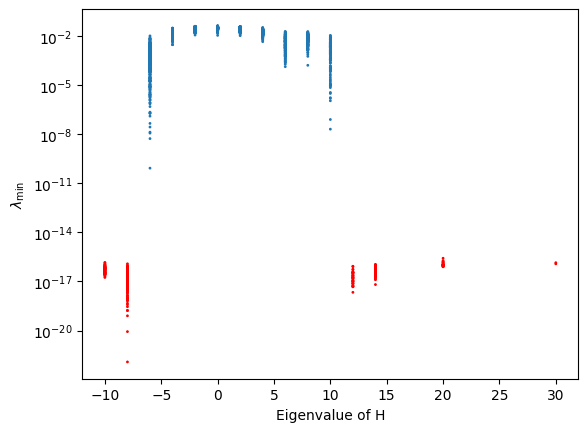

Indices of red points: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 2

In [8]:
# rdm - numpy

min_eigenvalues_np = []
min_rdms_np =[]
rdm_eigenvalues_np = []

for i in tqdm(range(len(eigenvalues))):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())

    # Trace out qubits
    traced_out_density_matrix = ptrace_numpy(density_matrix, keep_qubits, [[2]*N, [2]*N])

    # Diagonalize the traced-out density matrix
    eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(traced_out_density_matrix)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = np.min(eigenvalues_traced) 
    min_eigenvalues_np.append(min_eigenvalue)

    if min_eigenvalue < 1e-16:
        min_rdms_np.append(traced_out_density_matrix) #store the scarred rdms - step needed for optimization
        rdm_eigenvalues_np.append(eigenvalues_traced) #store the eigenvalues of the scarred rdms

# numpy

# Define the threshold
threshold = 1e-16
min_eigenvalues_np = np.array(min_eigenvalues_np)

# Count points with y-component less than the threshold
count = sum(1 for y in min_eigenvalues_np if y < threshold)

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues_np]

# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.scatter(eigenvalues, np.abs(min_eigenvalues_np), color=colors, s=1)

plt.xlabel('Eigenvalue of H')
plt.ylabel(r"$\lambda_{\text{min}}$")
plt.yscale("log")
plt.show()

# Find indices of red points - numpy
red_indices_np = [i for i, y in enumerate(min_eigenvalues_np) if y < threshold]
print(f'Indices of red points: {red_indices_np}')

red_eigenvectors_np = []

# Print eigenvalues, RDM minimum eigenvalues, and scalar products of eigenvectors for red points
for i,ind in enumerate(red_indices_np):
    print(i, ind)
    print(f'Eigenvalue: {eigenvalues[ind]}, rdm Minimum Eigenvalue: {min_eigenvalues_np[ind]}')
    print(f'Eigenvector {ind}: rdm rank: {np.linalg.matrix_rank(min_rdms_np[i])}')
    red_eigenvectors_np.append(eigenvectors[:, ind])

#for i in range(len(red_indices_np)):
#    for j in range(len(red_indices_np)):
#        idx1, idx2 = red_indices_np[i], red_indices_np[j]
#        dot_product = np.dot(eigenvectors[:, idx1], np.conj(eigenvectors[:, idx2]))
#        print(f"Dot product between eigenvectors {idx1} and {idx2}: {dot_product}")

# Count entries of rdm_eigenvalues_np[i] - eigenvalues of the scarred rdms - that are non-zero
counts_np = [np.sum(eigenvalues > 1e-16) for eigenvalues in rdm_eigenvalues_np]
print(f'Counts of non-zero eigenvalues of the scarred rdms: {counts_np}')

In [ ]:
'''# rdm - torch

min_eigenvalues_to = []
min_rdms_to = []
rdm_eigenvalues_to = []

for i in tqdm(range(len(eigenvalues))):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    min_eigenvector_torch = torch.tensor(min_eigenvector, dtype=torch.float64)
    density_matrix = torch.outer(min_eigenvector_torch, min_eigenvector_torch.conj())

    # Trace out qubits
    traced_out_density_matrix = ptrace_torch(density_matrix, keep_qubits, [[2] * N, [2] * N])
    traced_out_density_matrix = torch.tensor(traced_out_density_matrix, dtype=torch.float64) # necessary step to ensure that the scarred states have lambda_min of the correct order - <1e-16 

    # Diagonalize the traced-out density matrix
    eigenvalues_traced, eigenvectors_traced = torch.linalg.eigh(traced_out_density_matrix)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = torch.min(eigenvalues_traced).item()
    min_eigenvalues_to.append(min_eigenvalue)

    if min_eigenvalue < 1e-16:
        min_rdms_to.append(traced_out_density_matrix.detach().cpu().numpy())  # store the scarred rdms - step needed for optimization
        rdm_eigenvalues_to.append(eigenvalues_traced.detach().cpu().numpy()) # store the eigenvalues of the scarred rdms

# Define the threshold
threshold = 1e-16
min_eigenvalues_to = np.array(min_eigenvalues_to)

# Count points with y-component less than the threshold
count = sum(1 for y in min_eigenvalues_to if y < threshold)

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues_to]

# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.scatter(eigenvalues, np.abs(min_eigenvalues_to), color=colors, s=1)

plt.xlabel('Eigenvalue of H')
plt.ylabel(r"$\lambda_{\text{min}}$")
plt.yscale("log")
plt.show()

# Find indices of red points - torch
red_indices_to = [i for i, y in enumerate(min_eigenvalues_to) if y < threshold]
print(f'Indices of red points: {red_indices_to}')

red_eigenvectors_to = []

# Print eigenvalues, RDM minimum eigenvalues, and scalar products of eigenvectors for red points
for i,ind in enumerate(red_indices_to):
    print(i, ind)
    print(f'Eigenvalue: {eigenvalues[ind]}, rdm Minimum Eigenvalue: {min_eigenvalues_to[ind]}')
    print(f'Eigenvector {ind}: rdm rank: {np.linalg.matrix_rank(min_rdms_to[i])}')
    red_eigenvectors_to.append(eigenvectors[:, ind])

for i in range(len(red_indices_to)):
    for j in range(len(red_indices_to)):
        idx1, idx2 = red_indices_to[i], red_indices_to[j]
        dot_product = np.dot(eigenvectors[:, idx1], np.conj(eigenvectors[:, idx2]))
        print(f"Dot product between eigenvectors {idx1} and {idx2}: {dot_product}")

# Count entries of rdm_eigenvalues_to[i] - eigenvalues of the scarred rdms - that are non-zero
counts_to = [np.sum(eigenvalues > 1e-15) for eigenvalues in rdm_eigenvalues_to]
print(f'Counts of non-zero eigenvalues of the scarred rdms: {counts_to}')'''

'# rdm - torch\n\nmin_eigenvalues_to = []\nmin_rdms_to = []\nrdm_eigenvalues_to = []\n\nfor i in tqdm(range(len(eigenvalues))):\n    # Construct the density matrix for each eigenvector\n    min_eigenvector = eigenvectors[:, i]\n    min_eigenvector_torch = torch.tensor(min_eigenvector, dtype=torch.float64)\n    density_matrix = torch.outer(min_eigenvector_torch, min_eigenvector_torch.conj())\n\n    # Trace out qubits\n    traced_out_density_matrix = ptrace_torch(density_matrix, keep_qubits, [[2] * N, [2] * N])\n    traced_out_density_matrix = torch.tensor(traced_out_density_matrix, dtype=torch.float64) # necessary step to ensure that the scarred states have lambda_min of the correct order - <1e-16 \n\n    # Diagonalize the traced-out density matrix\n    eigenvalues_traced, eigenvectors_traced = torch.linalg.eigh(traced_out_density_matrix)\n\n    # Find the minimum eigenvalue of the traced-out density matrix\n    min_eigenvalue = torch.min(eigenvalues_traced).item()\n    min_eigenvalues_

In [ ]:
half_v = [0,2,4,5,8,9]
half_h = [0,2,5,7,9,11]

half = half_h

In [ ]:
# Generate random complex coefficients
random_coeffs = np.random.rand(len(red_indices_np)) + 1j* np.random.rand(len(red_indices_np))

# Normalize the coefficients
random_coeffs /= np.linalg.norm(random_coeffs)
print(random_coeffs)

print("coeffs norm",sum(np.abs(random_coeffs)**2))

# Define random scar state from 5 scarred states using random coefficients
rnd_scar = np.sum(eigenvectors[:, red_indices_np] * random_coeffs, axis=1)

print(len(rnd_scar))

# Save eigenvalues corresponding to red indices into a numpy array
red_eigenvalues = np.array([eigenvalues[i] for i in red_indices_np])

# Count the number of zero entries
num_zeros = np.count_nonzero((rnd_scar.real < 1e-16) & (rnd_scar.imag < 1e-16))
print(f'Number of zero entries: {num_zeros}')

# RANDOM SCAR - RANDOM LINEAR COMBINATION OF SCARRED STATES

rnd_scar = linear_combination_np(random_coeffs, red_eigenvectors_np)
rnd_scar_entropy = entanglement_entropy(rnd_scar, half, N)
#rnd_scar_entropy_qutip = entanglement_entropy_qutip(rnd_scar, half, N)
#rnd_scar_entropy_torch = entanglement_entropy_torch(rnd_scar, half, N)
print("Random scar coeffs", random_coeffs)
print(f"Entanglement entropy of random scar state: {rnd_scar_entropy}")
#print(f"Entanglement entropy of random scar state (Qutip): {rnd_scar_entropy_qutip}")
#print(f"Entanglement entropy of random scar state (PyTorch): {rnd_scar_entropy_torch}")

[0.44788018+0.03530615j 0.15472185+0.20050048j 0.12907356+0.65593335j
 0.16261189+0.40237955j 0.23041998+0.21369062j]
coeffs norm 1.0
4096
Number of zero entries: 3930
Random scar coeffs [0.44788018+0.03530615j 0.15472185+0.20050048j 0.12907356+0.65593335j
 0.16261189+0.40237955j 0.23041998+0.21369062j]
Entanglement entropy of random scar state: 3.45817816876527


In [ ]:
# Compute bipartite entanglement entropy for all eigenstates in the full Hilbert space
numpy_entropies = [entanglement_entropy(eigenvectors[:, i], half, N) for i in tqdm(range(eigenvectors.shape[1]))]
#qutip_entropies = [entanglement_entropy_qutip(eigenvectors[:, i], half, N) for i in tqdm(range(eigenvectors.shape[1]))]
#torch_entropies = [entanglement_entropy_torch(eigenvectors[:, i], half, N) for i in tqdm(range(eigenvectors.shape[1]))]

100%|██████████| 4096/4096 [14:56<00:00,  4.57it/s]


Entropies of red points:
Index: 1266, Entropy: 3.6664899664142334
Index: 1267, Entropy: 3.8609454779097785
Index: 1268, Entropy: 3.4789638768785487
Index: 1269, Entropy: 3.426551079718025
Index: 1270, Entropy: 3.73950803393908
Random scar entropy: 3.45817816876527


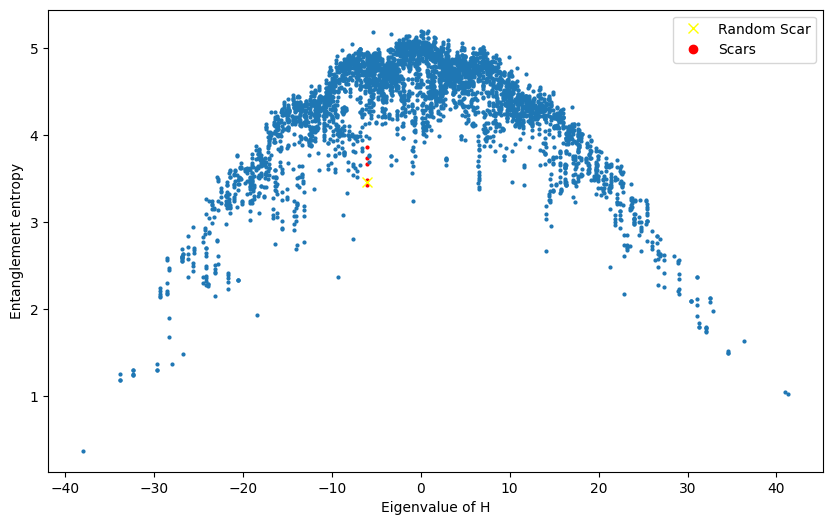

In [ ]:
# Print entropies of red points only
print("Entropies of red points:")
for i in red_indices_np:
    print(f'Index: {i}, Entropy: {numpy_entropies[i]}')

print(f'Random scar entropy: {rnd_scar_entropy}')

# Plot entanglement entropy as a function of energy eigenvalues
plt.figure(figsize=(10, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues_np]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    plt.plot(eigenvalues[i], numpy_entropies[i], 'o', color=color, markersize=2)

# Plot the maximum scar entropy in yellow
plt.plot(np.mean(red_eigenvalues), rnd_scar_entropy, 'x', color='yellow', markersize=7, label='Random Scar')

# Add legend for red points only with text "scars"
red_points = [i for i, color in enumerate(colors) if color == 'red']
if red_points:
    plt.plot([], [], 'o', color='red', label='Scars')

plt.xlabel('Eigenvalue of H')
plt.ylabel('Entanglement entropy')
plt.legend()
plt.show()

Entropies of red points:
Index: 1266, Entropy: 3.6664899664142334
Index: 1267, Entropy: 3.8609454779097785
Index: 1268, Entropy: 3.4789638768785487
Index: 1269, Entropy: 3.426551079718025
Index: 1270, Entropy: 3.73950803393908


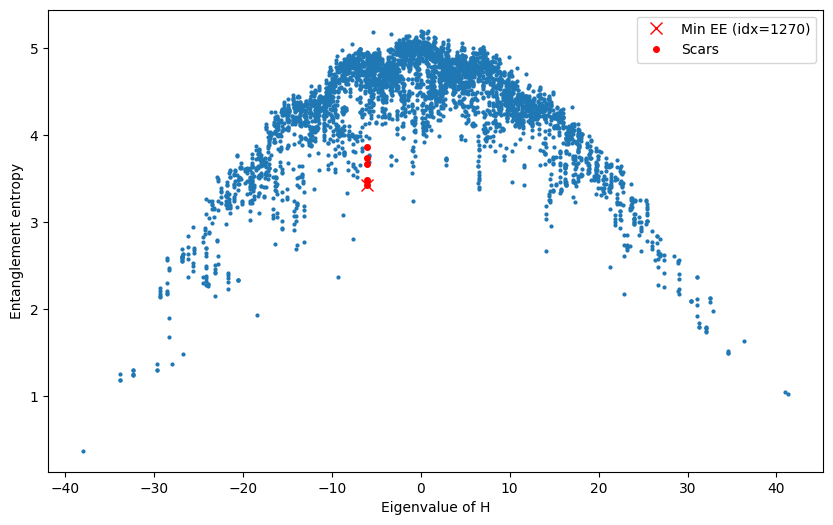

In [ ]:
# Print entropies of red points only
print("Entropies of red points:")
for i in red_indices_np:
    print(f'Index: {i}, Entropy: {numpy_entropies[i]}')

# Find the red index with the lowest entanglement entropy
min_entropy_idx = min(red_indices_np, key=lambda i: numpy_entropies[i])
min_entropy_val = numpy_entropies[min_entropy_idx]

# Plot entanglement entropy as a function of energy eigenvalues
plt.figure(figsize=(10, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues_np]

# Plot blue points first
for i, color in enumerate(colors):
    if color != 'red':
        plt.plot(eigenvalues[i], numpy_entropies[i], 'o', color=color, markersize=2)
# Then plot red points on top
for i, color in enumerate(colors):
    if color == 'red':
        plt.plot(eigenvalues[i], numpy_entropies[i], 'o', color=color, markersize=4)

# Plot entanglement entropy with highlighted points
#for i, color in enumerate(colors):
#    size = 3 if color == 'red' else 2
#    plt.plot(eigenvalues[i], numpy_entropies[i], 'o', color=color, markersize=size)

# Mark the scar with the lowest entanglement entropy with a yellow cross
plt.plot(eigenvalues[min_entropy_idx], min_entropy_val, 'x', color='red', markersize=8, label=f'Min EE (idx={min_entropy_idx + 1})')

# Add legend for red points only with text "scars"
red_points = [i for i, color in enumerate(colors) if color == 'red']
if red_points:
    plt.plot([], [], 'o', color='red', markersize=4, label='Scars')

plt.xlabel('Eigenvalue of H')
plt.ylabel('Entanglement entropy')
plt.legend()
plt.show()

In [ ]:
'''# Compute entanglement entropy for the rnd_scar wavefunction - qutip

# Print entropies of red points only
print("Entropies of red points:")
for i in red_indices:
    print(f'Index: {i}, Entropy: {qutip_entropies[i]}')

print(f'Random scar entropy: {rnd_scar_entropy_qutip}')

# Plot entanglement entropy as a function of energy eigenvalues
plt.figure(figsize=(10, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    plt.plot(eigenvalues[i], qutip_entropies[i], 'o', color=color, markersize=2)

# Plot the maximum scar entropy in yellow
plt.plot(np.mean(red_eigenvalues), rnd_scar_entropy_qutip, 'x', color='yellow', markersize=7, label='Random Scar')

# Add legend for red points only with text "scars"
red_points = [i for i, color in enumerate(colors) if color == 'red']
if red_points:
    plt.plot([], [], 'o', color='red', label='Scars')

plt.xlabel('Eigenvalue of H')
plt.ylabel('Entanglement entropy')
#plt.title('Entanglement entropy as a function of energy eigenvalues')
plt.legend()
plt.show()'''

'# Compute entanglement entropy for the rnd_scar wavefunction - qutip\n\n# Print entropies of red points only\nprint("Entropies of red points:")\nfor i in red_indices:\n    print(f\'Index: {i}, Entropy: {qutip_entropies[i]}\')\n\nprint(f\'Random scar entropy: {rnd_scar_entropy_qutip}\')\n\n# Plot entanglement entropy as a function of energy eigenvalues\nplt.figure(figsize=(10, 6))\n\n# Highlight points with y-component less than the threshold in red\ncolors = [\'red\' if y < threshold else \'C0\' for y in min_eigenvalues]\n\n# Plot entanglement entropy with highlighted points\nfor i, color in enumerate(colors):\n    plt.plot(eigenvalues[i], qutip_entropies[i], \'o\', color=color, markersize=2)\n\n# Plot the maximum scar entropy in yellow\nplt.plot(np.mean(red_eigenvalues), rnd_scar_entropy_qutip, \'x\', color=\'yellow\', markersize=7, label=\'Random Scar\')\n\n# Add legend for red points only with text "scars"\nred_points = [i for i, color in enumerate(colors) if color == \'red\']\nif 

In [ ]:
'''# Compute entanglement entropy for the rnd_scar wavefunction - torch

# Print entropies of red points only
print("Entropies of red points:")
for i in red_indices:
    print(f'Index: {i}, Entropy: {torch_entropies[i]}')

print(f'Random scar entropy: {rnd_scar_entropy_torch}')

# Plot entanglement entropy as a function of energy eigenvalues
plt.figure(figsize=(10, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    plt.plot(eigenvalues[i], torch_entropies[i], 'o', color=color, markersize=2)

# Plot the maximum scar entropy in yellow
plt.plot(np.mean(red_eigenvalues), rnd_scar_entropy_torch, 'x', color='yellow', markersize=7, label='Random Scar')

# Add legend for red points only with text "scars"
red_points = [i for i, color in enumerate(colors) if color == 'red']
if red_points:
    plt.plot([], [], 'o', color='red', label='Scars')

plt.xlabel('Eigenvalue of H')
plt.ylabel('Entanglement entropy')
#plt.title('Entanglement entropy as a function of energy eigenvalues')
plt.legend()
plt.show()'''

'# Compute entanglement entropy for the rnd_scar wavefunction - torch\n\n# Print entropies of red points only\nprint("Entropies of red points:")\nfor i in red_indices:\n    print(f\'Index: {i}, Entropy: {torch_entropies[i]}\')\n\nprint(f\'Random scar entropy: {rnd_scar_entropy_torch}\')\n\n# Plot entanglement entropy as a function of energy eigenvalues\nplt.figure(figsize=(10, 6))\n\n# Highlight points with y-component less than the threshold in red\ncolors = [\'red\' if y < threshold else \'C0\' for y in min_eigenvalues]\n\n# Plot entanglement entropy with highlighted points\nfor i, color in enumerate(colors):\n    plt.plot(eigenvalues[i], torch_entropies[i], \'o\', color=color, markersize=2)\n\n# Plot the maximum scar entropy in yellow\nplt.plot(np.mean(red_eigenvalues), rnd_scar_entropy_torch, \'x\', color=\'yellow\', markersize=7, label=\'Random Scar\')\n\n# Add legend for red points only with text "scars"\nred_points = [i for i, color in enumerate(colors) if color == \'red\']\nif 

Entropies of red points:
Index: 1266, Entropy: 3.6664899664142334
Index: 1267, Entropy: 3.8609454779097785
Index: 1268, Entropy: 3.4789638768785487
Index: 1269, Entropy: 3.426551079718025
Index: 1270, Entropy: 3.73950803393908
Random scar entropy: 3.45817816876527


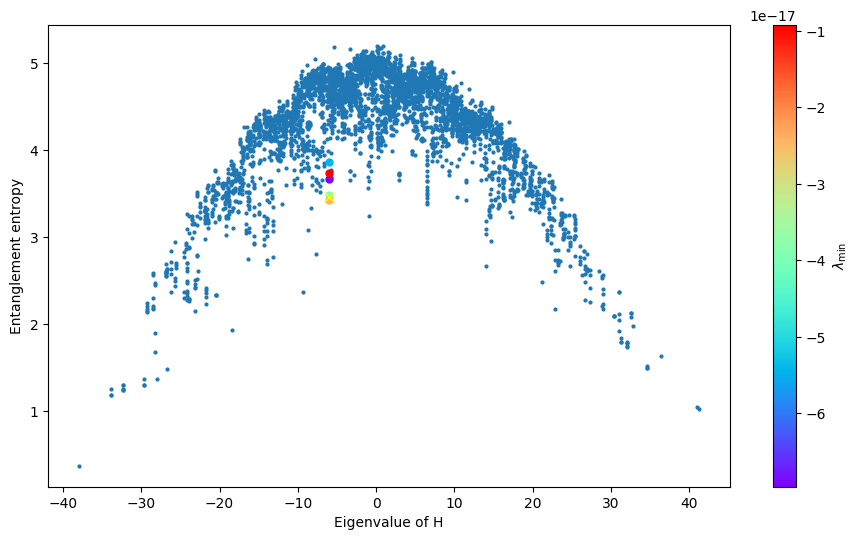

In [ ]:
# Define a list of colors for red points
red_colors = plt.cm.rainbow(np.linspace(0, 1, len(red_indices_np)))

# Print entropies of red points only
print("Entropies of red points:")
for i in red_indices_np:
    print(f'Index: {i}, Entropy: {numpy_entropies[i]}')

print(f'Random scar entropy: {rnd_scar_entropy}')

# Plot entanglement entropy as a function of energy eigenvalues
fig, ax = plt.subplots(figsize=(11, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues_np]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    ax.plot(eigenvalues[i], numpy_entropies[i], 'o', color=color, markersize=2)

# Collect handles and labels for the legend
handles = []
labels = []

# Plot each red point with a different color and collect handles and labels
for i, idx in enumerate(red_indices_np):
    handle, = ax.plot(eigenvalues[idx], numpy_entropies[idx], 'o', color=red_colors[i], markersize=5)
    handles.append(handle)
    labels.append(f'λ_min: {float(min_eigenvalues_np[idx]):.2e}, Entropy: {numpy_entropies[idx]:.2f}')

# Plot the maximum scar entropy in yellow and add to handles and labels
max_scar_handle, = ax.plot(np.mean(red_eigenvalues), rnd_scar_entropy, 'x', color='yellow', markersize=7)
handles.append(max_scar_handle)
labels.append('Max Scar, Entropy: {:.2f}'.format(rnd_scar_entropy))

# Sort handles and labels by lambda min
sorted_handles_labels = sorted(zip(handles, labels), key=lambda hl: float(hl[1].split(': ')[1].split(',')[0]) if 'λ_min' in hl[1] else float('inf'))
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

# Filter min_eigenvalues to include only those corresponding to red_indices
filtered_min_eigenvalues = [min_eigenvalues_np[idx] for idx in red_indices_np]

# Create a color bar for the red points using filtered min_eigenvalues
norm = Normalize(vmin=min(filtered_min_eigenvalues), vmax=max(filtered_min_eigenvalues))
sm = ScalarMappable(cmap='rainbow', norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, label=r'$\lambda_{\mathrm{min}}$')

ax.set_xlabel('Eigenvalue of H')
ax.set_ylabel('Entanglement entropy')
#ax.set_title('Entanglement entropy as a function of energy eigenvalues')
plt.show()

In [ ]:
#################### OPTIMAL LINEAR COMBINATION OF SCARS THAT  MINIMIZE/MAXIMIZE EE ##########################

In [ ]:
# Let's look closer at the scar points with the lowest and highest entropy (Indeces: 1267, 1268)

# MIN ENTROPY

lowest_entropy_index = 1267
lowest_entropy_eigenvector = eigenvectors[:, lowest_entropy_index]
entanglement_entropy_value = entanglement_entropy(lowest_entropy_eigenvector, half, N)
print(f'Lowest Entropy Index: {lowest_entropy_index}, Entropy: {entanglement_entropy_value}')   

# Convert the eigenvector to PyTorch tensors for real and imaginary parts
params_real = torch.tensor(lowest_entropy_eigenvector.real, dtype=torch.float, requires_grad=True)
params_imag = torch.tensor(lowest_entropy_eigenvector.imag, dtype=torch.float, requires_grad=True)

print("Initial coeffs, real:", params_real)
print("Initial coeffs, imag:", params_imag)

entanglement_entropy_value = entanglement_entropy_torch(lowest_entropy_eigenvector, half, N)
print(f'Lowest Entropy Index: {lowest_entropy_index}, Entropy: {entanglement_entropy_value}')

# Define coefficients for the linear combination
min_coeffs = np.zeros(len(red_eigenvectors_np), dtype=np.complex128)  # Initialize all coefficients to 0
min_coeffs[red_indices_np.index(1267)] = 1  # Ensure the coefficient for index 1267 is explicitly set to 1


# MAX ENTROPY
highest_entropy_index = 1268
highest_entropy_eigenvector = eigenvectors[:, highest_entropy_index]
entanglement_entropy_value = entanglement_entropy(highest_entropy_eigenvector, half, N)
print(f'Highest Entropy Index: {highest_entropy_index}, Entropy: {entanglement_entropy_value}') 

# Convert the eigenvector to PyTorch tensors for real and imaginary parts
params_real = torch.tensor(lowest_entropy_eigenvector.real, dtype=torch.float, requires_grad=True)
params_imag = torch.tensor(lowest_entropy_eigenvector.imag, dtype=torch.float, requires_grad=True)

print("Initial coeffs, real:", params_real)
print("Initial coeffs, imag:", params_imag)

entanglement_entropy_value = entanglement_entropy_torch(highest_entropy_eigenvector, half, N)
print(f'Highest Entropy Index: {highest_entropy_index}, Entropy: {entanglement_entropy_value}')

# Define coefficients for the linear combination
max_coeffs = np.zeros(len(red_eigenvectors_np), dtype=np.complex128)  # Initialize all coefficients to 0
max_coeffs[red_indices_np.index(1268)] = 1  # Ensure the coefficient for index 1268 is explicitly set to 1


Lowest Entropy Index: 1267, Entropy: 3.8609454779097785
Initial coeffs, real: tensor([0., 0., 0.,  ..., 0., 0., 0.], requires_grad=True)
Initial coeffs, imag: tensor([0., 0., 0.,  ..., 0., 0., 0.], requires_grad=True)
Lowest Entropy Index: 1267, Entropy: 3.860943555831909
Highest Entropy Index: 1268, Entropy: 3.4789638768785487
Initial coeffs, real: tensor([0., 0., 0.,  ..., 0., 0., 0.], requires_grad=True)
Initial coeffs, imag: tensor([0., 0., 0.,  ..., 0., 0., 0.], requires_grad=True)
Highest Entropy Index: 1268, Entropy: 3.47896409034729


In [ ]:
# find entropy min coeffs - everything  has to be in torch

# Initialize parameters for the coefficients with all values equal
#params_real = torch.full((5,), 1/np.sqrt(10), requires_grad=True)
#params_imag = torch.full((5,), 1/np.sqrt(10), requires_grad=True)

# Initialize parameters for the coefficients with random values
#params_real = torch.randn(5, requires_grad=True)
#params_imag = torch.randn(5, requires_grad=True)

# Convert random_coeffs to PyTorch tensors
#params_real = torch.tensor(random_coeffs.real, dtype=torch.float, requires_grad=True)
#params_imag = torch.tensor(random_coeffs.imag, dtype=torch.float, requires_grad=True)

red_eigenvectors = [torch.tensor(vec, dtype=torch.complex64) for vec in red_eigenvectors_np]


params_real = torch.tensor(min_coeffs.real, dtype=torch.float, requires_grad=True)
params_imag = torch.tensor(min_coeffs.imag, dtype=torch.float, requires_grad=True)

# Compute the linear combination using the defined function
psi = linear_combination(torch.complex(params_real, params_imag), red_eigenvectors)

# if the outer products between scarred states are computed before optimization loop
# ....

# Compute entanglement entropy
entropy = entanglement_entropy_torch(psi, half, N) 
print(f'Initial Entropy: {entropy.item()}')

# Normalize the parameters to ensure the norm is 1
with torch.no_grad():
    norm = torch.norm(torch.complex(params_real, params_imag))
    params_real /= norm
    params_imag /= norm

# Define the optimizer
optimizer = optim.Adam([params_real, params_imag], lr=0.01)

# Lists to store the values of parameters and entropy
coeffs_history_min = []
entropy_history = []

# Optimization loop
num_iterations = 150
for _ in range(num_iterations):
    optimizer.zero_grad()
    
    # Combine real and imaginary parts for the coefficients
    coeffs = torch.complex(params_real, params_imag)
    
    # Normalize coefficients to project them onto the unit sphere
    coeffs = coeffs / torch.norm(coeffs)
    
    # Compute psi
    psi = linear_combination(coeffs, red_eigenvectors)
    
    # Compute entanglement entropy
    entropy = entanglement_entropy_torch(psi, half, N) # it would be better to compute the outer product of the state before the optimization loop. but optimization is not taking too long so it's ok for now
    
    # Backpropagation
    entropy.backward()
    optimizer.step()
    
    # Normalize parameters again to ensure they stay on the unit sphere
    with torch.no_grad():
        norm = torch.norm(torch.complex(params_real, params_imag))
        params_real /= norm
        params_imag /= norm
    print("Coeffs norm:", torch.norm(torch.complex(params_real, params_imag)).detach().cpu().numpy())
    
    print(f'Entropy: {entropy.item()}')
    print(f'Coeffs: {coeffs.detach().cpu().numpy()}')

    # Store the values of parameters and entropy
    coeffs_history_min.append(coeffs.detach().cpu().numpy())
    entropy_history.append(entropy.item())

# Final optimized coefficients
optimized_coeffs = torch.complex(params_real, params_imag)
optimized_coeffs = optimized_coeffs / torch.norm(optimized_coeffs)

print("Optimized coefficients:", optimized_coeffs)

# Plot the value of parameters and entropy as a function of num_iterations
plt.figure(figsize=(12, 6))

# Plot entropy
plt.subplot(1, 2, 1)
plt.plot(entropy_history)
plt.xlabel('Iteration')
plt.ylabel('Entropy')
#plt.title('Entropy vs. Iterations')

# Plot coefficients
plt.subplot(1, 2, 2)
coeffs_history_min = np.array(coeffs_history_min)
for i in range(coeffs_history_min.shape[1]):
    plt.plot(coeffs_history_min[:, i].real, label=f'Coeff {i+1} Real')
    plt.plot(coeffs_history_min[:, i].imag, label=f'Coeff {i+1} Imag', linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Coefficient Value')
#plt.title('Coefficients vs. Iterations')
plt.legend()

plt.tight_layout()
plt.show()

Initial Entropy: 3.860943078994751


RuntimeError: Numpy is not available

In [ ]:
# Compute the max_scar wavefunction using the optimized coefficients (min entropy)
min_scar = linear_combination_np(coeffs_history_min[-1], red_eigenvectors_np)
# Define a list of colors for red points
red_colors = plt.cm.rainbow(np.linspace(0, 1, len(red_indices_np)))

# Compute entanglement entropy for the max_scar wavefunction
min_scar_entropy = entanglement_entropy(min_scar, half, N)

# Print entropies of red points only
print("Entropies of red points:")
for i in red_indices_np:
    print(f'Index: {i}, Entropy: {numpy_entropies[i]}')

print(f'Min scar entropy: {min_scar_entropy}')

# Plot entanglement entropy as a function of energy eigenvalues
fig, ax = plt.subplots(figsize=(10, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues_np]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    ax.plot(eigenvalues[i], numpy_entropies[i], 'o', color=color, markersize=2)

# Collect handles and labels for the legend
handles = []
labels = []

# Plot each red point with a different color and collect handles and labels
for i, idx in enumerate(red_indices_np):
    handle, = ax.plot(eigenvalues[idx], numpy_entropies[idx], 'o', color=red_colors[i], markersize=5)
    handles.append(handle)
    labels.append(r'$\lambda_\mathrm{min}$: {float(min_eigenvalues[idx]):.2e}, Entropy: {naive_entropies[idx]:.2f}')

# Plot the maximum scar entropy in yellow and add to handles and labels
min_scar_handle, = ax.plot(np.mean(eigenvalues[red_indices_np]), min_scar_entropy, 'x', color='black', markersize=7)
handles.append(min_scar_handle)
labels.append('Min Scar, Entropy: {:.2f}'.format(min_scar_entropy))

# Sort handles and labels by lambda min
sorted_handles_labels = sorted(zip(handles, labels), key=lambda hl: float(hl[1].split(': ')[1].split(',')[0]) if 'λ_min' in hl[1] else float('inf'))
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

# Filter min_eigenvalues to include only those corresponding to red_indices
filtered_min_eigenvalues = [min_eigenvalues_np[idx] for idx in red_indices_np]

# Create a color bar for the red points using filtered min_eigenvalues
norm = Normalize(vmin=min(filtered_min_eigenvalues), vmax=max(filtered_min_eigenvalues))
sm = ScalarMappable(cmap='rainbow', norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, label=r'$\lambda_{\mathrm{min}}$')

ax.set_xlabel('Eigenvalue of H')
ax.set_ylabel('Entanglement entropy')
plt.show()

In [ ]:
# now find entropy max coeffs - everything  has to be in torch

# Initialize parameters for the coefficients with all values equal
#params_real = torch.full((5,), 1/np.sqrt(10), requires_grad=True)
#params_imag = torch.full((5,), 1/np.sqrt(10), requires_grad=True)

# Initialize parameters for the coefficients with random values
#params_real = torch.randn(5, requires_grad=True)
#params_imag = torch.randn(5, requires_grad=True)

# Convert random_coeffs to PyTorch tensors
#params_real = torch.tensor(random_coeffs.real, dtype=torch.float, requires_grad=True)
#params_imag = torch.tensor(random_coeffs.imag, dtype=torch.float, requires_grad=True)

params_real = torch.tensor(max_coeffs.real, dtype=torch.float, requires_grad=True)
params_imag = torch.tensor(max_coeffs.imag, dtype=torch.float, requires_grad=True)

print("Initial coeffs, real", params_real)
print("Initial coeffs imag",  params_imag)

# Compute psi
psi = linear_combination(torch.complex(params_real, params_imag), red_eigenvectors)

# Compute entanglement entropy
entropy = entanglement_entropy_torch(psi, half, N) 
print(f'Initial Entropy: {entropy.item()}')

# Normalize the parameters to ensure the norm is 1
with torch.no_grad():
    norm = torch.norm(torch.complex(params_real, params_imag))
    params_real /= norm
    params_imag /= norm

# Define the optimizer
optimizer = optim.Adam([params_real, params_imag], lr=0.01)

# Lists to store the values of parameters and entropy
coeffs_history_max = []
entropy_history_max = []

# Optimization loop
num_iterations = 150
for _ in range(num_iterations):
    optimizer.zero_grad()
    
    # Combine real and imaginary parts for the coefficients
    coeffs = torch.complex(params_real, params_imag)
    
    # Normalize coefficients to project them onto the unit sphere
    coeffs = coeffs / torch.norm(coeffs)
    
    # Compute psi
    psi = linear_combination(coeffs, red_eigenvectors)
    
    # Compute - entanglement entropy
    entropy = - entanglement_entropy_torch(psi, half, N) # it would be better to compute the outer product of the state before the optimization loop. but optimization is not taking too long so it's ok for now
    
    # Backpropagation
    entropy.backward()
    optimizer.step()
    
    # Normalize parameters again to ensure they stay on the unit sphere
    with torch.no_grad():
        norm = torch.norm(torch.complex(params_real, params_imag))
        params_real /= norm
        params_imag /= norm
    print("Coeffs norm:", torch.norm(torch.complex(params_real, params_imag)).detach().cpu().numpy())
    
    print(f'Entropy: {abs(entropy.item())}')
    print(f'Coeffs: {coeffs.detach().cpu().numpy()}')

    # Store the values of parameters and entropy
    coeffs_history_max.append(coeffs.detach().cpu().numpy())
    entropy_history_max.append(abs(entropy.item()))

# Final optimized coefficients
optimized_coeffs_max = torch.complex(params_real, params_imag)
optimized_coeffs_max = optimized_coeffs_max / torch.norm(optimized_coeffs_max)

print("Optimized coefficients:", optimized_coeffs_max)

# Plot the value of parameters and entropy as a function of num_iterations
plt.figure(figsize=(12, 6))

# Plot entropy
plt.subplot(1, 2, 1)
plt.plot(np.abs(entropy_history_max))
plt.xlabel('Iteration')
plt.ylabel('Entropy')
#plt.title('Entropy vs. Iterations')

# Plot coefficients
plt.subplot(1, 2, 2)
coeffs_history_max = np.array(coeffs_history_max)
for i in range(coeffs_history_max.shape[1]):
    plt.plot(coeffs_history_max[:, i].real, label=f'Coeff {i+1} Real')
    plt.plot(coeffs_history_max[:, i].imag, label=f'Coeff {i+1} Imag', linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Coefficient Value')
#plt.title('Coefficients vs. Iterations')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Compute the max_scar wavefunction using the optimized coefficients (min entropy)
max_scar = linear_combination_np(coeffs_history_max[-1], red_eigenvectors_np)
# Define a list of colors for red points
red_colors = plt.cm.rainbow(np.linspace(0, 1, len(red_indices_np)))

# Compute entanglement entropy for the max_scar wavefunction
max_scar_entropy = entanglement_entropy(max_scar, half, N)

# Print entropies of red points only
print("Entropies of red points:")
for i in red_indices_np:
    print(f'Index: {i}, Entropy: {numpy_entropies[i]}')

print(f'Max scar entropy: {max_scar_entropy}')

# Plot entanglement entropy as a function of energy eigenvalues
fig, ax = plt.subplots(figsize=(10, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues_np]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    ax.plot(eigenvalues[i], numpy_entropies[i], 'o', color=color, markersize=2)

# Collect handles and labels for the legend
handles = []
labels = []

# Plot each red point with a different color and collect handles and labels
for i, idx in enumerate(red_indices_np):
    handle, = ax.plot(eigenvalues[idx], numpy_entropies[idx], 'o', color=red_colors[i], markersize=5)
    handles.append(handle)
    labels.append(r'$\lambda_\mathrm{min}$: {float(min_eigenvalues[idx]):.2e}, Entropy: {naive_entropies[idx]:.2f}')

# Plot the maximum scar entropy in yellow and add to handles and labels
max_scar_handle, = ax.plot(np.mean(eigenvalues[red_indices_np]), max_scar_entropy, 'x', color='black', markersize=7)
handles.append(max_scar_handle)
labels.append('Max Scar, Entropy: {:.2f}'.format(max_scar_entropy))

# Sort handles and labels by lambda min
sorted_handles_labels = sorted(zip(handles, labels), key=lambda hl: float(hl[1].split(': ')[1].split(',')[0]) if 'λ_min' in hl[1] else float('inf'))
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

# Filter min_eigenvalues to include only those corresponding to red_indices
filtered_min_eigenvalues = [min_eigenvalues_np[idx] for idx in red_indices_np]

# Create a color bar for the red points using filtered min_eigenvalues
norm = Normalize(vmin=min(filtered_min_eigenvalues), vmax=max(filtered_min_eigenvalues))
sm = ScalarMappable(cmap='rainbow', norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, label=r'$\lambda_{\mathrm{min}}$')

ax.set_xlabel('Eigenvalue of H')
ax.set_ylabel('Entanglement entropy')
#ax.set_title('Entanglement entropy as a function of energy eigenvalues')
#ax.legend(sorted_handles, sorted_labels)
plt.show()

In [ ]:
################## PROPERTIES OF EACH SCARRED STATE AND THEIR RDM ######################

In [ ]:
# List to store the number of dependent columns and their indices for each matrix
dependent_columns_info = []

for idx, rdm in enumerate(min_rdms_np):
    print(f"RDM Index: {idx}")
    
    # Perform QR decomposition with column pivoting
    Q, R, pivot_indices = qr(rdm, pivoting=True)
    
    # Determine rank using a threshold on the diagonal of R
    tol = 1e-12
    rank = np.sum(np.abs(np.diag(R)) > tol)
    
    # Calculate the number of dependent columns
    num_dependent_columns = 16 - rank
    
    # Identify dependent columns
    dependent_columns = sorted(set(range(16)) - set(pivot_indices[:rank]))
    dependent_columns_info.append((num_dependent_columns, dependent_columns))
    
    print(f"Number of dependent columns: {num_dependent_columns}")
    print(f"Dependent columns indices: {dependent_columns}")
    print("-" * 50)

# Print the results
print("Dependent columns info for each matrix:", dependent_columns_info)

In [ ]:
# List to store the null space information for each matrix
null_spaces_info = []

for idx, rdm in enumerate(min_rdms_np):
    print(f"RDM Index: {idx}")
    
    # Compute the null space of the RDM
    null_space_rdm = null_space(rdm)
    
    # Store the null space information
    null_spaces_info.append(null_space_rdm)
    
    # Print the null space dimensions and basis vectors
    print(f"Null space dimension: {null_space_rdm.shape[1]}")
    print(f"Null space basis vectors:\n{null_space_rdm}")
    print("-" * 50)

    # Apply the RDM to each null basis vector
    for i, basis_vector in enumerate(null_space_rdm.T):  # Transpose to iterate over columns
        result = np.dot(rdm, basis_vector)
        print(f"RDM {idx}, Null Basis Vector {i}:")
        print(f"Result: {result}")
        print(f"Norm of Result: {np.linalg.norm(result)}")

# Print the results
print("Null space information for each matrix computed.")

In [ ]:
# For each RDM, check if any row in its null space basis matrix is (close to) zero
for idx, rdm in enumerate(min_rdms_np):
    null_space_rdm = null_space(rdm)
    for i, row in enumerate(null_space_rdm):
        if np.allclose(row, 0, atol=1e-12):
            print(f"RDM {idx}: Row {i} in null space is (close to) zero.")

In [ ]:
# Count the number of distinct rows in the null space basis of RDM 0
rdm = min_rdms_np[4]
null_space_rdm = null_space(rdm)

# Use np.allclose to group rows that are numerically identical
distinct_rows = []
for i, row in enumerate(null_space_rdm):
    is_new = True
    for drow in distinct_rows:
        if np.allclose(row, drow, atol=1e-12):
            is_new = False
            break
    if is_new:
        distinct_rows.append(row)

print(f"Number of distinct rows in null space basis of RDM 0: {len(distinct_rows)}")

In [ ]:
# Print the binary basis states for each group of identical rows in the null space basis of RDM 0 (5 spins)
# Also print the smallest row index for each group

def index_to_binary(index, num_qubits):
    return format(index, f'0{num_qubits}b')

rdm = min_rdms_np[0]
null_space_rdm = null_space(rdm)

# Group row indices by their unique row (up to numerical tolerance)
groups = []
group_indices = []

for i, row in enumerate(null_space_rdm):
    found = False
    for g, grow in enumerate(groups):
        if np.allclose(row, grow, atol=1e-12):
            group_indices[g].append(i)
            found = True
            break
    if not found:
        groups.append(row)
        group_indices.append([i])

print(f"Number of distinct rows: {len(groups)}")
for indices in group_indices:
    basis_states = [index_to_binary(idx, 5) for idx in indices]
    min_row = min(indices)
    print(f"Row {min_row}: Basis states: {', '.join(basis_states)}")

In [ ]:
# List to store the null space information for each matrix
null_spaces_info = []

for idx, rdm in enumerate(min_rdms_np):
    print(f"RDM Index: {idx}")
    
    # Compute the null space of the RDM
    null_space_rdm = null_space(rdm)
    
    # Store the null space information
    null_spaces_info.append(null_space_rdm)
    
    # Print the null space dimensions and basis vectors
    print(f"Null space dimension: {null_space_rdm.shape[1]}")
    #print(f"Null space basis vectors:\n{null_space_rdm}")
    print("-" * 50)

    # Apply the RDM to each null basis vector
    #for i, basis_vector in enumerate(null_space_rdm.T):  # Transpose to iterate over columns
        #result = np.dot(rdm, basis_vector)
        #print(f"RDM {idx}, Null Basis Vector {i}:")
        #print(f"Result: {result}")
        #print(f"Norm of Result: {np.linalg.norm(result)}")
    
    # Check for repeating rows in the null space basis vectors
    print(f"Repeating rows in the null space basis vectors for RDM {idx}:")
    for i in range(null_space_rdm.shape[0]):
        for j in range(i + 1, null_space_rdm.shape[0]):
            if np.allclose(null_space_rdm[i, :], null_space_rdm[j, :], atol=1e-12):  # Compare rows with a tolerance
                print(f"Row {i} is identical to Row {j}")
    print("-" * 50)

In [ ]:
# Iterate over scarred eigenvectors
for i, eigenvector in enumerate(red_eigenvectors_np):
    # Print the entire eigenvector
    non_zero_count = 0  # Counter for non-zero components
    print(f"Full Eigenvector {i}:")
    for index, component in enumerate(eigenvector):
        # Set components of the order 10^-12 or smaller to zero
        if np.abs(component) < 1e-12: # I noticed that  most components are of the order 10^-13 or smaller - only a handful are mucgh larger
            eigenvector[index] = 0.0
        else:
            non_zero_count += 1
        binary_basis = index_to_binary(index, N)
        print(f"{binary_basis}: {eigenvector[index]}")

    print(f"Total Non-Zero Components in Scarred Eigenvector {i}: {non_zero_count}")
    print("=" * 50)

In [ ]:
# Iterate over scarred eigenvectors
for i, eigenvector in enumerate(red_eigenvectors_np):
    print(f"Scarred Eigenvector {i}:")
    
    # Dictionary to track processed coefficients
    processed_coeffs = set()
    
    # Iterate over components of the eigenvector
    for index, component in enumerate(eigenvector):
        if np.abs(component) > 1e-12:  # Check if the component is non-zero
            binary_basis = index_to_binary(index, N)
            coeff = component
            
            # Skip if this coefficient (or its negative) has already been processed
            if coeff in processed_coeffs or -coeff in processed_coeffs:
                continue
            
            # Count the number of 1's in the binary representation
            num_ones = binary_basis.count('1')
            
            # Print the coefficient, binary representation, and number of 1's
            print(f"  Coefficient: {coeff}")
            print(f"    Binary Representation: {binary_basis}")
            print(f"    Elements [0, 4, 5, 9]: {binary_basis[0]}, {binary_basis[4]}, {binary_basis[5]}, {binary_basis[9]}")
            print(f"    Number of 1's: {num_ones}")
            
            # Check for the negative of the coefficient
            for j, other_component in enumerate(eigenvector):
                if np.abs(other_component + coeff) < 1e-10:  # Compare with tolerance
                    binary_basis_neg = index_to_binary(j, N)
                    num_ones_neg = binary_basis_neg.count('1')
                    print(f"  Negative Coefficient: {-coeff}")
                    print(f"    Binary Representation: {binary_basis_neg}")
                    print(f"    Elements [0, 4, 5, 9]: {binary_basis_neg[0]}, {binary_basis_neg[4]}, {binary_basis_neg[5]}, {binary_basis_neg[9]}")
                    print(f"    Number of 1's: {num_ones_neg}")
                    break
            
            # Mark this coefficient and its negative as processed
            processed_coeffs.add(coeff)
            processed_coeffs.add(-coeff)
    
    print("=" * 50)

In [ ]:
# List to store even swaps numbers
even_swaps_numbers = []

# Dictionary to track spin exchange arrays and their counts
spin_exchange_counts = {}

# Iterate over scarred eigenvectors
for i, eigenvector in enumerate(red_eigenvectors_np):
    print(f"Scarred Eigenvector {i}:")

    # Dictionary to track processed coefficients
    processed_coeffs = set()

    # Iterate over components of the eigenvector
    for index, component in enumerate(eigenvector):
        if np.abs(component) > 1e-12:  # Check if the component is non-zero
            binary_basis = index_to_binary(index, N)
            coeff = component

            # Skip if this coefficient (or its negative) has already been processed
            if coeff in processed_coeffs or -coeff in processed_coeffs:
                continue

            # Check for the negative of the coefficient
            for j, other_component in enumerate(eigenvector):
                if np.abs(other_component + coeff) < 1e-10:  # Compare with tolerance
                    binary_basis_neg = index_to_binary(j, N)

                    # Identify the spins that are exchanged
                    spin_exchange = [
                        k for k in range(N) if binary_basis[k] != binary_basis_neg[k]
                    ]

                    # Compute swaps number
                    swaps_number = len(spin_exchange) // 2

                    # Check if swaps number is odd
                    is_odd = swaps_number % 2 == 1

                    print(f"  Coefficient: {coeff}")
                    print(f"    Binary Representation: {binary_basis}")
                    print(f"  Negative Coefficient: {-coeff}")
                    print(f"    Binary Representation: {binary_basis_neg}")
                    print(f"    Spin Exchange: {spin_exchange}")
                    print(f"    Swaps Number: {swaps_number} (Odd: {is_odd})")

                    # Add to even swaps numbers if swaps number is even
                    if not is_odd:
                        even_swaps_numbers.append(swaps_number)

                    # Track spin exchange arrays
                    spin_exchange_tuple = tuple(spin_exchange)
                    if spin_exchange_tuple in spin_exchange_counts:
                        spin_exchange_counts[spin_exchange_tuple] += 1
                    else:
                        spin_exchange_counts[spin_exchange_tuple] = 1

                    break

            # Mark this coefficient and its negative as processed
            processed_coeffs.add(coeff)
            processed_coeffs.add(-coeff)

    print("=" * 50)

# Print the list of even swaps numbers
print("Even swaps numbers:", even_swaps_numbers)

# Check for repeated spin exchange arrays
repeated_spin_exchanges = [
    spin_exchange for spin_exchange, count in spin_exchange_counts.items() if count > 1
]
if repeated_spin_exchanges:
    print("Repeated spin exchange arrays:", repeated_spin_exchanges)
else:
    print("No repeated spin exchange arrays found.")

print(len(spin_exchange_counts), "spin exchange arrays found.")

In [ ]:
# min_scar

non_zero_count = 0  # Counter for non-zero components

for index, component in enumerate(min_scar):
    # Set components of the order 10^-12 or smaller to zero
    if np.abs(component) < 1e-12: # I noticed that  most components are of the order 10^-13 or smaller - only a handful are mucgh larger
        min_scar[index] = 0.0
    else:
        non_zero_count += 1
    binary_basis = index_to_binary(index, N)
    print(f"{binary_basis}: {np.real(min_scar[index])}")

print(f"Total Non-Zero Components in min_scar: {non_zero_count}")
print("=" * 50)

In [ ]:
# check if other states have 280 non-zero components - it's only the 5 scars!

# Count distinct non_zero_count values
distinct_counts = set()

# Counter to track occurrences of each non_zero_count
non_zero_count_occurrences = Counter()

# Iterate over all eigenvectors
for i in range(eigenvectors.shape[1]):
    eigenvector = eigenvectors[:, i]
    non_zero_count = 0  # Counter for non-zero components
    
    # Count non-zero components
    for component in eigenvector:
        if np.abs(component) >= 1e-12:
            non_zero_count += 1
    
    # Update the counter
    non_zero_count_occurrences[non_zero_count] += 1
    print(f"Total Non-Zero Components in Eigenvector {i}: {non_zero_count}")

# Print the number of distinct non_zero_count values
print(f"Number of distinct non_zero_count values: {len(non_zero_count_occurrences)}")
print(f"Distinct non_zero_count values: {sorted(non_zero_count_occurrences.keys())}")

# Print how many times each distinct non_zero_count appears
print("Occurrences of each non_zero_count:")
for count, occurrences in sorted(non_zero_count_occurrences.items()):
    print(f"Non-Zero Count: {count}, Occurrences: {occurrences}")

In [ ]:
'''#find a 4/5 spins charge commuting with the rdm - let's first use quantum channel to derive the effective action of the global C5 symmetry operator on the 4 spins subsystem:

##   rho4' = Tr_8[C5 (rho4 cross rho8) C5^dagger], and compare it to rho4
##   C5^4 = Tr_8[C5 (I4 cross rho8)] --- not sure if this is correct, but let's try it anyway

# let's first find rho8 - we already have rho4 and C5=P

###### USELESS ############

# Compute RDM on the complement of keep_qubits for scarred eigenstates
complement_rdms = []  # List to store RDMs on the complement of keep_qubits

# Define the complement of keep_qubits
all_qubits = set(range(N))
for i in red_indices_np:
    min_eigenvector = eigenvectors[:, i]
    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())
    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])

    # Complement of keep_qubits
    complement_qubits = list(all_qubits - set(keep_qubits))

    # Trace out the complement qubits
    traced_out_complement = ptrace(density_matrix_qobj, complement_qubits)

    # Convert the result back to a dense matrix if needed
    traced_out_complement_dense = traced_out_complement.full()
    complement_rdms.append(traced_out_complement_dense)

    # Compute the trace of the complement RDM
    trace_value = np.trace(traced_out_complement_dense)

    # Check if the complement RDM is Hermitian
    is_hermitian = np.allclose(traced_out_complement_dense, traced_out_complement_dense.conj().T)

    # Print the results for debugging
    print(f"Complement RDM for eigenstate {i}:")
    print(f"Shape: {traced_out_complement_dense.shape}")
    print(f"Trace: {trace_value}")
    print(f"Is Hermitian: {is_hermitian}")
    print("-" * 50)

# Now `complement_rdms` contains the RDMs on the complement of keep_qubits for all scarred eigenstates

# full P=C5

P = dok_matrix((2**N, 2**N), dtype=np.float64)

# Go through all basis states
for index in range(2**N):
    # Convert index to spin bits
    state_bits = list(map(int, np.binary_repr(index, width=N)))
    
    # Apply the permutation
    new_bits = apply_permutation(state_bits, N, perm)
    
    # Convert back to integer index
    new_index = int("".join(map(str, new_bits)), 2)
    
    # Set the permutation matrix entry
    P[new_index, index] = 1.0

# Optionally convert to CSR format for efficient multiplication
P = P.toarray()

print("Permutation matrix P constructed with shape:", P.shape)

# first attempt for the effective 4-spins operator C5^4

C5_4s = []

P_qobj = Qobj(P, dims=[[2]*N, [2]*N])


for i in range(len(complement_rdms)):
    rho8 = complement_rdms[i]
    # Convert rho8 (NumPy matrix) back to Qobj
    rho8_qobj = Qobj(rho8, dims=[[2] * (N - len(keep_qubits)), [2] * (N - len(keep_qubits))])

    # Define subsystem dimensions
    dim_A = 2**(len(keep_qubits))   # e.g., 4 spins → dimension 16
    dim_B = rho8_qobj.dims[0][0]  # This should be 2**(N-4) for N spins total

    # Identity on subsystem A
    IA_qobj = qeye(dim_A)
    IA = np.eye(dim_A, dtype=np.float64)  # Identity matrix for subsystem A

    # Build the product state (I_A ⊗ rhoB)
    #IA_rho8 = tensor(IA, rho8_qobj)
    IA_rho8 = np.kron(IA, rho8)  # Kronecker product of I_A and rhoB
    IA_rho8_qobj = Qobj(IA_rho8, dims=[[2] * N, [2] * N])

    # Print dimensions
    print(f"Dimension of IA: {IA.shape}")
    print(f"Dimension of rho8_qobj: {rho8.shape}")
    print(f"Dimension of IA_rho8: {IA_rho8_qobj.dims}")

    # Apply global C5 (P) to this state
    U_rho = P_qobj * IA_rho8_qobj

    # Partial trace over subsystem B → result acts on subsystem A
    # If A is the first subsystem in the tensor product, trace out B (which is subsystem 1)
    #C5_4 = ptrace(U_rho, 0)  # 0 → subsystem A (remaining after tracing out B)
    C5_4 = ptrace(U_rho, keep_qubits)  # Trace out the complement of keep_qubits

    # Now C5_tilde is the effective operator acting on subsystem A (4 spins)
    C5_4s.append(C5_4.full())  # Convert to dense matrix if needed
    print(f"Effective operator C5^4 for eigenstate {i}:")
    print(f"Shape: {C5_4.shape}")

for i in range(len(C5_4s)):
    print(f"Effective operator C5^4 for eigenstate {i}:")
    print(f"Shape: {C5_4s[i].shape}")
    print(C5_4s[i])
    print("-" * 50)

# Compute commutators between each C5_4 and the corresponding rho4
commutators = []

for i in range(len(C5_4s)):
    # Convert rho4 (min_rdms) to a dense matrix if needed
    rho4 = min_rdms_np[i]  # Corresponding reduced density matrix (rho4)
    C5_4 = C5_4s[i]     # Corresponding effective operator (C5_4)

    # Compute the commutator: [C5_4, rho4] = C5_4 * rho4 - rho4 * C5_4
    commutator = np.dot(C5_4, rho4) - np.dot(rho4, C5_4)
    commutators.append(commutator)

    # Print the commutator for debugging
    print(f"Commutator for scar {i}:")
    print(commutator)
    print(f"Norm of commutator: {np.linalg.norm(commutator)}")
    print("-" * 50)

# Now `commutators` contains the commutators for all eigenstates

rho4Us = []

for i in range(len(complement_rdms)):

    rho4 = min_rdms_np[i]
    # Convert rho4 (NumPy matrix) back to Qobj
    rho4_qobj = Qobj(rho4, dims=[[2] * (len(keep_qubits)), [2] * (len(keep_qubits))])

    rho8 = complement_rdms[i]
    # Convert rho8 (NumPy matrix) back to Qobj
    rho8_qobj = Qobj(rho8, dims=[[2] * (N - len(keep_qubits)), [2] * (N - len(keep_qubits))])

    # Build the product state (rhoA ⊗ rhoB)
    rho4_rho8 = np.kron(rho4, rho8)  # Kronecker product of rhoA and rhoB
    rho4_rho8_qobj = Qobj(rho4_rho8, dims=[[2] * N, [2] * N])

    # Apply C5 and its adjoint to this state
    U_rho_U = P_qobj * rho4_rho8_qobj * (P_qobj).dag()

    # Partial trace over subsystem B → result acts on subsystem A
    rho4U = ptrace(U_rho_U, keep_qubits)  # Trace out the complement of keep_qubits

    # rho4U is the 4 spins rdm after effective action of C5 on subsystem A (4 spins)
    rho4U_dense = rho4U.full()  # Convert to dense matrix if needed
    rho4Us.append(rho4U_dense)

    # Check trace
    trace_value = np.trace(rho4U_dense)
    print(f"Trace of rho4U for eigenstate {i}: {trace_value}")

    # Check if Hermitian
    is_hermitian = np.allclose(rho4U_dense, rho4U_dense.conj().T)
    print(f"Is rho4U Hermitian for eigenstate {i}: {is_hermitian}")

    print(f"rho4U for eigenstate {i}:")
    print(f"Shape: {rho4U_dense.shape}")
    print("-" * 50)


for i in range(len(rho4Us)):
    norm_rho4U = np.linalg.norm(rho4Us[i], ord='fro')  # Frobenius norm
    print(f"Norm of rho4U for eigenstate {i}: {norm_rho4U}")
    norm_rho4 = np.linalg.norm(min_rdms_np[i], ord='fro')  # Frobenius norm
    print(f"Norm of rho4 for eigenstate {i}: {norm_rho4}")
    distance = np.linalg.norm(rho4Us[i] - min_rdms_np[i], ord='fro')  # Frobenius norm
    print(f"Distance between rho4U and rho4 for eigenstate {i}: {distance}")'''